# <font color='red'>Backtest vectorizado para una estrategia 'X' definida.</font>

### Hackeado by J3viton (learning BackTesting 2021).

---

En este notebook vamos a automatizar el backtesting para estrategias. Previamente tenemos que definir **la estrategia** usando el template (import estrategia_XX as rg), donde definimos la clase estrategia que contiene los metodos de analisis, entreda y salida de mercado. Este módulo se programa y adapta para cada estrategia. Luego en el metodo 'analisis' se crea un fichero excel con las metricas y rendimientos para evaluar la estrategia.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente graficamos y mostramos los parametros generales que nos permiten analizar la estrategia.

#### J3Viton  2021

link a la base:

https://github.com/Python-para-Trading/Webinars-Docs/blob/master/Webinar%202/Webinar%202%20-%20Backtest%20con%20Pandas%20v%202.ipynb.

---

# DEFINICION DEL SISTEMA

Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado analisis, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.
Se importa el módulo 'estrategia_XX', donde se define la estrategia de entreda y salida

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.


In [1]:
import analisis
import kalman as rg  #cambiar segun el módulo con la estrategia implementado
import pandas as pd
import datetime as dt
from time import time
import yfinance as yf
import numpy as np

{'supports_inline_queries': False, 'can_join_groups': True, 'first_name': 'vital_bot', 'can_read_all_group_messages': False, 'is_bot': True, 'username': 'vital_quant_bot', 'id': 1473252352}


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

***0.- RECOGIDA DE DATOS INICIALES***
Introducimos el instrumento y las fechas


In [3]:
instrumento_ = 'bbva.mc'   # ticker del valor en yahooFinance

Fecha_Cominezo_Backtesting = dt.datetime(2008,1,2)
Fecha_Final_Backtesting    = dt.datetime(2021,11,18)
Fecha_Final_Backtesting    = dt.datetime.today()




***1.- Rango fechas a analizar***

Definimos el rango global de datos historicos que vamos a evaluar.
Definimos la ventana que vamos a ir desplazando por todo el espectro para ir analilazando como se comporta la estrategia. La funion 'analisis' nos vale para tiempo real y para backtesting, para back le pasamos la ventana como si la fecha de fin de la ventana fuera la fecha de hoy.
Tener en cuenta que la 'ventana' tiene uqe tener una anchura que nos permita hacer los calculos en rolling (ejemplo EMA 200)

In [4]:
# Rango completo para backTesting
#start2 =dt.datetime(2008,1,2)
start2= Fecha_Cominezo_Backtesting 
#end2   =dt.datetime(2021,11,18)
end2= Fecha_Final_Backtesting 
start_G= start2.strftime("%Y-%m-%d")
end_G  =   end2.strftime("%Y-%m-%d")
TOTAL_len= (end2-start2).days
print('Tamaño timeseries global a analizar:  ', TOTAL_len, 'sesiones')

#ventana de analisis 200 sesiones
startWindow2 =dt.datetime(2008,1,5)
endWindow2   =startWindow2 + dt.timedelta(days=1000) #ventana grande para que se puedan hacer los calculos de EMA200
startWindow= startWindow2.strftime("%Y-%m-%d")
endWindow  =   endWindow2.strftime("%Y-%m-%d")
window_len= (endWindow2-startWindow2).days
print('Tamaño de la ventana a analizar paso a paso:  ', window_len, 'sesiones')

Tamaño timeseries global a analizar:   5117 sesiones
Tamaño de la ventana a analizar paso a paso:   1000 sesiones


In [5]:
 #dff = pd.DataFrame(columns=('Close','Volume', 'Senal', 'Dif_Close', 'Retornos','Capital'))

***2.- Descargamos los datos para el marco Global***

In [6]:
instrumento = instrumento_  # 'rovi.mc'  #Vamos título a título. Mejora: Conjunto de títulos

In [7]:
dff = yf.download(instrumento, start_G,end_G)

[*********************100%***********************]  1 of 1 completed


In [8]:
dff.dropna(inplace=True)  
dff.head()

Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2008-01-02  16.102070  16.159714  15.852276  15.929135   7.974656   98910227
2008-01-03  15.929135  15.929135  15.698556  15.794631   7.907320   90699091
2008-01-04  15.794631  15.794631  15.323866  15.467978   7.743783  138136793
2008-01-07  15.467978  15.592875  15.371904  15.535230   7.777451   32842184
2008-01-08  15.535230  15.583267  15.198970  15.237399   7.628348   87804409

***3.- Creamos la clase strategy que tiene toda la lógica***

In [9]:
regreMedia= rg.StrategyClass(real_back=True)    #Creamos la clase

***4.- Recorremos el dataframe con valores buscando las señales de la estrategia***

In [10]:
dff.index

DatetimeIndex(['2008-01-02', '2008-01-03', '2008-01-04', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-14', '2008-01-15',
               ...
               '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2022-01-03', '2022-01-04'],
              dtype='datetime64[ns]', name='Date', length=3580, freq=None)

## Proceso de backTesting ##

En este 'for' vamos recorriendo la muestra del historico de datos (TOTAL), desplazando una sesión hacia el futuro 
en cada iteracion. Vamos pasando la movilola del pasado sesión a sesión por el análisis descrito en Strategy class.

Ouput:
El sistema registra los siguientes parámetros:

.-
.-
.-


In [11]:
startWindow

'2008-01-05'

In [12]:
tiempo_inicial = time()   # Tomamos tiempos para ver cuanto tarda en hacer la estrategia

In [13]:
dfe = pd.DataFrame({'A' : []})   #df empty

***En este 'for' desplazamos la ventana sesión a sesión a lo largo de todo el rango de fechas. Dejamos que las funciones de la clase estrategia hagan el trabajo de comprar//vender y anotar***


end date: 2010-10-01
fichero no existe
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 0 de 5117 fecha 2010-10-01
end date: 2010-10-02
..............Día sin sesión, next please (notebook)
end date: 2010-10-03
..............Día sin sesión, next please (notebook)
end date: 2010-10-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 3 de 5117 fecha 2010-10-04
end date: 2010-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 4 de 5117 fecha 2010-10-05
end date: 2010-10-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 5 de 5117 fecha 2010-10-06
end date: 2010-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 6 de 5117 fecha 2010-10-07
end date: 2010-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 7 de 5117 fecha 2010-10-08
end date: 2010-10-09
..............Día sin sesión, next please (notebook)
end date: 2010-10-10
..............Día sin sesión, next please (notebook)
end date: 2010-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 10 de 5117 fecha 2010-10-11
end date: 2010-10-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 11 de 5117 fecha 2010-10-12
end date: 2010-10-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 12 de 5117 fecha 2010-10-13
end date: 2010-10-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 13 de 5117 fecha 2010-10-14
end date: 2010-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 14 de 5117 fecha 2010-10-15
end date: 2010-10-16
..............Día sin sesión, next please (notebook)
end date: 2010-10-17
..............Día sin sesión, next please (notebook)
end date: 2010-10-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
................................................Analizando, muestra 17 de 5117 fecha 2010-10-18
end date: 2010-10-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC             1.0  2021-12-30   11.385000   0.493498      99.0
1        nvda             1.0  2021-12-31  294.109985  28.026666      99.0
2      mts.mc             1.0  2021-12-16   28.834999   2.207034      99.0
3      san.mc             1.0  2021-12-28    2.931000   0.141022      99.0
4     bbva.mc             1.0  2010-10-19    9.591107   0.498856      99.0
................................................Analizando, muestra 18 de 5117 fecha 2010-10-19
end date: 2010-10-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 19 de 5117 fecha 2010-10-20
end date: 2010-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 20 de 5117 fecha 2010-10-21
end date: 2010-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 21 de 5117 fecha 2010-10-22
end date: 2010-10-23
..............Día sin sesión, next please (notebook)
end date: 2010-10-24
..............Día sin sesión, next please (notebook)
end date: 2010-10-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 24 de 5117 fecha 2010-10-25
end date: 2010-10-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 25 de 5117 fecha 2010-10-26
end date: 2010-10-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 26 de 5117 fecha 2010-10-27
end date: 2010-10-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 27 de 5117 fecha 2010-10-28
end date: 2010-10-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 28 de 5117 fecha 2010-10-29
end date: 2010-10-30
..............Día sin sesión, next please (notebook)
end date: 2010-10-31
..............Día sin sesión, next please (notebook)
end date: 2010-11-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 31 de 5117 fecha 2010-11-01
end date: 2010-11-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 32 de 5117 fecha 2010-11-02
end date: 2010-11-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 33 de 5117 fecha 2010-11-03
end date: 2010-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 34 de 5117 fecha 2010-11-04
end date: 2010-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 35 de 5117 fecha 2010-11-05
end date: 2010-11-06
..............Día sin sesión, next please (notebook)
end date: 2010-11-07
..............Día sin sesión, next please (notebook)
end date: 2010-11-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 38 de 5117 fecha 2010-11-08
end date: 2010-11-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 39 de 5117 fecha 2010-11-09
end date: 2010-11-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 40 de 5117 fecha 2010-11-10
end date: 2010-11-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 41 de 5117 fecha 2010-11-11
end date: 2010-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 42 de 5117 fecha 2010-11-12
end date: 2010-11-13
..............Día sin sesión, next please (notebook)
end date: 2010-11-14
..............Día sin sesión, next please (notebook)
end date: 2010-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 45 de 5117 fecha 2010-11-15
end date: 2010-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 46 de 5117 fecha 2010-11-16
end date: 2010-11-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 47 de 5117 fecha 2010-11-17
end date: 2010-11-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 48 de 5117 fecha 2010-11-18
end date: 2010-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 49 de 5117 fecha 2010-11-19
end date: 2010-11-20
..............Día sin sesión, next please (notebook)
end date: 2010-11-21
..............Día sin sesión, next please (notebook)
end date: 2010-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 52 de 5117 fecha 2010-11-22
end date: 2010-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 53 de 5117 fecha 2010-11-23
end date: 2010-11-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 54 de 5117 fecha 2010-11-24
end date: 2010-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 55 de 5117 fecha 2010-11-25
end date: 2010-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 56 de 5117 fecha 2010-11-26
end date: 2010-11-27
..............Día sin sesión, next please (notebook)
end date: 2010-11-28
..............Día sin sesión, next please (notebook)
end date: 2010-11-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 59 de 5117 fecha 2010-11-29
end date: 2010-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 60 de 5117 fecha 2010-11-30
end date: 2010-12-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 61 de 5117 fecha 2010-12-01
end date: 2010-12-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 62 de 5117 fecha 2010-12-02
end date: 2010-12-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 63 de 5117 fecha 2010-12-03
end date: 2010-12-04
..............Día sin sesión, next please (notebook)
end date: 2010-12-05
..............Día sin sesión, next please (notebook)
end date: 2010-12-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 66 de 5117 fecha 2010-12-06
end date: 2010-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 67 de 5117 fecha 2010-12-07
end date: 2010-12-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-10-22    9.393194   0.475484        99
................................................Analizando, muestra 68 de 5117 fecha 2010-12-08
end date: 2010-12-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2010-12-09    8.154000   0.679129        99
................................................Analizando, muestra 69 de 5117 fecha 2010-12-09
end date: 2010-12-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 70 de 5117 fecha 2010-12-10
end date: 2010-12-11
..............Día sin sesión, next please (notebook)
end date: 2010-12-12
..............Día sin sesión, next please (notebook)
end date: 2010-12-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 73 de 5117 fecha 2010-12-13
end date: 2010-12-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 74 de 5117 fecha 2010-12-14
end date: 2010-12-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 75 de 5117 fecha 2010-12-15
end date: 2010-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 76 de 5117 fecha 2010-12-16
end date: 2010-12-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 77 de 5117 fecha 2010-12-17
end date: 2010-12-18
..............Día sin sesión, next please (notebook)
end date: 2010-12-19
..............Día sin sesión, next please (notebook)
end date: 2010-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 80 de 5117 fecha 2010-12-20
end date: 2010-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 81 de 5117 fecha 2010-12-21
end date: 2010-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 82 de 5117 fecha 2010-12-22
end date: 2010-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 83 de 5117 fecha 2010-12-23
end date: 2010-12-24
..............Día sin sesión, next please (notebook)
end date: 2010-12-25
..............Día sin sesión, next please (notebook)
end date: 2010-12-26
..............Día sin sesión, next please (notebook)
end date: 2010-12-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 87 de 5117 fecha 2010-12-27
end date: 2010-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 88 de 5117 fecha 2010-12-28
end date: 2010-12-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 89 de 5117 fecha 2010-12-29
end date: 2010-12-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 90 de 5117 fecha 2010-12-30
end date: 2010-12-31
..............Día sin sesión, next please (notebook)
end date: 2011-01-01
..............Día sin sesión, next please (notebook)
end date: 2011-01-02
..............Día sin sesión, next please (notebook)
end date: 2011-01-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 94 de 5117 fecha 2011-01-03
end date: 2011-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 95 de 5117 fecha 2011-01-04
end date: 2011-01-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 96 de 5117 fecha 2011-01-05
end date: 2011-01-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 97 de 5117 fecha 2011-01-06
end date: 2011-01-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 98 de 5117 fecha 2011-01-07
end date: 2011-01-08
..............Día sin sesión, next please (notebook)
end date: 2011-01-09
..............Día sin sesión, next please (notebook)
end date: 2011-01-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 101 de 5117 fecha 2011-01-10
end date: 2011-01-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 102 de 5117 fecha 2011-01-11
end date: 2011-01-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 103 de 5117 fecha 2011-01-12
end date: 2011-01-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2010-12-16    7.800000   0.592765        99
................................................Analizando, muestra 104 de 5117 fecha 2011-01-13
end date: 2011-01-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-01-14    8.334000   0.647702        99
................................................Analizando, muestra 105 de 5117 fecha 2011-01-14
end date: 2011-01-15
..............Día sin sesión, next please (notebook)
end date: 2011-01-16
..............Día sin sesión, next please (notebook)
end date: 2011-01-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 108 de 5117 fecha 2011-01-17
end date: 2011-01-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 109 de 5117 fecha 2011-01-18
end date: 2011-01-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 110 de 5117 fecha 2011-01-19
end date: 2011-01-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 111 de 5117 fecha 2011-01-20
end date: 2011-01-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 112 de 5117 fecha 2011-01-21
end date: 2011-01-22
..............Día sin sesión, next please (notebook)
end date: 2011-01-23
..............Día sin sesión, next please (notebook)
end date: 2011-01-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-01-24    9.080000   0.676134        99
................................................Analizando, muestra 115 de 5117 fecha 2011-01-24
end date: 2011-01-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 116 de 5117 fecha 2011-01-25
end date: 2011-01-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 117 de 5117 fecha 2011-01-26
end date: 2011-01-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 118 de 5117 fecha 2011-01-27
end date: 2011-01-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 119 de 5117 fecha 2011-01-28
end date: 2011-01-29
..............Día sin sesión, next please (notebook)
end date: 2011-01-30
..............Día sin sesión, next please (notebook)
end date: 2011-01-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 122 de 5117 fecha 2011-01-31
end date: 2011-02-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 145 de 5117 fecha 2011-02-23
end date: 2011-02-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 146 de 5117 fecha 2011-02-24
end date: 2011-02-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 147 de 5117 fecha 2011-02-25
end date: 2011-02-26
..............Día sin sesión, next please (notebook)
end date: 2011-02-27
..............Día sin sesión, next please (notebook)
end date: 2011-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 150 de 5117 fecha 2011-02-28
end date: 2011-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 151 de 5117 fecha 2011-03-01
end date: 2011-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 152 de 5117 fecha 2011-03-02
end date: 2011-03-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 153 de 5117 fecha 2011-03-03
end date: 2011-03-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 154 de 5117 fecha 2011-03-04
end date: 2011-03-05
..............Día sin sesión, next please (notebook)
end date: 2011-03-06
..............Día sin sesión, next please (notebook)
end date: 2011-03-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 157 de 5117 fecha 2011-03-07
end date: 2011-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 158 de 5117 fecha 2011-03-08
end date: 2011-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 159 de 5117 fecha 2011-03-09
end date: 2011-03-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 160 de 5117 fecha 2011-03-10
end date: 2011-03-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 161 de 5117 fecha 2011-03-11
end date: 2011-03-12
..............Día sin sesión, next please (notebook)
end date: 2011-03-13
..............Día sin sesión, next please (notebook)
end date: 2011-03-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 164 de 5117 fecha 2011-03-14
end date: 2011-03-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 165 de 5117 fecha 2011-03-15
end date: 2011-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 166 de 5117 fecha 2011-03-16
end date: 2011-03-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 167 de 5117 fecha 2011-03-17
end date: 2011-03-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 168 de 5117 fecha 2011-03-18
end date: 2011-03-19
..............Día sin sesión, next please (notebook)
end date: 2011-03-20
..............Día sin sesión, next please (notebook)
end date: 2011-03-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 171 de 5117 fecha 2011-03-21
end date: 2011-03-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-02-23    8.833000   0.580193        99
................................................Analizando, muestra 172 de 5117 fecha 2011-03-22
end date: 2011-03-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-03-23    8.950000   0.582039        99
................................................Analizando, muestra 173 de 5117 fecha 2011-03-23
end date: 2011-03-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 174 de 5117 fecha 2011-03-24
end date: 2011-03-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 175 de 5117 fecha 2011-03-25
end date: 2011-03-26
..............Día sin sesión, next please (notebook)
end date: 2011-03-27
..............Día sin sesión, next please (notebook)
end date: 2011-03-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 178 de 5117 fecha 2011-03-28
end date: 2011-03-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 179 de 5117 fecha 2011-03-29
end date: 2011-03-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 180 de 5117 fecha 2011-03-30
end date: 2011-03-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-04-01    8.624000   0.521151        99
................................................Analizando, muestra 182 de 5117 fecha 2011-04-01
end date: 2011-04-02
..............Día sin sesión, next please (notebook)
end date: 2011-04-03
..............Día sin sesión, next please (notebook)
end date: 2011-04-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 185 de 5117 fecha 2011-04-04
end date: 2011-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-01    8.624000   0.521151        99
................................................Analizando, muestra 186 de 5117 fecha 2011-04-05
end date: 2011-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-01    8.624000   0.521151        99
................................................Analizando, muestra 187 de 5117 fecha 2011-04-06
end date: 2011-04-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-01    8.624000   0.521151        99
................................................Analizando, muestra 188 de 5117 fecha 2011-04-07
end date: 2011-04-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-04-08    8.790000   0.482872        99
................................................Analizando, muestra 189 de 5117 fecha 2011-04-08
end date: 2011-04-09
..............Día sin sesión, next please (notebook)
end date: 2011-04-10
..............Día sin sesión, next please (notebook)
end date: 2011-04-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 192 de 5117 fecha 2011-04-11
end date: 2011-04-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 193 de 5117 fecha 2011-04-12
end date: 2011-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 194 de 5117 fecha 2011-04-13
end date: 2011-04-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 195 de 5117 fecha 2011-04-14
end date: 2011-04-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 196 de 5117 fecha 2011-04-15
end date: 2011-04-16
..............Día sin sesión, next please (notebook)
end date: 2011-04-17
..............Día sin sesión, next please (notebook)
end date: 2011-04-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 199 de 5117 fecha 2011-04-18
end date: 2011-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 200 de 5117 fecha 2011-04-19
end date: 2011-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 201 de 5117 fecha 2011-04-20
end date: 2011-04-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 202 de 5117 fecha 2011-04-21
end date: 2011-04-22
..............Día sin sesión, next please (notebook)
end date: 2011-04-23
..............Día sin sesión, next please (notebook)
end date: 2011-04-24
..............Día sin sesión, next please (notebook)
end date: 2011-04-25
..............Día sin sesión, next please (notebook)
end date: 2011-04-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 207 de 5117 fecha 2011-04-26
end date: 2011-04-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 208 de 5117 fecha 2011-04-27
end date: 2011-04-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 209 de 5117 fecha 2011-04-28
end date: 2011-04-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-04-13    8.666000   0.427754        99
................................................Analizando, muestra 210 de 5117 fecha 2011-04-29
end date: 2011-04-30
..............Día sin sesión, next please (notebook)
end date: 2011-05-01
..............Día sin sesión, next please (notebook)
end date: 2011-05-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-05-02    8.714000   0.418700        99
................................................Analizando, muestra 213 de 5117 fecha 2011-05-02
end date: 2011-05-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 214 de 5117 fecha 2011-05-03
end date: 2011-05-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 215 de 5117 fecha 2011-05-04
end date: 2011-05-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 216 de 5117 fecha 2011-05-05
end date: 2011-05-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 217 de 5117 fecha 2011-05-06
end date: 2011-05-07
..............Día sin sesión, next please (notebook)
end date: 2011-05-08
..............Día sin sesión, next please (notebook)
end date: 2011-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 220 de 5117 fecha 2011-05-09
end date: 2011-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 221 de 5117 fecha 2011-05-10
end date: 2011-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 222 de 5117 fecha 2011-05-11
end date: 2011-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 223 de 5117 fecha 2011-05-12
end date: 2011-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 224 de 5117 fecha 2011-05-13
end date: 2011-05-14
..............Día sin sesión, next please (notebook)
end date: 2011-05-15
..............Día sin sesión, next please (notebook)
end date: 2011-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 227 de 5117 fecha 2011-05-16
end date: 2011-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 228 de 5117 fecha 2011-05-17
end date: 2011-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 229 de 5117 fecha 2011-05-18
end date: 2011-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 230 de 5117 fecha 2011-05-19
end date: 2011-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 231 de 5117 fecha 2011-05-20
end date: 2011-05-21
..............Día sin sesión, next please (notebook)
end date: 2011-05-22
..............Día sin sesión, next please (notebook)
end date: 2011-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 234 de 5117 fecha 2011-05-23
end date: 2011-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 235 de 5117 fecha 2011-05-24
end date: 2011-05-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 236 de 5117 fecha 2011-05-25
end date: 2011-05-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 237 de 5117 fecha 2011-05-26
end date: 2011-05-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 238 de 5117 fecha 2011-05-27
end date: 2011-05-28
..............Día sin sesión, next please (notebook)
end date: 2011-05-29
..............Día sin sesión, next please (notebook)
end date: 2011-05-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 241 de 5117 fecha 2011-05-30
end date: 2011-05-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 242 de 5117 fecha 2011-05-31
end date: 2011-06-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 243 de 5117 fecha 2011-06-01
end date: 2011-06-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 244 de 5117 fecha 2011-06-02
end date: 2011-06-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 245 de 5117 fecha 2011-06-03
end date: 2011-06-04
..............Día sin sesión, next please (notebook)
end date: 2011-06-05
..............Día sin sesión, next please (notebook)
end date: 2011-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 248 de 5117 fecha 2011-06-06
end date: 2011-06-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 249 de 5117 fecha 2011-06-07
end date: 2011-06-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 250 de 5117 fecha 2011-06-08
end date: 2011-06-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 251 de 5117 fecha 2011-06-09
end date: 2011-06-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 252 de 5117 fecha 2011-06-10
end date: 2011-06-11
..............Día sin sesión, next please (notebook)
end date: 2011-06-12
..............Día sin sesión, next please (notebook)
end date: 2011-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 255 de 5117 fecha 2011-06-13
end date: 2011-06-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 256 de 5117 fecha 2011-06-14
end date: 2011-06-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 257 de 5117 fecha 2011-06-15
end date: 2011-06-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 258 de 5117 fecha 2011-06-16
end date: 2011-06-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 259 de 5117 fecha 2011-06-17
end date: 2011-06-18
..............Día sin sesión, next please (notebook)
end date: 2011-06-19
..............Día sin sesión, next please (notebook)
end date: 2011-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 262 de 5117 fecha 2011-06-20
end date: 2011-06-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-05-05    8.426000   0.431314        99
................................................Analizando, muestra 263 de 5117 fecha 2011-06-21
end date: 2011-06-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-06-22    8.003000   0.435813        99
................................................Analizando, muestra 264 de 5117 fecha 2011-06-22
end date: 2011-06-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 265 de 5117 fecha 2011-06-23
end date: 2011-06-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-06-24    7.485000   0.508554        99
................................................Analizando, muestra 266 de 5117 fecha 2011-06-24
end date: 2011-06-25
..............Día sin sesión, next please (notebook)
end date: 2011-06-26
..............Día sin sesión, next please (notebook)
end date: 2011-06-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 269 de 5117 fecha 2011-06-27
end date: 2011-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-06-24    7.485000   0.508554        99
................................................Analizando, muestra 270 de 5117 fecha 2011-06-28
end date: 2011-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-06-24    7.485000   0.508554        99
................................................Analizando, muestra 271 de 5117 fecha 2011-06-29
end date: 2011-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-06-24    7.485000   0.508554        99
................................................Analizando, muestra 272 de 5117 fecha 2011-06-30
end date: 2011-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-07-01    8.342000   0.510721        99
................................................Analizando, muestra 273 de 5117 fecha 2011-07-01
end date: 2011-07-02
..............Día sin sesión, next please (notebook)
end date: 2011-07-03
..............Día sin sesión, next please (notebook)
end date: 2011-07-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 276 de 5117 fecha 2011-07-04
end date: 2011-07-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 277 de 5117 fecha 2011-07-05
end date: 2011-07-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 278 de 5117 fecha 2011-07-06
end date: 2011-07-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 279 de 5117 fecha 2011-07-07
end date: 2011-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 280 de 5117 fecha 2011-07-08
end date: 2011-07-09
..............Día sin sesión, next please (notebook)
end date: 2011-07-10
..............Día sin sesión, next please (notebook)
end date: 2011-07-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 283 de 5117 fecha 2011-07-11
end date: 2011-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 284 de 5117 fecha 2011-07-12
end date: 2011-07-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 285 de 5117 fecha 2011-07-13
end date: 2011-07-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 286 de 5117 fecha 2011-07-14
end date: 2011-07-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 287 de 5117 fecha 2011-07-15
end date: 2011-07-16
..............Día sin sesión, next please (notebook)
end date: 2011-07-17
..............Día sin sesión, next please (notebook)
end date: 2011-07-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 290 de 5117 fecha 2011-07-18
end date: 2011-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 291 de 5117 fecha 2011-07-19
end date: 2011-07-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 292 de 5117 fecha 2011-07-20
end date: 2011-07-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 293 de 5117 fecha 2011-07-21
end date: 2011-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 294 de 5117 fecha 2011-07-22
end date: 2011-07-23
..............Día sin sesión, next please (notebook)
end date: 2011-07-24
..............Día sin sesión, next please (notebook)
end date: 2011-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 297 de 5117 fecha 2011-07-25
end date: 2011-07-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 298 de 5117 fecha 2011-07-26
end date: 2011-07-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 299 de 5117 fecha 2011-07-27
end date: 2011-07-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 300 de 5117 fecha 2011-07-28
end date: 2011-07-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 301 de 5117 fecha 2011-07-29
end date: 2011-07-30
..............Día sin sesión, next please (notebook)
end date: 2011-07-31
..............Día sin sesión, next please (notebook)
end date: 2011-08-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 304 de 5117 fecha 2011-08-01
end date: 2011-08-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 305 de 5117 fecha 2011-08-02
end date: 2011-08-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 306 de 5117 fecha 2011-08-03
end date: 2011-08-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 307 de 5117 fecha 2011-08-04
end date: 2011-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 308 de 5117 fecha 2011-08-05
end date: 2011-08-06
..............Día sin sesión, next please (notebook)
end date: 2011-08-07
..............Día sin sesión, next please (notebook)
end date: 2011-08-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 311 de 5117 fecha 2011-08-08
end date: 2011-08-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 312 de 5117 fecha 2011-08-09
end date: 2011-08-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 313 de 5117 fecha 2011-08-10
end date: 2011-08-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 314 de 5117 fecha 2011-08-11
end date: 2011-08-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 315 de 5117 fecha 2011-08-12
end date: 2011-08-13
..............Día sin sesión, next please (notebook)
end date: 2011-08-14
..............Día sin sesión, next please (notebook)
end date: 2011-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 318 de 5117 fecha 2011-08-15
end date: 2011-08-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 319 de 5117 fecha 2011-08-16
end date: 2011-08-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 320 de 5117 fecha 2011-08-17
end date: 2011-08-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 321 de 5117 fecha 2011-08-18
end date: 2011-08-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 322 de 5117 fecha 2011-08-19
end date: 2011-08-20
..............Día sin sesión, next please (notebook)
end date: 2011-08-21
..............Día sin sesión, next please (notebook)
end date: 2011-08-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 325 de 5117 fecha 2011-08-22
end date: 2011-08-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 326 de 5117 fecha 2011-08-23
end date: 2011-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 327 de 5117 fecha 2011-08-24
end date: 2011-08-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 328 de 5117 fecha 2011-08-25
end date: 2011-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 329 de 5117 fecha 2011-08-26
end date: 2011-08-27
..............Día sin sesión, next please (notebook)
end date: 2011-08-28
..............Día sin sesión, next please (notebook)
end date: 2011-08-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 332 de 5117 fecha 2011-08-29
end date: 2011-08-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 333 de 5117 fecha 2011-08-30
end date: 2011-08-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 334 de 5117 fecha 2011-08-31
end date: 2011-09-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 335 de 5117 fecha 2011-09-01
end date: 2011-09-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 336 de 5117 fecha 2011-09-02
end date: 2011-09-03
..............Día sin sesión, next please (notebook)
end date: 2011-09-04
..............Día sin sesión, next please (notebook)
end date: 2011-09-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 339 de 5117 fecha 2011-09-05
end date: 2011-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 340 de 5117 fecha 2011-09-06
end date: 2011-09-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 341 de 5117 fecha 2011-09-07
end date: 2011-09-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 342 de 5117 fecha 2011-09-08
end date: 2011-09-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 343 de 5117 fecha 2011-09-09
end date: 2011-09-10
..............Día sin sesión, next please (notebook)
end date: 2011-09-11
..............Día sin sesión, next please (notebook)
end date: 2011-09-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 346 de 5117 fecha 2011-09-12
end date: 2011-09-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 347 de 5117 fecha 2011-09-13
end date: 2011-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 348 de 5117 fecha 2011-09-14
end date: 2011-09-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 349 de 5117 fecha 2011-09-15
end date: 2011-09-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 350 de 5117 fecha 2011-09-16
end date: 2011-09-17
..............Día sin sesión, next please (notebook)
end date: 2011-09-18
..............Día sin sesión, next please (notebook)
end date: 2011-09-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 353 de 5117 fecha 2011-09-19
end date: 2011-09-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 354 de 5117 fecha 2011-09-20
end date: 2011-09-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 355 de 5117 fecha 2011-09-21
end date: 2011-09-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 356 de 5117 fecha 2011-09-22
end date: 2011-09-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 357 de 5117 fecha 2011-09-23
end date: 2011-09-24
..............Día sin sesión, next please (notebook)
end date: 2011-09-25
..............Día sin sesión, next please (notebook)
end date: 2011-09-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 360 de 5117 fecha 2011-09-26
end date: 2011-09-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-07-08    7.520000   0.552842        99
................................................Analizando, muestra 361 de 5117 fecha 2011-09-27
end date: 2011-09-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-09-28    6.159000   0.632689        99
................................................Analizando, muestra 362 de 5117 fecha 2011-09-28
end date: 2011-09-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 363 de 5117 fecha 2011-09-29
end date: 2011-09-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 364 de 5117 fecha 2011-09-30
end date: 2011-10-01
..............Día sin sesión, next please (notebook)
end date: 2011-10-02
..............Día sin sesión, next please (notebook)
end date: 2011-10-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 367 de 5117 fecha 2011-10-03
end date: 2011-10-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 368 de 5117 fecha 2011-10-04
end date: 2011-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-10-05    6.176000   0.587286        99
................................................Analizando, muestra 369 de 5117 fecha 2011-10-05
end date: 2011-10-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 370 de 5117 fecha 2011-10-06
end date: 2011-10-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 371 de 5117 fecha 2011-10-07
end date: 2011-10-08
..............Día sin sesión, next please (notebook)
end date: 2011-10-09
..............Día sin sesión, next please (notebook)
end date: 2011-10-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 374 de 5117 fecha 2011-10-10
end date: 2011-10-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 375 de 5117 fecha 2011-10-11
end date: 2011-10-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 376 de 5117 fecha 2011-10-12
end date: 2011-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-10-21    6.290000   0.520784        99
................................................Analizando, muestra 385 de 5117 fecha 2011-10-21
end date: 2011-10-22
..............Día sin sesión, next please (notebook)
end date: 2011-10-23
..............Día sin sesión, next please (notebook)
end date: 2011-10-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 388 de 5117 fecha 2011-10-24
end date: 2011-10-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 389 de 5117 fecha 2011-10-25
end date: 2011-10-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 390 de 5117 fecha 2011-10-26
end date: 2011-10-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-10-21    6.290000   0.520784        99
................................................Analizando, muestra 391 de 5117 fecha 2011-10-27
end date: 2011-10-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-10-28    6.926000   0.543618        99
................................................Analizando, muestra 392 de 5117 fecha 2011-10-28
end date: 2011-10-29
..............Día sin sesión, next please (notebook)
end date: 2011-10-30
..............Día sin sesión, next please (notebook)
end date: 2011-10-31
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 395 de 5117 fecha 2011-10-31
end date: 2011-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 396 de 5117 fecha 2011-11-01
end date: 2011-11-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 397 de 5117 fecha 2011-11-02
end date: 2011-11-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 398 de 5117 fecha 2011-11-03
end date: 2011-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 399 de 5117 fecha 2011-11-04
end date: 2011-11-05
..............Día sin sesión, next please (notebook)
end date: 2011-11-06
..............Día sin sesión, next please (notebook)
end date: 2011-11-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 402 de 5117 fecha 2011-11-07
end date: 2011-11-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 403 de 5117 fecha 2011-11-08
end date: 2011-11-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 404 de 5117 fecha 2011-11-09
end date: 2011-11-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 405 de 5117 fecha 2011-11-10
end date: 2011-11-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 406 de 5117 fecha 2011-11-11
end date: 2011-11-12
..............Día sin sesión, next please (notebook)
end date: 2011-11-13
..............Día sin sesión, next please (notebook)
end date: 2011-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 409 de 5117 fecha 2011-11-14
end date: 2011-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 410 de 5117 fecha 2011-11-15
end date: 2011-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 411 de 5117 fecha 2011-11-16
end date: 2011-11-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 412 de 5117 fecha 2011-11-17
end date: 2011-11-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 413 de 5117 fecha 2011-11-18
end date: 2011-11-19
..............Día sin sesión, next please (notebook)
end date: 2011-11-20
..............Día sin sesión, next please (notebook)
end date: 2011-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 416 de 5117 fecha 2011-11-21
end date: 2011-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 417 de 5117 fecha 2011-11-22
end date: 2011-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 418 de 5117 fecha 2011-11-23
end date: 2011-11-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 419 de 5117 fecha 2011-11-24
end date: 2011-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 420 de 5117 fecha 2011-11-25
end date: 2011-11-26
..............Día sin sesión, next please (notebook)
end date: 2011-11-27
..............Día sin sesión, next please (notebook)
end date: 2011-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 423 de 5117 fecha 2011-11-28
end date: 2011-11-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 424 de 5117 fecha 2011-11-29
end date: 2011-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 425 de 5117 fecha 2011-11-30
end date: 2011-12-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-11-02    6.165000   0.602143        99
................................................Analizando, muestra 426 de 5117 fecha 2011-12-01
end date: 2011-12-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-12-02    6.452000   0.513547        99
................................................Analizando, muestra 427 de 5117 fecha 2011-12-02
end date: 2011-12-03
..............Día sin sesión, next please (notebook)
end date: 2011-12-04
..............Día sin sesión, next please (notebook)
end date: 2011-12-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 430 de 5117 fecha 2011-12-05
end date: 2011-12-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 431 de 5117 fecha 2011-12-06
end date: 2011-12-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 432 de 5117 fecha 2011-12-07
end date: 2011-12-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 433 de 5117 fecha 2011-12-08
end date: 2011-12-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 434 de 5117 fecha 2011-12-09
end date: 2011-12-10
..............Día sin sesión, next please (notebook)
end date: 2011-12-11
..............Día sin sesión, next please (notebook)
end date: 2011-12-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-12-14    6.014000   0.540164        99
................................................Analizando, muestra 439 de 5117 fecha 2011-12-14
end date: 2011-12-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 440 de 5117 fecha 2011-12-15
end date: 2011-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-12-14    6.014000   0.540164        99
................................................Analizando, muestra 441 de 5117 fecha 2011-12-16
end date: 2011-12-17
..............Día sin sesión, next please (notebook)
end date: 2011-12-18
..............Día sin sesión, next please (notebook)
end date: 2011-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-12-14    6.014000   0.540164        99
................................................Analizando, muestra 444 de 5117 fecha 2011-12-19
end date: 2011-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-12-14    6.014000   0.540164        99
................................................Analizando, muestra 445 de 5117 fecha 2011-12-20
end date: 2011-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2011-12-14    6.014000   0.540164        99
................................................Analizando, muestra 446 de 5117 fecha 2011-12-21
end date: 2011-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2011-12-22    6.541000   0.519012        99
................................................Analizando, muestra 447 de 5117 fecha 2011-12-22
end date: 2011-12-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 448 de 5117 fecha 2011-12-23
end date: 2011-12-24
..............Día sin sesión, next please (notebook)
end date: 2011-12-25
..............Día sin sesión, next please (notebook)
end date: 2011-12-26
..............Día sin sesión, next please (notebook)
end date: 2011-12-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 452 de 5117 fecha 2011-12-27
end date: 2011-12-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 453 de 5117 fecha 2011-12-28
end date: 2011-12-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 454 de 5117 fecha 2011-12-29
end date: 2011-12-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 455 de 5117 fecha 2011-12-30
end date: 2011-12-31
..............Día sin sesión, ne

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-01-06    6.229000   0.487662        99
................................................Analizando, muestra 462 de 5117 fecha 2012-01-06
end date: 2012-01-07
..............Día sin sesión, next please (notebook)
end date: 2012-01-08
..............Día sin sesión, next please (notebook)
end date: 2012-01-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 465 de 5117 fecha 2012-01-09
end date: 2012-01-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-01-06    6.229000   0.487662        99
................................................Analizando, muestra 466 de 5117 fecha 2012-01-10
end date: 2012-01-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-01-06    6.229000   0.487662        99
................................................Analizando, muestra 467 de 5117 fecha 2012-01-11
end date: 2012-01-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-01-06    6.229000   0.487662        99
................................................Analizando, muestra 468 de 5117 fecha 2012-01-12
end date: 2012-01-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-01-06    6.229000   0.487662        99
................................................Analizando, muestra 469 de 5117 fecha 2012-01-13
end date: 2012-01-14
..............Día sin sesión, next please (notebook)
end date: 2012-01-15
..............Día sin sesión, next please (notebook)
end date: 2012-01-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-01-06    6.229000   0.487662        99
................................................Analizando, muestra 472 de 5117 fecha 2012-01-16
end date: 2012-01-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-01-17    6.530000   0.451560        99
................................................Analizando, muestra 473 de 5117 fecha 2012-01-17
end date: 2012-01-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 474 de 5117 fecha 2012-01-18
end date: 2012-01-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 475 de 5117 fecha 2012-01-19
end date: 2012-01-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 476 de 5117 fecha 2012-01-20
end date: 2012-01-21
..............Día sin sesión, next please (notebook)
end date: 2012-01-22
..............Día sin sesión, next please (notebook)
end date: 2012-01-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 479 de 5117 fecha 2012-01-23
end date: 2012-01-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 480 de 5117 fecha 2012-01-24
end date: 2012-01-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-02-03    7.192000   0.409864        99
................................................Analizando, muestra 490 de 5117 fecha 2012-02-03
end date: 2012-02-04
..............Día sin sesión, next please (notebook)
end date: 2012-02-05
..............Día sin sesión, next please (notebook)
end date: 2012-02-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 493 de 5117 fecha 2012-02-06
end date: 2012-02-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 494 de 5117 fecha 2012-02-07
end date: 2012-02-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 495 de 5117 fecha 2012-02-08
end date: 2012-02-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 496 de 5117 fecha 2012-02-09
end date: 2012-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 497 de 5117 fecha 2012-02-10
end date: 2012-02-11
..............Día sin sesión, next please (notebook)
end date: 2012-02-12
..............Día sin sesión, next please (notebook)
end date: 2012-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 504 de 5117 fecha 2012-02-17
end date: 2012-02-18
..............Día sin sesión, next please (notebook)
end date: 2012-02-19
..............Día sin sesión, next please (notebook)
end date: 2012-02-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 507 de 5117 fecha 2012-02-20
end date: 2012-02-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 508 de 5117 fecha 2012-02-21
end date: 2012-02-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 509 de 5117 fecha 2012-02-22
end date: 2012-02-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 510 de 5117 fecha 2012-02-23
end date: 2012-02-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 511 de 5117 fecha 2012-02-24
end date: 2012-02-25
..............Día sin sesión, next please (notebook)
end date: 2012-02-26
..............Día sin sesión, next please (notebook)
end date: 2012-02-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 514 de 5117 fecha 2012-02-27
end date: 2012-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 515 de 5117 fecha 2012-02-28
end date: 2012-02-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 516 de 5117 fecha 2012-02-29
end date: 2012-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 517 de 5117 fecha 2012-03-01
end date: 2012-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 518 de 5117 fecha 2012-03-02
end date: 2012-03-03
..............Día sin sesión, next please (notebook)
end date: 2012-03-04
..............Día sin sesión, next please (notebook)
end date: 2012-03-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 521 de 5117 fecha 2012-03-05
end date: 2012-03-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 522 de 5117 fecha 2012-03-06
end date: 2012-03-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 523 de 5117 fecha 2012-03-07
end date: 2012-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 524 de 5117 fecha 2012-03-08
end date: 2012-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 525 de 5117 fecha 2012-03-09
end date: 2012-03-10
..............Día sin sesión, next please (notebook)
end date: 2012-03-11
..............Día sin sesión, next please (notebook)
end date: 2012-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 528 de 5117 fecha 2012-03-12
end date: 2012-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 529 de 5117 fecha 2012-03-13
end date: 2012-03-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 530 de 5117 fecha 2012-03-14
end date: 2012-03-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 531 de 5117 fecha 2012-03-15
end date: 2012-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 532 de 5117 fecha 2012-03-16
end date: 2012-03-17
..............Día sin sesión, next please (notebook)
end date: 2012-03-18
..............Día sin sesión, next please (notebook)
end date: 2012-03-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-02-17    6.900000   0.385853        99
................................................Analizando, muestra 535 de 5117 fecha 2012-03-19
end date: 2012-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-03-20    6.680000   0.361007        99
................................................Analizando, muestra 536 de 5117 fecha 2012-03-20
end date: 2012-03-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 537 de 5117 fecha 2012-03-21
end date: 2012-03-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 538 de 5117 fecha 2012-03-22
end date: 2012-03-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 539 de 5117 fecha 2012-03-23
end date: 2012-03-24
..............Día sin sesión, next please (notebook)
end date: 2012-03-25
..............Día sin sesión, next please (notebook)
end date: 2012-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 542 de 5117 fecha 2012-03-26
end date: 2012-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 543 de 5117 fecha 2012-03-27
end date: 2012-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 544 de 5117 fecha 2012-03-28
end date: 2012-03-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 545 de 5117 fecha 2012-03-29
end date: 2012-03-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 546 de 5117 fecha 2012-03-30
end date: 2012-03-31
..............Día sin sesión, next please (notebook)
end date: 2012-04-01
..............Día sin sesión, next please (notebook)
end date: 2012-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 549 de 5117 fecha 2012-04-02
end date: 2012-04-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 550 de 5117 fecha 2012-04-03
end date: 2012-04-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 551 de 5117 fecha 2012-04-04
end date: 2012-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 552 de 5117 fecha 2012-04-05
end date: 2012-04-06
..............Día sin sesión, next please (notebook)
end date: 2012-04-07
..............Día sin sesión, next please (notebook)
end date: 2012-04-08
..............Día sin sesión, next please (notebook)
end date: 2012-04-09
..............Día sin sesión, next please (notebook)
end date: 2012-04-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 557 de 5117 fecha 2012-04-10
end date: 2012-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 558 de 5117 fecha 2012-04-11
end date: 2012-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 559 de 5117 fecha 2012-04-12
end date: 2012-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 560 de 5117 fecha 2012-04-13
end date: 2012-04-14
..............Día sin sesión, next please (notebook)
end date: 2012-04-15
..............Día sin sesión, next please (notebook)
end date: 2012-04-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 563 de 5117 fecha 2012-04-16
end date: 2012-04-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 564 de 5117 fecha 2012-04-17
end date: 2012-04-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 565 de 5117 fecha 2012-04-18
end date: 2012-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 566 de 5117 fecha 2012-04-19
end date: 2012-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 567 de 5117 fecha 2012-04-20
end date: 2012-04-21
..............Día sin sesión, next please (notebook)
end date: 2012-04-22
..............Día sin sesión, next please (notebook)
end date: 2012-04-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 570 de 5117 fecha 2012-04-23
end date: 2012-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 571 de 5117 fecha 2012-04-24
end date: 2012-04-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 572 de 5117 fecha 2012-04-25
end date: 2012-04-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 573 de 5117 fecha 2012-04-26
end date: 2012-04-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 574 de 5117 fecha 2012-04-27
end date: 2012-04-28
..............Día sin sesión, next please (notebook)
end date: 2012-04-29
..............Día sin sesión, next please (notebook)
end date: 2012-04-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 577 de 5117 fecha 2012-04-30
end date: 2012-05-01
..............Día sin sesión, next please (notebook)
end date: 2012-05-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 579 de 5117 fecha 2012-05-02
end date: 2012-05-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 580 de 5117 fecha 2012-05-03
end date: 2012-05-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 581 de 5117 fecha 2012-05-04
end date: 2012-05-05
..............Día sin sesión, next please (notebook)
end date: 2012-05-06
..............Día sin sesión, next please (notebook)
end date: 2012-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 584 de 5117 fecha 2012-05-07
end date: 2012-05-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 585 de 5117 fecha 2012-05-08
end date: 2012-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 586 de 5117 fecha 2012-05-09
end date: 2012-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 587 de 5117 fecha 2012-05-10
end date: 2012-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-03-22    6.313000   0.400072        99
................................................Analizando, muestra 588 de 5117 fecha 2012-05-11
end date: 2012-05-12
..............Día sin sesión, next please (notebook)
end date: 2012-05-13
..............Día sin sesión, next please (notebook)
end date: 2012-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 591 de 5117 fecha 2012-05-14
end date: 2012-05-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 592 de 5117 fecha 2012-05-15
end date: 2012-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 593 de 5117 fecha 2012-05-16
end date: 2012-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 594 de 5117 fecha 2012-05-17
end date: 2012-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 595 de 5117 fecha 2012-05-18
end date: 2012-05-19
..............Día sin sesión, next please (notebook)
end date: 2012-05-20
..............Día sin sesión, next please (notebook)
end date: 2012-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 598 de 5117 fecha 2012-05-21
end date: 2012-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 599 de 5117 fecha 2012-05-22
end date: 2012-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 600 de 5117 fecha 2012-05-23
end date: 2012-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 601 de 5117 fecha 2012-05-24
end date: 2012-05-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 602 de 5117 fecha 2012-05-25
end date: 2012-05-26
..............Día sin sesión, next please (notebook)
end date: 2012-05-27
..............Día sin sesión, next please (notebook)
end date: 2012-05-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 605 de 5117 fecha 2012-05-28
end date: 2012-05-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 606 de 5117 fecha 2012-05-29
end date: 2012-05-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 607 de 5117 fecha 2012-05-30
end date: 2012-05-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 608 de 5117 fecha 2012-05-31
end date: 2012-06-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 609 de 5117 fecha 2012-06-01
end date: 2012-06-02
..............Día sin sesión, next please (notebook)
end date: 2012-06-03
..............Día sin sesión, next please (notebook)
end date: 2012-06-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 612 de 5117 fecha 2012-06-04
end date: 2012-06-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 613 de 5117 fecha 2012-06-05
end date: 2012-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 614 de 5117 fecha 2012-06-06
end date: 2012-06-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-05-14    5.048000   0.565918        99
................................................Analizando, muestra 615 de 5117 fecha 2012-06-07
end date: 2012-06-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-06-08    5.152000   0.449048        99
................................................Analizando, muestra 616 de 5117 fecha 2012-06-08
end date: 2012-06-09
..............Día sin sesión, next please (notebook)
end date: 2012-06-10
..............Día sin sesión, next please (notebook)
end date: 2012-06-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 619 de 5117 fecha 2012-06-11
end date: 2012-06-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 620 de 5117 fecha 2012-06-12
end date: 2012-06-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 621 de 5117 fecha 2012-06-13
end date: 2012-06-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 622 de 5117 fecha 2012-06-14
end date: 2012-06-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 623 de 5117 fecha 2012-06-15
end date: 2012-06-16
..............Día sin sesión, next please (notebook)
end date: 2012-06-17
..............Día sin sesión, next please (notebook)
end date: 2012-06-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-06-19    5.160000   0.499170        99
................................................Analizando, muestra 627 de 5117 fecha 2012-06-19
end date: 2012-06-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 628 de 5117 fecha 2012-06-20
end date: 2012-06-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 629 de 5117 fecha 2012-06-21
end date: 2012-06-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 630 de 5117 fecha 2012-06-22
end date: 2012-06-23
..............Día sin sesión, next please (notebook)
end date: 2012-06-24
..............Día sin sesión, next please (notebook)
end date: 2012-06-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 633 de 5117 fecha 2012-06-25
end date: 2012-06-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-06-26    4.979000   0.504625        99
................................................Analizando, muestra 634 de 5117 fecha 2012-06-26
end date: 2012-06-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 635 de 5117 fecha 2012-06-27
end date: 2012-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-06-26    4.979000   0.504625        99
................................................Analizando, muestra 636 de 5117 fecha 2012-06-28
end date: 2012-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-06-26    4.979000   0.504625        99
................................................Analizando, muestra 637 de 5117 fecha 2012-06-29
end date: 2012-06-30
..............Día sin sesión, next please (notebook)
end date: 2012-07-01
..............Día sin sesión, next please (notebook)
end date: 2012-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-06-26    4.979000   0.504625        99
................................................Analizando, muestra 640 de 5117 fecha 2012-07-02
end date: 2012-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-07-03    5.790000   0.483588        99
................................................Analizando, muestra 641 de 5117 fecha 2012-07-03
end date: 2012-07-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 642 de 5117 fecha 2012-07-04
end date: 2012-07-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 643 de 5117 fecha 2012-07-05
end date: 2012-07-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 644 de 5117 fecha 2012-07-06
end date: 2012-07-07
..............Día sin sesión, next please (notebook)
end date: 2012-07-08
..............Día sin sesión, next please (notebook)
end date: 2012-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 647 de 5117 fecha 2012-07-09
end date: 2012-07-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 648 de 5117 fecha 2012-07-10
end date: 2012-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 649 de 5117 fecha 2012-07-11
end date: 2012-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 650 de 5117 fecha 2012-07-12
end date: 2012-07-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 651 de 5117 fecha 2012-07-13
end date: 2012-07-14
..............Día sin sesión, next please (notebook)
end date: 2012-07-15
..............Día sin sesión, next please (notebook)
end date: 2012-07-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 654 de 5117 fecha 2012-07-16
end date: 2012-07-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 655 de 5117 fecha 2012-07-17
end date: 2012-07-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 656 de 5117 fecha 2012-07-18
end date: 2012-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 657 de 5117 fecha 2012-07-19
end date: 2012-07-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 658 de 5117 fecha 2012-07-20
end date: 2012-07-21
..............Día sin sesión, next please (notebook)
end date: 2012-07-22
..............Día sin sesión, next please (notebook)
end date: 2012-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 661 de 5117 fecha 2012-07-23
end date: 2012-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 662 de 5117 fecha 2012-07-24
end date: 2012-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 663 de 5117 fecha 2012-07-25
end date: 2012-07-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 664 de 5117 fecha 2012-07-26
end date: 2012-07-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 665 de 5117 fecha 2012-07-27
end date: 2012-07-28
..............Día sin sesión, next please (notebook)
end date: 2012-07-29
..............Día sin sesión, next please (notebook)
end date: 2012-07-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-07-09    5.110000   0.499192        99
................................................Analizando, muestra 668 de 5117 fecha 2012-07-30
end date: 2012-07-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-07-31    5.324000   0.528078        99
................................................Analizando, muestra 669 de 5117 fecha 2012-07-31
end date: 2012-08-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 670 de 5117 fecha 2012-08-01
end date: 2012-08-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 671 de 5117 fecha 2012-08-02
end date: 2012-08-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-08-03    5.349000   0.621470        99
................................................Analizando, muestra 672 de 5117 fecha 2012-08-03
end date: 2012-08-04
..............Día sin sesión, next please (notebook)
end date: 2012-08-05
..............Día sin sesión, next please (notebook)
end date: 2012-08-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 675 de 5117 fecha 2012-08-06
end date: 2012-08-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 676 de 5117 fecha 2012-08-07
end date: 2012-08-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 677 de 5117 fecha 2012-08-08
end date: 2012-08-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 678 de 5117 fecha 2012-08-09
end date: 2012-08-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 679 de 5117 fecha 2012-08-10
end date: 2012-08-11
..............Día sin sesión, next please (notebook)
end date: 2012-08-12
..............Día sin sesión, next please (notebook)
end date: 2012-08-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-08-20    5.910000   0.445138        99
................................................Analizando, muestra 689 de 5117 fecha 2012-08-20
end date: 2012-08-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 690 de 5117 fecha 2012-08-21
end date: 2012-08-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 691 de 5117 fecha 2012-08-22
end date: 2012-08-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 692 de 5117 fecha 2012-08-23
end date: 2012-08-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 693 de 5117 fecha 2012-08-24
end date: 2012-08-25
..............Día sin sesión, next please (notebook)
end date: 2012-08-26
..............Día sin sesión, next please (notebook)
end date: 2012-08-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 696 de 5117 fecha 2012-08-27
end date: 2012-08-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-09-07    6.510000   0.393035        99
................................................Analizando, muestra 707 de 5117 fecha 2012-09-07
end date: 2012-09-08
..............Día sin sesión, next please (notebook)
end date: 2012-09-09
..............Día sin sesión, next please (notebook)
end date: 2012-09-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 710 de 5117 fecha 2012-09-10
end date: 2012-09-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 711 de 5117 fecha 2012-09-11
end date: 2012-09-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 712 de 5117 fecha 2012-09-12
end date: 2012-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 713 de 5117 fecha 2012-09-13
end date: 2012-09-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 714 de 5117 fecha 2012-09-14
end date: 2012-09-15
..............Día sin sesión, next please (notebook)
end date: 2012-09-16
..............Día sin sesión, next please (notebook)
end date: 2012-09-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 727 de 5117 fecha 2012-09-27
end date: 2012-09-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 728 de 5117 fecha 2012-09-28
end date: 2012-09-29
..............Día sin sesión, next please (notebook)
end date: 2012-09-30
..............Día sin sesión, next please (notebook)
end date: 2012-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 731 de 5117 fecha 2012-10-01
end date: 2012-10-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 732 de 5117 fecha 2012-10-02
end date: 2012-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 733 de 5117 fecha 2012-10-03
end date: 2012-10-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 734 de 5117 fecha 2012-10-04
end date: 2012-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 735 de 5117 fecha 2012-10-05
end date: 2012-10-06
..............Día sin sesión, next please (notebook)
end date: 2012-10-07
..............Día sin sesión, next please (notebook)
end date: 2012-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 738 de 5117 fecha 2012-10-08
end date: 2012-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 739 de 5117 fecha 2012-10-09
end date: 2012-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 740 de 5117 fecha 2012-10-10
end date: 2012-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 741 de 5117 fecha 2012-10-11
end date: 2012-10-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 742 de 5117 fecha 2012-10-12
end date: 2012-10-13
..............Día sin sesión, next please (notebook)
end date: 2012-10-14
..............Día sin sesión, next please (notebook)
end date: 2012-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 745 de 5117 fecha 2012-10-15
end date: 2012-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 746 de 5117 fecha 2012-10-16
end date: 2012-10-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-09-27    6.230000   0.406989        99
................................................Analizando, muestra 747 de 5117 fecha 2012-10-17
end date: 2012-10-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-10-18    6.650000   0.403381        99
................................................Analizando, muestra 748 de 5117 fecha 2012-10-18
end date: 2012-10-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 749 de 5117 fecha 2012-10-19
end date: 2012-10-20
..............Día sin sesión, next please (notebook)
end date: 2012-10-21
..............Día sin sesión, next please (notebook)
end date: 2012-10-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 752 de 5117 fecha 2012-10-22
end date: 2012-10-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 753 de 5117 fecha 2012-10-23
end date: 2012-10-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 754 de 5117 fecha 2012-10-24
end date: 2012-10-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 755 de 5117 fecha 2012-10-25
end date: 2012-10-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-10-26    6.285000   0.384128        99
................................................Analizando, muestra 756 de 5117 fecha 2012-10-26
end date: 2012-10-27
..............Día sin sesión, next please (notebook)
end date: 2012-10-28
..............Día sin sesión, next please (notebook)
end date: 2012-10-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 759 de 5117 fecha 2012-10-29
end date: 2012-10-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-10-30    6.322000   0.353247        99
................................................Analizando, muestra 760 de 5117 fecha 2012-10-30
end date: 2012-10-31
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 761 de 5117 fecha 2012-10-31
end date: 2012-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 762 de 5117 fecha 2012-11-01
end date: 2012-11-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 763 de 5117 fecha 2012-11-02
end date: 2012-11-03
..............Día sin sesión, next please (notebook)
end date: 2012-11-04
..............Día sin sesión, next please (notebook)
end date: 2012-11-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 766 de 5117 fecha 2012-11-05
end date: 2012-11-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 767 de 5117 fecha 2012-11-06
end date: 2012-11-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-11-08    6.090000   0.365077        99
................................................Analizando, muestra 769 de 5117 fecha 2012-11-08
end date: 2012-11-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 770 de 5117 fecha 2012-11-09
end date: 2012-11-10
..............Día sin sesión, next please (notebook)
end date: 2012-11-11
..............Día sin sesión, next please (notebook)
end date: 2012-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-11-08    6.090000   0.365077        99
................................................Analizando, muestra 773 de 5117 fecha 2012-11-12
end date: 2012-11-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-11-08    6.090000   0.365077        99
................................................Analizando, muestra 774 de 5117 fecha 2012-11-13
end date: 2012-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-11-08    6.090000   0.365077        99
................................................Analizando, muestra 775 de 5117 fecha 2012-11-14
end date: 2012-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-11-08    6.090000   0.365077        99
................................................Analizando, muestra 776 de 5117 fecha 2012-11-15
end date: 2012-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2012-11-08    6.090000   0.365077        99
................................................Analizando, muestra 777 de 5117 fecha 2012-11-16
end date: 2012-11-17
..............Día sin sesión, next please (notebook)
end date: 2012-11-18
..............Día sin sesión, next please (notebook)
end date: 2012-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-11-19    6.275000   0.374674        99
................................................Analizando, muestra 780 de 5117 fecha 2012-11-19
end date: 2012-11-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 781 de 5117 fecha 2012-11-20
end date: 2012-11-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 782 de 5117 fecha 2012-11-21
end date: 2012-11-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 783 de 5117 fecha 2012-11-22
end date: 2012-11-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 784 de 5117 fecha 2012-11-23
end date: 2012-11-24
..............Día sin sesión, next please (notebook)
end date: 2012-11-25
..............Día sin sesión, next please (notebook)
end date: 2012-11-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 787 de 5117 fecha 2012-11-26
end date: 2012-11-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-12-13    6.752000   0.267019        99
................................................Analizando, muestra 804 de 5117 fecha 2012-12-13
end date: 2012-12-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 805 de 5117 fecha 2012-12-14
end date: 2012-12-15
..............Día sin sesión, next please (notebook)
end date: 2012-12-16
..............Día sin sesión, next please (notebook)
end date: 2012-12-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 808 de 5117 fecha 2012-12-17
end date: 2012-12-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 809 de 5117 fecha 2012-12-18
end date: 2012-12-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 810 de 5117 fecha 2012-12-19
end date: 2012-12-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 811 de 5117 fecha 2012-12-20
end date: 2012-12-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2012-12-24    7.020000   0.239076        99
................................................Analizando, muestra 815 de 5117 fecha 2012-12-24
end date: 2012-12-25
..............Día sin sesión, next please (notebook)
end date: 2012-12-26
..............Día sin sesión, next please (notebook)
end date: 2012-12-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 818 de 5117 fecha 2012-12-27
end date: 2012-12-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 819 de 5117 fecha 2012-12-28
end date: 2012-12-29
..............Día sin sesión, next please (notebook)
end date: 2012-12-30
..............Día sin sesión, next please (notebook)
end date: 2012-12-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 822 de 5117 fecha 2012-12-31
end date: 2013-01-01
..............Día sin sesión, next please (notebook)
end date: 2013-01-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 824 de 5117 fecha 2013-01-02
end date: 2013-01-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-01-03    7.245000   0.294943        99
................................................Analizando, muestra 825 de 5117 fecha 2013-01-03
end date: 2013-01-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 826 de 5117 fecha 2013-01-04
end date: 2013-01-05
..............Día sin sesión, next please (notebook)
end date: 2013-01-06
..............Día sin sesión, next please (notebook)
end date: 2013-01-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 829 de 5117 fecha 2013-01-07
end date: 2013-01-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 830 de 5117 fecha 2013-01-08
end date: 2013-01-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 831 de 5117 fecha 2013-01-09
end date: 2013-01-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-01-10    7.671000   0.315856        99
................................................Analizando, muestra 832 de 5117 fecha 2013-01-10
end date: 2013-01-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 833 de 5117 fecha 2013-01-11
end date: 2013-01-12
..............Día sin sesión, next please (notebook)
end date: 2013-01-13
..............Día sin sesión, next please (notebook)
end date: 2013-01-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 836 de 5117 fecha 2013-01-14
end date: 2013-01-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 837 de 5117 fecha 2013-01-15
end date: 2013-01-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 838 de 5117 fecha 2013-01-16
end date: 2013-01-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 839 de 5117 fecha 2013-01-17
end date: 2013-01-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 853 de 5117 fecha 2013-01-31
end date: 2013-02-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 854 de 5117 fecha 2013-02-01
end date: 2013-02-02
..............Día sin sesión, next please (notebook)
end date: 2013-02-03
..............Día sin sesión, next please (notebook)
end date: 2013-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 857 de 5117 fecha 2013-02-04
end date: 2013-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 858 de 5117 fecha 2013-02-05
end date: 2013-02-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 859 de 5117 fecha 2013-02-06
end date: 2013-02-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 860 de 5117 fecha 2013-02-07
end date: 2013-02-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 861 de 5117 fecha 2013-02-08
end date: 2013-02-09
..............Día sin sesión, next please (notebook)
end date: 2013-02-10
..............Día sin sesión, next please (notebook)
end date: 2013-02-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 864 de 5117 fecha 2013-02-11
end date: 2013-02-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 865 de 5117 fecha 2013-02-12
end date: 2013-02-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-01-31    7.325000   0.319116        99
................................................Analizando, muestra 866 de 5117 fecha 2013-02-13
end date: 2013-02-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-02-14    7.596000   0.421676        99
................................................Analizando, muestra 867 de 5117 fecha 2013-02-14
end date: 2013-02-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 868 de 5117 fecha 2013-02-15
end date: 2013-02-16
..............Día sin sesión, next please (notebook)
end date: 2013-02-17
..............Día sin sesión, next please (notebook)
end date: 2013-02-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 871 de 5117 fecha 2013-02-18
end date: 2013-02-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 872 de 5117 fecha 2013-02-19
end date: 2013-02-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 873 de 5117 fecha 2013-02-20
end date: 2013-02-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 874 de 5117 fecha 2013-02-21
end date: 2013-02-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 875 de 5117 fecha 2013-02-22
end date: 2013-02-23
..............Día sin sesión, next please (notebook)
end date: 2013-02-24
..............Día sin sesión, next please (notebook)
end date: 2013-02-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 878 de 5117 fecha 2013-02-25
end date: 2013-02-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 879 de 5117 fecha 2013-02-26
end date: 2013-02-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 880 de 5117 fecha 2013-02-27
end date: 2013-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 881 de 5117 fecha 2013-02-28
end date: 2013-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 882 de 5117 fecha 2013-03-01
end date: 2013-03-02
..............Día sin sesión, next please (notebook)
end date: 2013-03-03
..............Día sin sesión, next please (notebook)
end date: 2013-03-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 885 de 5117 fecha 2013-03-04
end date: 2013-03-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 886 de 5117 fecha 2013-03-05
end date: 2013-03-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 887 de 5117 fecha 2013-03-06
end date: 2013-03-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 888 de 5117 fecha 2013-03-07
end date: 2013-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 889 de 5117 fecha 2013-03-08
end date: 2013-03-09
..............Día sin sesión, next please (notebook)
end date: 2013-03-10
..............Día sin sesión, next please (notebook)
end date: 2013-03-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-02-22    7.569000   0.375378        99
................................................Analizando, muestra 892 de 5117 fecha 2013-03-11
end date: 2013-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-03-12    7.604000   0.372936        99
................................................Analizando, muestra 893 de 5117 fecha 2013-03-12
end date: 2013-03-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 894 de 5117 fecha 2013-03-13
end date: 2013-03-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 895 de 5117 fecha 2013-03-14
end date: 2013-03-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 896 de 5117 fecha 2013-03-15
end date: 2013-03-16
..............Día sin sesión, next please (notebook)
end date: 2013-03-17
..............Día sin sesión, next please (notebook)
end date: 2013-03-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 899 de 5117 fecha 2013-03-18
end date: 2013-03-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 900 de 5117 fecha 2013-03-19
end date: 2013-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 901 de 5117 fecha 2013-03-20
end date: 2013-03-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 902 de 5117 fecha 2013-03-21
end date: 2013-03-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 903 de 5117 fecha 2013-03-22
end date: 2013-03-23
..............Día sin sesión, next please (notebook)
end date: 2013-03-24
..............Día sin sesión, next please (notebook)
end date: 2013-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 906 de 5117 fecha 2013-03-25
end date: 2013-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 907 de 5117 fecha 2013-03-26
end date: 2013-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 908 de 5117 fecha 2013-03-27
end date: 2013-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 909 de 5117 fecha 2013-03-28
end date: 2013-03-29
..............Día sin sesión, next please (notebook)
end date: 2013-03-30
..............Día sin sesión, next please (notebook)
end date: 2013-03-31
..............Día sin sesión, next please (notebook)
end date: 2013-04-01
..............Día sin sesión, next please (notebook)
end date: 2013-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 914 de 5117 fecha 2013-04-02
end date: 2013-04-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 915 de 5117 fecha 2013-04-03
end date: 2013-04-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 916 de 5117 fecha 2013-04-04
end date: 2013-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 917 de 5117 fecha 2013-04-05
end date: 2013-04-06
..............Día sin sesión, next please (notebook)
end date: 2013-04-07
..............Día sin sesión, next please (notebook)
end date: 2013-04-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 920 de 5117 fecha 2013-04-08
end date: 2013-04-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 921 de 5117 fecha 2013-04-09
end date: 2013-04-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 922 de 5117 fecha 2013-04-10
end date: 2013-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 923 de 5117 fecha 2013-04-11
end date: 2013-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 924 de 5117 fecha 2013-04-12
end date: 2013-04-13
..............Día sin sesión, next please (notebook)
end date: 2013-04-14
..............Día sin sesión, next please (notebook)
end date: 2013-04-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 927 de 5117 fecha 2013-04-15
end date: 2013-04-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 928 de 5117 fecha 2013-04-16
end date: 2013-04-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 929 de 5117 fecha 2013-04-17
end date: 2013-04-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 930 de 5117 fecha 2013-04-18
end date: 2013-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 931 de 5117 fecha 2013-04-19
end date: 2013-04-20
..............Día sin sesión, next please (notebook)
end date: 2013-04-21
..............Día sin sesión, next please (notebook)
end date: 2013-04-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 934 de 5117 fecha 2013-04-22
end date: 2013-04-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 935 de 5117 fecha 2013-04-23
end date: 2013-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-03-20    7.397000   0.443796        99
................................................Analizando, muestra 936 de 5117 fecha 2013-04-24
end date: 2013-04-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-04-25    7.302000   0.432079        99
................................................Analizando, muestra 937 de 5117 fecha 2013-04-25
end date: 2013-04-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 938 de 5117 fecha 2013-04-26
end date: 2013-04-27
..............Día sin sesión, next please (notebook)
end date: 2013-04-28
..............Día sin sesión, next please (notebook)
end date: 2013-04-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 941 de 5117 fecha 2013-04-29
end date: 2013-04-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 942 de 5117 fecha 2013-04-30
end date: 2013-05-01
..............Día sin sesión, next please (notebook)
end date: 2013-05-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 944 de 5117 fecha 2013-05-02
end date: 2013-05-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 945 de 5117 fecha 2013-05-03
end date: 2013-05-04
..............Día sin sesión, ne

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-05-21    7.227000   0.362427        99
................................................Analizando, muestra 963 de 5117 fecha 2013-05-21
end date: 2013-05-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 964 de 5117 fecha 2013-05-22
end date: 2013-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-05-21    7.227000   0.362427        99
................................................Analizando, muestra 965 de 5117 fecha 2013-05-23
end date: 2013-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-05-21    7.227000   0.362427        99
................................................Analizando, muestra 966 de 5117 fecha 2013-05-24
end date: 2013-05-25
..............Día sin sesión, next please (notebook)
end date: 2013-05-26
..............Día sin sesión, next please (notebook)
end date: 2013-05-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-05-21    7.227000   0.362427        99
................................................Analizando, muestra 969 de 5117 fecha 2013-05-27
end date: 2013-05-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-05-21    7.227000   0.362427        99
................................................Analizando, muestra 970 de 5117 fecha 2013-05-28
end date: 2013-05-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-05-21    7.227000   0.362427        99
................................................Analizando, muestra 971 de 5117 fecha 2013-05-29
end date: 2013-05-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-05-30    7.320000   0.348476        99
................................................Analizando, muestra 972 de 5117 fecha 2013-05-30
end date: 2013-05-31
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 973 de 5117 fecha 2013-05-31
end date: 2013-06-01
..............Día sin sesión, next please (notebook)
end date: 2013-06-02
..............Día sin sesión, next please (notebook)
end date: 2013-06-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 976 de 5117 fecha 2013-06-03
end date: 2013-06-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 977 de 5117 fecha 2013-06-04
end date: 2013-06-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 978 de 5117 fecha 2013-06-05
end date: 2013-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 979 de 5117 fecha 2013-06-06
end date: 2013-06-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 980 de 5117 fecha 2013-06-07
end date: 2013-06-08
..............Día sin sesión, next please (notebook)
end date: 2013-06-09
..............Día sin sesión, next please (notebook)
end date: 2013-06-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 983 de 5117 fecha 2013-06-10
end date: 2013-06-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 984 de 5117 fecha 2013-06-11
end date: 2013-06-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 985 de 5117 fecha 2013-06-12
end date: 2013-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 986 de 5117 fecha 2013-06-13
end date: 2013-06-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 987 de 5117 fecha 2013-06-14
end date: 2013-06-15
..............Día sin sesión, next please (notebook)
end date: 2013-06-16
..............Día sin sesión, next please (notebook)
end date: 2013-06-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 990 de 5117 fecha 2013-06-17
end date: 2013-06-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 991 de 5117 fecha 2013-06-18
end date: 2013-06-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 992 de 5117 fecha 2013-06-19
end date: 2013-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 993 de 5117 fecha 2013-06-20
end date: 2013-06-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 994 de 5117 fecha 2013-06-21
end date: 2013-06-22
..............Día sin sesión, next please (notebook)
end date: 2013-06-23
..............Día sin sesión, next please (notebook)
end date: 2013-06-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 997 de 5117 fecha 2013-06-24
end date: 2013-06-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 998 de 5117 fecha 2013-06-25
end date: 2013-06-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 999 de 5117 fecha 2013-06-26
end date: 2013-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1000 de 5117 fecha 2013-06-27
end date: 2013-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1001 de 5117 fecha 2013-06-28
end date: 2013-06-29
..............Día sin sesión, next please (notebook)
end date: 2013-06-30
..............Día sin sesión, next please (notebook)
end date: 2013-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1004 de 5117 fecha 2013-07-01
end date: 2013-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1005 de 5117 fecha 2013-07-02
end date: 2013-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1006 de 5117 fecha 2013-07-03
end date: 2013-07-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1007 de 5117 fecha 2013-07-04
end date: 2013-07-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1008 de 5117 fecha 2013-07-05
end date: 2013-07-06
..............Día sin sesión, next please (notebook)
end date: 2013-07-07
..............Día sin sesión, next please (notebook)
end date: 2013-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1011 de 5117 fecha 2013-07-08
end date: 2013-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1012 de 5117 fecha 2013-07-09
end date: 2013-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1013 de 5117 fecha 2013-07-10
end date: 2013-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1014 de 5117 fecha 2013-07-11
end date: 2013-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1015 de 5117 fecha 2013-07-12
end date: 2013-07-13
..............Día sin sesión, next please (notebook)
end date: 2013-07-14
..............Día sin sesión, next please (notebook)
end date: 2013-07-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1018 de 5117 fecha 2013-07-15
end date: 2013-07-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1019 de 5117 fecha 2013-07-16
end date: 2013-07-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1020 de 5117 fecha 2013-07-17
end date: 2013-07-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1021 de 5117 fecha 2013-07-18
end date: 2013-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1022 de 5117 fecha 2013-07-19
end date: 2013-07-20
..............Día sin sesión, next please (notebook)
end date: 2013-07-21
..............Día sin sesión, next please (notebook)
end date: 2013-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1025 de 5117 fecha 2013-07-22
end date: 2013-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1026 de 5117 fecha 2013-07-23
end date: 2013-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-06-03    7.182000   0.350648        99
................................................Analizando, muestra 1027 de 5117 fecha 2013-07-24
end date: 2013-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-07-25    6.951000   0.394078        99
................................................Analizando, muestra 1028 de 5117 fecha 2013-07-25
end date: 2013-07-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1029 de 5117 fecha 2013-07-26
end date: 2013-07-27
..............Día sin sesión, next please (notebook)
end date: 2013-07-28
..............Día sin sesión, next please (notebook)
end date: 2013-07-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1032 de 5117 fecha 2013-07-29
end date: 2013-07-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1033 de 5117 fecha 2013-07-30
end date: 2013-07-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1034 de 5117 fecha 2013-07-31
end date: 2013-08-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1035 de 5117 fecha 2013-08-01
end date: 2013-08-02
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-08-12    7.436000   0.304335        99
................................................Analizando, muestra 1046 de 5117 fecha 2013-08-12
end date: 2013-08-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1047 de 5117 fecha 2013-08-13
end date: 2013-08-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1048 de 5117 fecha 2013-08-14
end date: 2013-08-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1049 de 5117 fecha 2013-08-15
end date: 2013-08-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1050 de 5117 fecha 2013-08-16
end date: 2013-08-17
..............Día sin sesión, next please (notebook)
end date: 2013-08-18
..............Día sin sesión, next please (notebook)
end date: 2013-08-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1053 de 5117 fecha 2013-08-19
end date: 2013-08-20
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-08-28    7.280000   0.370001        99
................................................Analizando, muestra 1062 de 5117 fecha 2013-08-28
end date: 2013-08-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1063 de 5117 fecha 2013-08-29
end date: 2013-08-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1064 de 5117 fecha 2013-08-30
end date: 2013-08-31
..............Día sin sesión, next please (notebook)
end date: 2013-09-01
..............Día sin sesión, next please (notebook)
end date: 2013-09-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-08-28    7.280000   0.370001        99
................................................Analizando, muestra 1067 de 5117 fecha 2013-09-02
end date: 2013-09-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-09-03    7.412000   0.375381        99
................................................Analizando, muestra 1068 de 5117 fecha 2013-09-03
end date: 2013-09-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1069 de 5117 fecha 2013-09-04
end date: 2013-09-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1070 de 5117 fecha 2013-09-05
end date: 2013-09-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1071 de 5117 fecha 2013-09-06
end date: 2013-09-07
..............Día sin sesión, next please (notebook)
end date: 2013-09-08
..............Día sin sesión, next please (notebook)
end date: 2013-09-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1074 de 5117 fecha 2013-09-09
end date: 2013-09-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1075 de 5117 fecha 2013-09-10
end date: 2013-09-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-09-11    7.900000   0.346780        99
................................................Analizando, muestra 1076 de 5117 fecha 2013-09-11
end date: 2013-09-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1077 de 5117 fecha 2013-09-12
end date: 2013-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1078 de 5117 fecha 2013-09-13
end date: 2013-09-14
..............Día sin sesión, next please (notebook)
end date: 2013-09-15
..............Día sin sesión, next please (notebook)
end date: 2013-09-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1081 de 5117 fecha 2013-09-16
end date: 2013-09-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1082 de 5117 fecha 2013-09-17
end date: 2013-09-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1083 de 5117 fecha 2013-09-18
end date: 2013-09-19
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-09-20    8.298000   0.335097        99
................................................Analizando, muestra 1085 de 5117 fecha 2013-09-20
end date: 2013-09-21
..............Día sin sesión, next please (notebook)
end date: 2013-09-22
..............Día sin sesión, next please (notebook)
end date: 2013-09-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1088 de 5117 fecha 2013-09-23
end date: 2013-09-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1089 de 5117 fecha 2013-09-24
end date: 2013-09-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1090 de 5117 fecha 2013-09-25
end date: 2013-09-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1091 de 5117 fecha 2013-09-26
end date: 2013-09-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1092 de 5117 fecha 2013-09-27
end date: 2013-09-28
..............Día sin sesión, next please (notebook)
end date: 2013-09-29
..............Día sin sesión, next please (notebook)
end date: 2013-09-30
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-10-11    8.887000   0.368971        99
................................................Analizando, muestra 1106 de 5117 fecha 2013-10-11
end date: 2013-10-12
..............Día sin sesión, next please (notebook)
end date: 2013-10-13
..............Día sin sesión, next please (notebook)
end date: 2013-10-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1109 de 5117 fecha 2013-10-14
end date: 2013-10-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1110 de 5117 fecha 2013-10-15
end date: 2013-10-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1111 de 5117 fecha 2013-10-16
end date: 2013-10-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1112 de 5117 fecha 2013-10-17
end date: 2013-10-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1113 de 5117 fecha 2013-10-18
end date: 2013-10-19
..............Día sin sesión, next please (notebook)
end date: 2013-10-20
..............Día sin sesión, next please (notebook)
end date: 2013-10-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-10-21    9.320000   0.363630        99
................................................Analizando, muestra 1116 de 5117 fecha 2013-10-21
end date: 2013-10-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1117 de 5117 fecha 2013-10-22
end date: 2013-10-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1118 de 5117 fecha 2013-10-23
end date: 2013-10-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1119 de 5117 fecha 2013-10-24
end date: 2013-10-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1120 de 5117 fecha 2013-10-25
end date: 2013-10-26
..............Día sin sesión, next please (notebook)
end date: 2013-10-27
..............Día sin sesión, next please (notebook)
end date: 2013-10-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1123 de 5117 fecha 2013-10-28
end date: 2013-10-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1124 de 5117 fecha 2013-10-29
end date: 2013-10-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1125 de 5117 fecha 2013-10-30
end date: 2013-10-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1126 de 5117 fecha 2013-10-31
end date: 2013-11-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1127 de 5117 fecha 2013-11-01
end date: 2013-11-02
..............Día sin sesión, next please (notebook)
end date: 2013-11-03
..............Día sin sesión, next please (notebook)
end date: 2013-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1130 de 5117 fecha 2013-11-04
end date: 2013-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1131 de 5117 fecha 2013-11-05
end date: 2013-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1132 de 5117 fecha 2013-11-06
end date: 2013-11-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1133 de 5117 fecha 2013-11-07
end date: 2013-11-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1134 de 5117 fecha 2013-11-08
end date: 2013-11-09
..............Día sin sesión, next please (notebook)
end date: 2013-11-10
..............Día sin sesión, next please (notebook)
end date: 2013-11-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1137 de 5117 fecha 2013-11-11
end date: 2013-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1138 de 5117 fecha 2013-11-12
end date: 2013-11-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1139 de 5117 fecha 2013-11-13
end date: 2013-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1140 de 5117 fecha 2013-11-14
end date: 2013-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1141 de 5117 fecha 2013-11-15
end date: 2013-11-16
..............Día sin sesión, next please (notebook)
end date: 2013-11-17
..............Día sin sesión, next please (notebook)
end date: 2013-11-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1144 de 5117 fecha 2013-11-18
end date: 2013-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1145 de 5117 fecha 2013-11-19
end date: 2013-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1146 de 5117 fecha 2013-11-20
end date: 2013-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1147 de 5117 fecha 2013-11-21
end date: 2013-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1148 de 5117 fecha 2013-11-22
end date: 2013-11-23
..............Día sin sesión, next please (notebook)
end date: 2013-11-24
..............Día sin sesión, next please (notebook)
end date: 2013-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1151 de 5117 fecha 2013-11-25
end date: 2013-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1152 de 5117 fecha 2013-11-26
end date: 2013-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-10-29    8.680000   0.450516        99
................................................Analizando, muestra 1153 de 5117 fecha 2013-11-27
end date: 2013-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-11-28    8.855000   0.360229        99
................................................Analizando, muestra 1154 de 5117 fecha 2013-11-28
end date: 2013-11-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1155 de 5117 fecha 2013-11-29
end date: 2013-11-30
..............Día sin sesión, next please (notebook)
end date: 2013-12-01
..............Día sin sesión, next please (notebook)
end date: 2013-12-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1158 de 5117 fecha 2013-12-02
end date: 2013-12-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1159 de 5117 fecha 2013-12-03
end date: 2013-12-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1160 de 5117 fecha 2013-12-04
end date: 2013-12-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1161 de 5117 fecha 2013-12-05
end date: 2013-12-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1162 de 5117 fecha 2013-12-06
end date: 2013-12-07
..............Día sin sesión, next please (notebook)
end date: 2013-12-08
..............Día sin sesión, next please (notebook)
end date: 2013-12-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1165 de 5117 fecha 2013-12-09
end date: 2013-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1166 de 5117 fecha 2013-12-10
end date: 2013-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1167 de 5117 fecha 2013-12-11
end date: 2013-12-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1168 de 5117 fecha 2013-12-12
end date: 2013-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1169 de 5117 fecha 2013-12-13
end date: 2013-12-14
..............Día sin sesión, next please (notebook)
end date: 2013-12-15
..............Día sin sesión, next please (notebook)
end date: 2013-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1172 de 5117 fecha 2013-12-16
end date: 2013-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1173 de 5117 fecha 2013-12-17
end date: 2013-12-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1174 de 5117 fecha 2013-12-18
end date: 2013-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1175 de 5117 fecha 2013-12-19
end date: 2013-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2013-12-05    8.355000   0.376202        99
................................................Analizando, muestra 1176 de 5117 fecha 2013-12-20
end date: 2013-12-21
..............Día sin sesión, next please (notebook)
end date: 2013-12-22
..............Día sin sesión, next please (notebook)
end date: 2013-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2013-12-23    8.829000   0.352663        99
................................................Analizando, muestra 1179 de 5117 fecha 2013-12-23
end date: 2013-12-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1180 de 5117 fecha 2013-12-24
end date: 2013-12-25
..............Día sin sesión, next please (notebook)
end date: 2013-12-26
..............Día sin sesión, next please (notebook)
end date: 2013-12-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1183 de 5117 fecha 2013-12-27
end date: 2013-12-28
..............Día sin sesión, next please (notebook)
end date: 2013-12-29
..............Día sin sesión, next please (notebook)
end date: 2013-12-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1186 de 5117 fecha 2013-12-30
end date: 2013-12-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1187 de 5117 fecha 2013-12-31
end date: 2014-01-01
..............Día sin sesión, next please (notebook)
end date: 2014-01-02
aqui estoy en out
 datos desde archiv

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-01-08    9.386000   0.409504        99
................................................Analizando, muestra 1195 de 5117 fecha 2014-01-08
end date: 2014-01-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1196 de 5117 fecha 2014-01-09
end date: 2014-01-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1197 de 5117 fecha 2014-01-10
end date: 2014-01-11
..............Día sin sesión, next please (notebook)
end date: 2014-01-12
..............Día sin sesión, next please (notebook)
end date: 2014-01-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1200 de 5117 fecha 2014-01-13
end date: 2014-01-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1201 de 5117 fecha 2014-01-14
end date: 2014-01-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1202 de 5117 fecha 2014-01-15
end date: 2014-01-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-01-16    9.676000   0.469576        99
................................................Analizando, muestra 1203 de 5117 fecha 2014-01-16
end date: 2014-01-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1204 de 5117 fecha 2014-01-17
end date: 2014-01-18
..............Día sin sesión, next please (notebook)
end date: 2014-01-19
..............Día sin sesión, next please (notebook)
end date: 2014-01-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1207 de 5117 fecha 2014-01-20
end date: 2014-01-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1208 de 5117 fecha 2014-01-21
end date: 2014-01-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1209 de 5117 fecha 2014-01-22
end date: 2014-01-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1210 de 5117 fecha 2014-01-23
end date: 2014-01-24
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1214 de 5117 fecha 2014-01-27
end date: 2014-01-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1215 de 5117 fecha 2014-01-28
end date: 2014-01-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1216 de 5117 fecha 2014-01-29
end date: 2014-01-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1217 de 5117 fecha 2014-01-30
end date: 2014-01-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1218 de 5117 fecha 2014-01-31
end date: 2014-02-01
..............Día sin sesión, next please (notebook)
end date: 2014-02-02
..............Día sin sesión, next please (notebook)
end date: 2014-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1221 de 5117 fecha 2014-02-03
end date: 2014-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1222 de 5117 fecha 2014-02-04
end date: 2014-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1223 de 5117 fecha 2014-02-05
end date: 2014-02-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1224 de 5117 fecha 2014-02-06
end date: 2014-02-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1225 de 5117 fecha 2014-02-07
end date: 2014-02-08
..............Día sin sesión, next please (notebook)
end date: 2014-02-09
..............Día sin sesión, next please (notebook)
end date: 2014-02-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1228 de 5117 fecha 2014-02-10
end date: 2014-02-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-01-27    8.650000   0.546866        99
................................................Analizando, muestra 1229 de 5117 fecha 2014-02-11
end date: 2014-02-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-02-12    8.992000   0.535988        99
................................................Analizando, muestra 1230 de 5117 fecha 2014-02-12
end date: 2014-02-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1231 de 5117 fecha 2014-02-13
end date: 2014-02-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-02-12    8.992000   0.535988        99
................................................Analizando, muestra 1232 de 5117 fecha 2014-02-14
end date: 2014-02-15
..............Día sin sesión, next please (notebook)
end date: 2014-02-16
..............Día sin sesión, next please (notebook)
end date: 2014-02-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-02-17    9.008000   0.489085        99
................................................Analizando, muestra 1235 de 5117 fecha 2014-02-17
end date: 2014-02-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1236 de 5117 fecha 2014-02-18
end date: 2014-02-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-02-17    9.008000   0.489085        99
................................................Analizando, muestra 1237 de 5117 fecha 2014-02-19
end date: 2014-02-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-02-17    9.008000   0.489085        99
................................................Analizando, muestra 1238 de 5117 fecha 2014-02-20
end date: 2014-02-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-02-17    9.008000   0.489085        99
................................................Analizando, muestra 1239 de 5117 fecha 2014-02-21
end date: 2014-02-22
..............Día sin sesión, next please (notebook)
end date: 2014-02-23
..............Día sin sesión, next please (notebook)
end date: 2014-02-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-02-17    9.008000   0.489085        99
................................................Analizando, muestra 1242 de 5117 fecha 2014-02-24
end date: 2014-02-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-02-17    9.008000   0.489085        99
................................................Analizando, muestra 1243 de 5117 fecha 2014-02-25
end date: 2014-02-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-02-26    9.087000   0.412933        99
................................................Analizando, muestra 1244 de 5117 fecha 2014-02-26
end date: 2014-02-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1245 de 5117 fecha 2014-02-27
end date: 2014-02-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1246 de 5117 fecha 2014-02-28
end date: 2014-03-01
..............Día sin sesión, next please (notebook)
end date: 2014-03-02
..............Día sin sesión, next please (notebook)
end date: 2014-03-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-03-03    8.735000   0.424920        99
................................................Analizando, muestra 1249 de 5117 fecha 2014-03-03
end date: 2014-03-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1250 de 5117 fecha 2014-03-04
end date: 2014-03-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1251 de 5117 fecha 2014-03-05
end date: 2014-03-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-03-06    9.199000   0.431776        99
................................................Analizando, muestra 1252 de 5117 fecha 2014-03-06
end date: 2014-03-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1253 de 5117 fecha 2014-03-07
end date: 2014-03-08
..............Día sin sesión, next please (notebook)
end date: 2014-03-09
..............Día sin sesión, next please (notebook)
end date: 2014-03-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-03-10    9.080000   0.446093        99
................................................Analizando, muestra 1256 de 5117 fecha 2014-03-10
end date: 2014-03-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1257 de 5117 fecha 2014-03-11
end date: 2014-03-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1258 de 5117 fecha 2014-03-12
end date: 2014-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1259 de 5117 fecha 2014-03-13
end date: 2014-03-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1260 de 5117 fecha 2014-03-14
end date: 2014-03-15
..............Día sin sesión, next please (notebook)
end date: 2014-03-16
..............Día sin sesión, next please (notebook)
end date: 2014-03-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1263 de 5117 fecha 2014-03-17
end date: 2014-03-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1264 de 5117 fecha 2014-03-18
end date: 2014-03-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1265 de 5117 fecha 2014-03-19
end date: 2014-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1266 de 5117 fecha 2014-03-20
end date: 2014-03-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1267 de 5117 fecha 2014-03-21
end date: 2014-03-22
..............Día sin sesión, next please (notebook)
end date: 2014-03-23
..............Día sin sesión, next please (notebook)
end date: 2014-03-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1270 de 5117 fecha 2014-03-24
end date: 2014-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1271 de 5117 fecha 2014-03-25
end date: 2014-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1272 de 5117 fecha 2014-03-26
end date: 2014-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1273 de 5117 fecha 2014-03-27
end date: 2014-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1274 de 5117 fecha 2014-03-28
end date: 2014-03-29
..............Día sin sesión, next please (notebook)
end date: 2014-03-30
..............Día sin sesión, next please (notebook)
end date: 2014-03-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1277 de 5117 fecha 2014-03-31
end date: 2014-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-03-13    8.830000   0.430529        99
................................................Analizando, muestra 1278 de 5117 fecha 2014-04-01
end date: 2014-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-04-02    8.899000   0.397790        99
................................................Analizando, muestra 1279 de 5117 fecha 2014-04-02
end date: 2014-04-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1280 de 5117 fecha 2014-04-03
end date: 2014-04-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1281 de 5117 fecha 2014-04-04
end date: 2014-04-05
..............Día sin sesión, next please (notebook)
end date: 2014-04-06
..............Día sin sesión, next please (notebook)
end date: 2014-04-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1284 de 5117 fecha 2014-04-07
end date: 2014-04-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1285 de 5117 fecha 2014-04-08
end date: 2014-04-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1286 de 5117 fecha 2014-04-09
end date: 2014-04-10
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1288 de 5117 fecha 2014-04-11
end date: 2014-04-12
..............Día sin sesión, next please (notebook)
end date: 2014-04-13
..............Día sin sesión, next please (notebook)
end date: 2014-04-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1291 de 5117 fecha 2014-04-14
end date: 2014-04-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1292 de 5117 fecha 2014-04-15
end date: 2014-04-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1293 de 5117 fecha 2014-04-16
end date: 2014-04-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1294 de 5117 fecha 2014-04-17
end date: 2014-04-18
..............Día sin sesión, next please (notebook)
end date: 2014-04-19
..............Día sin sesión, next please (notebook)
end date: 2014-04-20
..............Día sin sesión, next please (notebook)
end date: 2014-04-21
..............Día sin sesión, next please (notebook)
end date: 2014-04-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1299 de 5117 fecha 2014-04-22
end date: 2014-04-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1300 de 5117 fecha 2014-04-23
end date: 2014-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1301 de 5117 fecha 2014-04-24
end date: 2014-04-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1302 de 5117 fecha 2014-04-25
end date: 2014-04-26
..............Día sin sesión, next please (notebook)
end date: 2014-04-27
..............Día sin sesión, next please (notebook)
end date: 2014-04-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1305 de 5117 fecha 2014-04-28
end date: 2014-04-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1306 de 5117 fecha 2014-04-29
end date: 2014-04-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1307 de 5117 fecha 2014-04-30
end date: 2014-05-01
..............Día sin sesión, next please (notebook)
end date: 2014-05-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1309 de 5117 fecha 2014-05-02
end date: 2014-05-03
..............Día sin sesión, next please (notebook)
end date: 2014-05-04
..............Día sin sesión, next please (notebook)
end date: 2014-05-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1312 de 5117 fecha 2014-05-05
end date: 2014-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1313 de 5117 fecha 2014-05-06
end date: 2014-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1314 de 5117 fecha 2014-05-07
end date: 2014-05-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1315 de 5117 fecha 2014-05-08
end date: 2014-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-04-11    8.814000   0.427826        99
................................................Analizando, muestra 1316 de 5117 fecha 2014-05-09
end date: 2014-05-10
..............Día sin sesión, next please (notebook)
end date: 2014-05-11
..............Día sin sesión, next please (notebook)
end date: 2014-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-05-12    8.980000   0.357032        99
................................................Analizando, muestra 1319 de 5117 fecha 2014-05-12
end date: 2014-05-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1320 de 5117 fecha 2014-05-13
end date: 2014-05-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1321 de 5117 fecha 2014-05-14
end date: 2014-05-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1322 de 5117 fecha 2014-05-15
end date: 2014-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-05-16    8.899000   0.378797        99
................................................Analizando, muestra 1323 de 5117 fecha 2014-05-16
end date: 2014-05-17
..............Día sin sesión, next please (notebook)
end date: 2014-05-18
..............Día sin sesión, next please (notebook)
end date: 2014-05-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1326 de 5117 fecha 2014-05-19
end date: 2014-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-05-16    8.899000   0.378797        99
................................................Analizando, muestra 1327 de 5117 fecha 2014-05-20
end date: 2014-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-05-16    8.899000   0.378797        99
................................................Analizando, muestra 1328 de 5117 fecha 2014-05-21
end date: 2014-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-05-16    8.899000   0.378797        99
................................................Analizando, muestra 1329 de 5117 fecha 2014-05-22
end date: 2014-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-05-23    9.179000   0.353814        99
................................................Analizando, muestra 1330 de 5117 fecha 2014-05-23
end date: 2014-05-24
..............Día sin sesión, next please (notebook)
end date: 2014-05-25
..............Día sin sesión, next please (notebook)
end date: 2014-05-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1333 de 5117 fecha 2014-05-26
end date: 2014-05-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1334 de 5117 fecha 2014-05-27
end date: 2014-05-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1335 de 5117 fecha 2014-05-28
end date: 2014-05-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1336 de 5117 fecha 2014-05-29
end date: 2014-05-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1337 de 5117 fecha 2014-05-30
end date: 2014-05-31
..............Día sin sesión, next please (notebook)
end date: 2014-06-01
..............Día sin sesión, next please (notebook)
end date: 2014-06-02
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-06-06    9.900000   0.379712        99
................................................Analizando, muestra 1344 de 5117 fecha 2014-06-06
end date: 2014-06-07
..............Día sin sesión, next please (notebook)
end date: 2014-06-08
..............Día sin sesión, next please (notebook)
end date: 2014-06-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1347 de 5117 fecha 2014-06-09
end date: 2014-06-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1348 de 5117 fecha 2014-06-10
end date: 2014-06-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1349 de 5117 fecha 2014-06-11
end date: 2014-06-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1350 de 5117 fecha 2014-06-12
end date: 2014-06-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1351 de 5117 fecha 2014-06-13
end date: 2014-06-14
..............Día sin sesión, next please (notebook)
end date: 2014-06-15
..............Día sin sesión, next please (notebook)
end date: 2014-06-16
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-06-26    9.380000   0.324963        99
................................................Analizando, muestra 1364 de 5117 fecha 2014-06-26
end date: 2014-06-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1365 de 5117 fecha 2014-06-27
end date: 2014-06-28
..............Día sin sesión, next please (notebook)
end date: 2014-06-29
..............Día sin sesión, next please (notebook)
end date: 2014-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-06-26    9.380000   0.324963        99
................................................Analizando, muestra 1368 de 5117 fecha 2014-06-30
end date: 2014-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-06-26    9.380000   0.324963        99
................................................Analizando, muestra 1369 de 5117 fecha 2014-07-01
end date: 2014-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-06-26    9.380000   0.324963        99
................................................Analizando, muestra 1370 de 5117 fecha 2014-07-02
end date: 2014-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-06-26    9.380000   0.324963        99
................................................Analizando, muestra 1371 de 5117 fecha 2014-07-03
end date: 2014-07-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-06-26    9.380000   0.324963        99
................................................Analizando, muestra 1372 de 5117 fecha 2014-07-04
end date: 2014-07-05
..............Día sin sesión, next please (notebook)
end date: 2014-07-06
..............Día sin sesión, next please (notebook)
end date: 2014-07-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-06-26    9.380000   0.324963        99
................................................Analizando, muestra 1375 de 5117 fecha 2014-07-07
end date: 2014-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1376 de 5117 fecha 2014-07-08
end date: 2014-07-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1377 de 5117 fecha 2014-07-09
end date: 2014-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1378 de 5117 fecha 2014-07-10
end date: 2014-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1379 de 5117 fecha 2014-07-11
end date: 2014-07-12
..............Día sin sesión, next please (notebook)
end date: 2014-07-13
..............Día sin sesión, next please (notebook)
end date: 2014-07-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1382 de 5117 fecha 2014-07-14
end date: 2014-07-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1383 de 5117 fecha 2014-07-15
end date: 2014-07-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1384 de 5117 fecha 2014-07-16
end date: 2014-07-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1385 de 5117 fecha 2014-07-17
end date: 2014-07-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1386 de 5117 fecha 2014-07-18
end date: 2014-07-19
..............Día sin sesión, next please (notebook)
end date: 2014-07-20
..............Día sin sesión, next please (notebook)
end date: 2014-07-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1389 de 5117 fecha 2014-07-21
end date: 2014-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1390 de 5117 fecha 2014-07-22
end date: 2014-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1391 de 5117 fecha 2014-07-23
end date: 2014-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1392 de 5117 fecha 2014-07-24
end date: 2014-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-07-08    9.224000   0.348297        99
................................................Analizando, muestra 1393 de 5117 fecha 2014-07-25
end date: 2014-07-26
..............Día sin sesión, next please (notebook)
end date: 2014-07-27
..............Día sin sesión, next please (notebook)
end date: 2014-07-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-07-28    9.384000   0.394158        99
................................................Analizando, muestra 1396 de 5117 fecha 2014-07-28
end date: 2014-07-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1397 de 5117 fecha 2014-07-29
end date: 2014-07-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1398 de 5117 fecha 2014-07-30
end date: 2014-07-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1399 de 5117 fecha 2014-07-31
end date: 2014-08-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1400 de 5117 fecha 2014-08-01
end date: 2014-08-02
..............Día sin sesión, next please (notebook)
end date: 2014-08-03
..............Día sin sesión, next please (notebook)
end date: 2014-08-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1403 de 5117 fecha 2014-08-04
end date: 2014-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1404 de 5117 fecha 2014-08-05
end date: 2014-08-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1405 de 5117 fecha 2014-08-06
end date: 2014-08-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1406 de 5117 fecha 2014-08-07
end date: 2014-08-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1407 de 5117 fecha 2014-08-08
end date: 2014-08-09
..............Día sin sesión, next please (notebook)
end date: 2014-08-10
..............Día sin sesión, next please (notebook)
end date: 2014-08-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1410 de 5117 fecha 2014-08-11
end date: 2014-08-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1411 de 5117 fecha 2014-08-12
end date: 2014-08-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1412 de 5117 fecha 2014-08-13
end date: 2014-08-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1413 de 5117 fecha 2014-08-14
end date: 2014-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1414 de 5117 fecha 2014-08-15
end date: 2014-08-16
..............Día sin sesión, next please (notebook)
end date: 2014-08-17
..............Día sin sesión, next please (notebook)
end date: 2014-08-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1417 de 5117 fecha 2014-08-18
end date: 2014-08-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1418 de 5117 fecha 2014-08-19
end date: 2014-08-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1419 de 5117 fecha 2014-08-20
end date: 2014-08-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1420 de 5117 fecha 2014-08-21
end date: 2014-08-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1421 de 5117 fecha 2014-08-22
end date: 2014-08-23
..............Día sin sesión, next please (notebook)
end date: 2014-08-24
..............Día sin sesión, next please (notebook)
end date: 2014-08-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-08-01    9.047000   0.423084        99
................................................Analizando, muestra 1424 de 5117 fecha 2014-08-25
end date: 2014-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-08-26    9.347000   0.383805        99
................................................Analizando, muestra 1425 de 5117 fecha 2014-08-26
end date: 2014-08-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1426 de 5117 fecha 2014-08-27
end date: 2014-08-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1427 de 5117 fecha 2014-08-28
end date: 2014-08-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1428 de 5117 fecha 2014-08-29
end date: 2014-08-30
..............Día sin sesión, next please (notebook)
end date: 2014-08-31
..............Día sin sesión, next please (notebook)
end date: 2014-09-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1431 de 5117 fecha 2014-09-01
end date: 2014-09-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1432 de 5117 fecha 2014-09-02
end date: 2014-09-03
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-09-05    9.752000   0.400731        99
................................................Analizando, muestra 1435 de 5117 fecha 2014-09-05
end date: 2014-09-06
..............Día sin sesión, next please (notebook)
end date: 2014-09-07
..............Día sin sesión, next please (notebook)
end date: 2014-09-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1438 de 5117 fecha 2014-09-08
end date: 2014-09-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1439 de 5117 fecha 2014-09-09
end date: 2014-09-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1440 de 5117 fecha 2014-09-10
end date: 2014-09-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1441 de 5117 fecha 2014-09-11
end date: 2014-09-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1442 de 5117 fecha 2014-09-12
end date: 2014-09-13
..............Día sin sesión, next please (notebook)
end date: 2014-09-14
..............Día sin sesión, next please (notebook)
end date: 2014-09-15
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1460 de 5117 fecha 2014-09-30
end date: 2014-10-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1461 de 5117 fecha 2014-10-01
end date: 2014-10-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1462 de 5117 fecha 2014-10-02
end date: 2014-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1463 de 5117 fecha 2014-10-03
end date: 2014-10-04
..............Día sin sesión, next please (notebook)
end date: 2014-10-05
..............Día sin sesión, next please (notebook)
end date: 2014-10-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1466 de 5117 fecha 2014-10-06
end date: 2014-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1467 de 5117 fecha 2014-10-07
end date: 2014-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1468 de 5117 fecha 2014-10-08
end date: 2014-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1469 de 5117 fecha 2014-10-09
end date: 2014-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1470 de 5117 fecha 2014-10-10
end date: 2014-10-11
..............Día sin sesión, next please (notebook)
end date: 2014-10-12
..............Día sin sesión, next please (notebook)
end date: 2014-10-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1473 de 5117 fecha 2014-10-13
end date: 2014-10-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1474 de 5117 fecha 2014-10-14
end date: 2014-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1475 de 5117 fecha 2014-10-15
end date: 2014-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1476 de 5117 fecha 2014-10-16
end date: 2014-10-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1477 de 5117 fecha 2014-10-17
end date: 2014-10-18
..............Día sin sesión, next please (notebook)
end date: 2014-10-19
..............Día sin sesión, next please (notebook)
end date: 2014-10-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1480 de 5117 fecha 2014-10-20
end date: 2014-10-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1481 de 5117 fecha 2014-10-21
end date: 2014-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1482 de 5117 fecha 2014-10-22
end date: 2014-10-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1483 de 5117 fecha 2014-10-23
end date: 2014-10-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1484 de 5117 fecha 2014-10-24
end date: 2014-10-25
..............Día sin sesión, next please (notebook)
end date: 2014-10-26
..............Día sin sesión, next please (notebook)
end date: 2014-10-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-09-30    9.551000   0.376664        99
................................................Analizando, muestra 1487 de 5117 fecha 2014-10-27
end date: 2014-10-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-10-28    9.190000   0.513248        99
................................................Analizando, muestra 1488 de 5117 fecha 2014-10-28
end date: 2014-10-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1489 de 5117 fecha 2014-10-29
end date: 2014-10-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1490 de 5117 fecha 2014-10-30
end date: 2014-10-31
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1491 de 5117 fecha 2014-10-31
end date: 2014-11-01
..............Día sin sesión, next please (notebook)
end date: 2014-11-02
..............Día sin sesión, next please (notebook)
end date: 2014-11-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1494 de 5117 fecha 2014-11-03
end date: 2014-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1495 de 5117 fecha 2014-11-04
end date: 2014-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1496 de 5117 fecha 2014-11-05
end date: 2014-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1497 de 5117 fecha 2014-11-06
end date: 2014-11-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1498 de 5117 fecha 2014-11-07
end date: 2014-11-08
..............Día sin sesión, next please (notebook)
end date: 2014-11-09
..............Día sin sesión, next please (notebook)
end date: 2014-11-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1501 de 5117 fecha 2014-11-10
end date: 2014-11-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1502 de 5117 fecha 2014-11-11
end date: 2014-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1503 de 5117 fecha 2014-11-12
end date: 2014-11-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1504 de 5117 fecha 2014-11-13
end date: 2014-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1505 de 5117 fecha 2014-11-14
end date: 2014-11-15
..............Día sin sesión, next please (notebook)
end date: 2014-11-16
..............Día sin sesión, next please (notebook)
end date: 2014-11-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1508 de 5117 fecha 2014-11-17
end date: 2014-11-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1509 de 5117 fecha 2014-11-18
end date: 2014-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1510 de 5117 fecha 2014-11-19
end date: 2014-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1511 de 5117 fecha 2014-11-20
end date: 2014-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1512 de 5117 fecha 2014-11-21
end date: 2014-11-22
..............Día sin sesión, next please (notebook)
end date: 2014-11-23
..............Día sin sesión, next please (notebook)
end date: 2014-11-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1515 de 5117 fecha 2014-11-24
end date: 2014-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1516 de 5117 fecha 2014-11-25
end date: 2014-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1517 de 5117 fecha 2014-11-26
end date: 2014-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1518 de 5117 fecha 2014-11-27
end date: 2014-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1519 de 5117 fecha 2014-11-28
end date: 2014-11-29
..............Día sin sesión, next please (notebook)
end date: 2014-11-30
..............Día sin sesión, next please (notebook)
end date: 2014-12-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1522 de 5117 fecha 2014-12-01
end date: 2014-12-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1523 de 5117 fecha 2014-12-02
end date: 2014-12-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-10-30    8.691000   0.570663        99
................................................Analizando, muestra 1524 de 5117 fecha 2014-12-03
end date: 2014-12-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1525 de 5117 fecha 2014-12-04
end date: 2014-12-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1526 de 5117 fecha 2014-12-05
end date: 2014-12-06
..............Día sin sesión, next please (notebook)
end date: 2014-12-07
..............Día sin sesión, next please (notebook)
end date: 2014-12-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1529 de 5117 fecha 2014-12-08
end date: 2014-12-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1530 de 5117 fecha 2014-12-09
end date: 2014-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1531 de 5117 fecha 2014-12-10
end date: 2014-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1532 de 5117 fecha 2014-12-11
end date: 2014-12-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1533 de 5117 fecha 2014-12-12
end date: 2014-12-13
..............Día sin sesión, next please (notebook)
end date: 2014-12-14
..............Día sin sesión, next please (notebook)
end date: 2014-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1536 de 5117 fecha 2014-12-15
end date: 2014-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1537 de 5117 fecha 2014-12-16
end date: 2014-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1538 de 5117 fecha 2014-12-17
end date: 2014-12-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1539 de 5117 fecha 2014-12-18
end date: 2014-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1540 de 5117 fecha 2014-12-19
end date: 2014-12-20
..............Día sin sesión, next please (notebook)
end date: 2014-12-21
..............Día sin sesión, next please (notebook)
end date: 2014-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1543 de 5117 fecha 2014-12-22
end date: 2014-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1544 de 5117 fecha 2014-12-23
end date: 2014-12-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1545 de 5117 fecha 2014-12-24
end date: 2014-12-25
..............Día sin sesión, next please (notebook)
end date: 2014-12-26
..............Día sin sesión, next please (notebook)
end date: 2014-12-27
..............Día sin sesión, next please (notebook)
end date: 2014-12-28
..............Día sin sesión, next please (notebook)
end date: 2014-12-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1550 de 5117 fecha 2014-12-29
end date: 2014-12-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1551 de 5117 fecha 2014-12-30
end date: 2014-12-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1552 de 5117 fecha 2014-12-31
end date: 2015-01-01
..............Día sin sesión, next please (notebook)
end date: 2015-01-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1554 de 5117 fecha 2015-01-02
end date: 2015-01-03
..............Día sin sesión, next please (notebook)
end date: 2015-01-04
..............Día sin sesión, next please (notebook)
end date: 2015-01-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1557 de 5117 fecha 2015-01-05
end date: 2015-01-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1558 de 5117 fecha 2015-01-06
end date: 2015-01-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1559 de 5117 fecha 2015-01-07
end date: 2015-01-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1560 de 5117 fecha 2015-01-08
end date: 2015-01-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1561 de 5117 fecha 2015-01-09
end date: 2015-01-10
..............Día sin sesión, next please (notebook)
end date: 2015-01-11
..............Día sin sesión, next please (notebook)
end date: 2015-01-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1564 de 5117 fecha 2015-01-12
end date: 2015-01-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1565 de 5117 fecha 2015-01-13
end date: 2015-01-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1566 de 5117 fecha 2015-01-14
end date: 2015-01-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1567 de 5117 fecha 2015-01-15
end date: 2015-01-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1568 de 5117 fecha 2015-01-16
end date: 2015-01-17
..............Día sin sesión, next please (notebook)
end date: 2015-01-18
..............Día sin sesión, next please (notebook)
end date: 2015-01-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1571 de 5117 fecha 2015-01-19
end date: 2015-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1572 de 5117 fecha 2015-01-20
end date: 2015-01-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2014-12-04    8.369000   0.437367        99
................................................Analizando, muestra 1573 de 5117 fecha 2015-01-21
end date: 2015-01-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-01-22    7.977000   0.464466        99
................................................Analizando, muestra 1574 de 5117 fecha 2015-01-22
end date: 2015-01-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1575 de 5117 fecha 2015-01-23
end date: 2015-01-24
..............Día sin sesión, next please (notebook)
end date: 2015-01-25
..............Día sin sesión, next please (notebook)
end date: 2015-01-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1578 de 5117 fecha 2015-01-26
end date: 2015-01-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1579 de 5117 fecha 2015-01-27
end date: 2015-01-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1580 de 5117 fecha 2015-01-28
end date: 2015-01-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-01-29    7.614000   0.487745        99
................................................Analizando, muestra 1581 de 5117 fecha 2015-01-29
end date: 2015-01-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1582 de 5117 fecha 2015-01-30
end date: 2015-01-31
..............Día sin sesión, next please (notebook)
end date: 2015-02-01
..............Día sin sesión, next please (notebook)
end date: 2015-02-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-01-29    7.614000   0.487745        99
................................................Analizando, muestra 1585 de 5117 fecha 2015-02-02
end date: 2015-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-01-29    7.614000   0.487745        99
................................................Analizando, muestra 1586 de 5117 fecha 2015-02-03
end date: 2015-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-01-29    7.614000   0.487745        99
................................................Analizando, muestra 1587 de 5117 fecha 2015-02-04
end date: 2015-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-02-05    8.133000   0.511670        99
................................................Analizando, muestra 1588 de 5117 fecha 2015-02-05
end date: 2015-02-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1589 de 5117 fecha 2015-02-06
end date: 2015-02-07
..............Día sin sesión, next please (notebook)
end date: 2015-02-08
..............Día sin sesión, next please (notebook)
end date: 2015-02-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1592 de 5117 fecha 2015-02-09
end date: 2015-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1593 de 5117 fecha 2015-02-10
end date: 2015-02-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1594 de 5117 fecha 2015-02-11
end date: 2015-02-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1595 de 5117 fecha 2015-02-12
end date: 2015-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-02-19    8.791000   0.483576        99
................................................Analizando, muestra 1602 de 5117 fecha 2015-02-19
end date: 2015-02-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1603 de 5117 fecha 2015-02-20
end date: 2015-02-21
..............Día sin sesión, next please (notebook)
end date: 2015-02-22
..............Día sin sesión, next please (notebook)
end date: 2015-02-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1606 de 5117 fecha 2015-02-23
end date: 2015-02-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1607 de 5117 fecha 2015-02-24
end date: 2015-02-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1608 de 5117 fecha 2015-02-25
end date: 2015-02-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1609 de 5117 fecha 2015-02-26
end date: 2015-02-27
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-03-23    9.410000   0.370699        99
................................................Analizando, muestra 1634 de 5117 fecha 2015-03-23
end date: 2015-03-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1635 de 5117 fecha 2015-03-24
end date: 2015-03-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1636 de 5117 fecha 2015-03-25
end date: 2015-03-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1637 de 5117 fecha 2015-03-26
end date: 2015-03-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1638 de 5117 fecha 2015-03-27
end date: 2015-03-28
..............Día sin sesión, next please (notebook)
end date: 2015-03-29
..............Día sin sesión, next please (notebook)
end date: 2015-03-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1641 de 5117 fecha 2015-03-30
end date: 2015-03-31
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-04-17    9.199000   0.397413        99
................................................Analizando, muestra 1659 de 5117 fecha 2015-04-17
end date: 2015-04-18
..............Día sin sesión, next please (notebook)
end date: 2015-04-19
..............Día sin sesión, next please (notebook)
end date: 2015-04-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1662 de 5117 fecha 2015-04-20
end date: 2015-04-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-17    9.199000   0.397413        99
................................................Analizando, muestra 1663 de 5117 fecha 2015-04-21
end date: 2015-04-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-17    9.199000   0.397413        99
................................................Analizando, muestra 1664 de 5117 fecha 2015-04-22
end date: 2015-04-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-17    9.199000   0.397413        99
................................................Analizando, muestra 1665 de 5117 fecha 2015-04-23
end date: 2015-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-17    9.199000   0.397413        99
................................................Analizando, muestra 1666 de 5117 fecha 2015-04-24
end date: 2015-04-25
..............Día sin sesión, next please (notebook)
end date: 2015-04-26
..............Día sin sesión, next please (notebook)
end date: 2015-04-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-17    9.199000   0.397413        99
................................................Analizando, muestra 1669 de 5117 fecha 2015-04-27
end date: 2015-04-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-17    9.199000   0.397413        99
................................................Analizando, muestra 1670 de 5117 fecha 2015-04-28
end date: 2015-04-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1671 de 5117 fecha 2015-04-29
end date: 2015-04-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1672 de 5117 fecha 2015-04-30
end date: 2015-05-01
..............Día sin sesión, next please (notebook)
end date: 2015-05-02
..............Día sin sesión, next please (notebook)
end date: 2015-05-03
..............Día sin sesión, next please (notebook)
end date: 2015-05-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1676 de 5117 fecha 2015-05-04
end date: 2015-05-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1677 de 5117 fecha 2015-05-05
end date: 2015-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1678 de 5117 fecha 2015-05-06
end date: 2015-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1679 de 5117 fecha 2015-05-07
end date: 2015-05-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1680 de 5117 fecha 2015-05-08
end date: 2015-05-09
..............Día sin sesión, next please (notebook)
end date: 2015-05-10
..............Día sin sesión, next please (notebook)
end date: 2015-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1683 de 5117 fecha 2015-05-11
end date: 2015-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1684 de 5117 fecha 2015-05-12
end date: 2015-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1685 de 5117 fecha 2015-05-13
end date: 2015-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1686 de 5117 fecha 2015-05-14
end date: 2015-05-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1687 de 5117 fecha 2015-05-15
end date: 2015-05-16
..............Día sin sesión, next please (notebook)
end date: 2015-05-17
..............Día sin sesión, next please (notebook)
end date: 2015-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1690 de 5117 fecha 2015-05-18
end date: 2015-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1691 de 5117 fecha 2015-05-19
end date: 2015-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-04-29    9.095000   0.439479        99
................................................Analizando, muestra 1692 de 5117 fecha 2015-05-20
end date: 2015-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-05-21    9.319000   0.374506        99
................................................Analizando, muestra 1693 de 5117 fecha 2015-05-21
end date: 2015-05-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1694 de 5117 fecha 2015-05-22
end date: 2015-05-23
..............Día sin sesión, next please (notebook)
end date: 2015-05-24
..............Día sin sesión, next please (notebook)
end date: 2015-05-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1697 de 5117 fecha 2015-05-25
end date: 2015-05-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1698 de 5117 fecha 2015-05-26
end date: 2015-05-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1699 de 5117 fecha 2015-05-27
end date: 2015-05-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1700 de 5117 fecha 2015-05-28
end date: 2015-05-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1701 de 5117 fecha 2015-05-29
end date: 2015-05-30
..............Día sin sesión, next please (notebook)
end date: 2015-05-31
..............Día sin sesión, next please (notebook)
end date: 2015-06-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1704 de 5117 fecha 2015-06-01
end date: 2015-06-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1705 de 5117 fecha 2015-06-02
end date: 2015-06-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1706 de 5117 fecha 2015-06-03
end date: 2015-06-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1707 de 5117 fecha 2015-06-04
end date: 2015-06-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1708 de 5117 fecha 2015-06-05
end date: 2015-06-06
..............Día sin sesión, next please (notebook)
end date: 2015-06-07
..............Día sin sesión, next please (notebook)
end date: 2015-06-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1711 de 5117 fecha 2015-06-08
end date: 2015-06-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1712 de 5117 fecha 2015-06-09
end date: 2015-06-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1713 de 5117 fecha 2015-06-10
end date: 2015-06-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1714 de 5117 fecha 2015-06-11
end date: 2015-06-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1715 de 5117 fecha 2015-06-12
end date: 2015-06-13
..............Día sin sesión, next please (notebook)
end date: 2015-06-14
..............Día sin sesión, next please (notebook)
end date: 2015-06-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-05-26    8.996000   0.366995        99
................................................Analizando, muestra 1718 de 5117 fecha 2015-06-15
end date: 2015-06-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-06-16    8.910000   0.421432        99
................................................Analizando, muestra 1719 de 5117 fecha 2015-06-16
end date: 2015-06-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1720 de 5117 fecha 2015-06-17
end date: 2015-06-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-16    8.910000   0.421432        99
................................................Analizando, muestra 1721 de 5117 fecha 2015-06-18
end date: 2015-06-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-16    8.910000   0.421432        99
................................................Analizando, muestra 1722 de 5117 fecha 2015-06-19
end date: 2015-06-20
..............Día sin sesión, next please (notebook)
end date: 2015-06-21
..............Día sin sesión, next please (notebook)
end date: 2015-06-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-16    8.910000   0.421432        99
................................................Analizando, muestra 1725 de 5117 fecha 2015-06-22
end date: 2015-06-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-16    8.910000   0.421432        99
................................................Analizando, muestra 1726 de 5117 fecha 2015-06-23
end date: 2015-06-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-06-24    9.328000   0.427157        99
................................................Analizando, muestra 1727 de 5117 fecha 2015-06-24
end date: 2015-06-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1728 de 5117 fecha 2015-06-25
end date: 2015-06-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1729 de 5117 fecha 2015-06-26
end date: 2015-06-27
..............Día sin sesión, next please (notebook)
end date: 2015-06-28
..............Día sin sesión, next please (notebook)
end date: 2015-06-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1732 de 5117 fecha 2015-06-29
end date: 2015-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1733 de 5117 fecha 2015-06-30
end date: 2015-07-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1734 de 5117 fecha 2015-07-01
end date: 2015-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1735 de 5117 fecha 2015-07-02
end date: 2015-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1736 de 5117 fecha 2015-07-03
end date: 2015-07-04
..............Día sin sesión, next please (notebook)
end date: 2015-07-05
..............Día sin sesión, next please (notebook)
end date: 2015-07-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1739 de 5117 fecha 2015-07-06
end date: 2015-07-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1740 de 5117 fecha 2015-07-07
end date: 2015-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1741 de 5117 fecha 2015-07-08
end date: 2015-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1742 de 5117 fecha 2015-07-09
end date: 2015-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1743 de 5117 fecha 2015-07-10
end date: 2015-07-11
..............Día sin sesión, next please (notebook)
end date: 2015-07-12
..............Día sin sesión, next please (notebook)
end date: 2015-07-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-06-30    8.792000   0.551373        99
................................................Analizando, muestra 1746 de 5117 fecha 2015-07-13
end date: 2015-07-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-07-14    9.279000   0.516306        99
................................................Analizando, muestra 1747 de 5117 fecha 2015-07-14
end date: 2015-07-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1748 de 5117 fecha 2015-07-15
end date: 2015-07-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1749 de 5117 fecha 2015-07-16
end date: 2015-07-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1750 de 5117 fecha 2015-07-17
end date: 2015-07-18
..............Día sin sesión, next please (notebook)
end date: 2015-07-19
..............Día sin sesión, next please (notebook)
end date: 2015-07-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1753 de 5117 fecha 2015-07-20
end date: 2015-07-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1754 de 5117 fecha 2015-07-21
end date: 2015-07-22
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-07-28    9.296000   0.365137        99
................................................Analizando, muestra 1761 de 5117 fecha 2015-07-28
end date: 2015-07-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1762 de 5117 fecha 2015-07-29
end date: 2015-07-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1763 de 5117 fecha 2015-07-30
end date: 2015-07-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1764 de 5117 fecha 2015-07-31
end date: 2015-08-01
..............Día sin sesión, next please (notebook)
end date: 2015-08-02
..............Día sin sesión, next please (notebook)
end date: 2015-08-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1767 de 5117 fecha 2015-08-03
end date: 2015-08-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1768 de 5117 fecha 2015-08-04
end date: 2015-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-08-05    9.254000   0.370367        99
................................................Analizando, muestra 1769 de 5117 fecha 2015-08-05
end date: 2015-08-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1770 de 5117 fecha 2015-08-06
end date: 2015-08-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1771 de 5117 fecha 2015-08-07
end date: 2015-08-08
..............Día sin sesión, next please (notebook)
end date: 2015-08-09
..............Día sin sesión, next please (notebook)
end date: 2015-08-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1774 de 5117 fecha 2015-08-10
end date: 2015-08-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1775 de 5117 fecha 2015-08-11
end date: 2015-08-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1776 de 5117 fecha 2015-08-12
end date: 2015-08-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1777 de 5117 fecha 2015-08-13
end date: 2015-08-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1778 de 5117 fecha 2015-08-14
end date: 2015-08-15
..............Día sin sesión, next please (notebook)
end date: 2015-08-16
..............Día sin sesión, next please (notebook)
end date: 2015-08-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1781 de 5117 fecha 2015-08-17
end date: 2015-08-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1782 de 5117 fecha 2015-08-18
end date: 2015-08-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1783 de 5117 fecha 2015-08-19
end date: 2015-08-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1784 de 5117 fecha 2015-08-20
end date: 2015-08-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1785 de 5117 fecha 2015-08-21
end date: 2015-08-22
..............Día sin sesión, next please (notebook)
end date: 2015-08-23
..............Día sin sesión, next please (notebook)
end date: 2015-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1788 de 5117 fecha 2015-08-24
end date: 2015-08-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1789 de 5117 fecha 2015-08-25
end date: 2015-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1790 de 5117 fecha 2015-08-26
end date: 2015-08-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1791 de 5117 fecha 2015-08-27
end date: 2015-08-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1792 de 5117 fecha 2015-08-28
end date: 2015-08-29
..............Día sin sesión, next please (notebook)
end date: 2015-08-30
..............Día sin sesión, next please (notebook)
end date: 2015-08-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1795 de 5117 fecha 2015-08-31
end date: 2015-09-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1796 de 5117 fecha 2015-09-01
end date: 2015-09-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1797 de 5117 fecha 2015-09-02
end date: 2015-09-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1798 de 5117 fecha 2015-09-03
end date: 2015-09-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1799 de 5117 fecha 2015-09-04
end date: 2015-09-05
..............Día sin sesión, next please (notebook)
end date: 2015-09-06
..............Día sin sesión, next please (notebook)
end date: 2015-09-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1802 de 5117 fecha 2015-09-07
end date: 2015-09-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1803 de 5117 fecha 2015-09-08
end date: 2015-09-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1804 de 5117 fecha 2015-09-09
end date: 2015-09-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1805 de 5117 fecha 2015-09-10
end date: 2015-09-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1806 de 5117 fecha 2015-09-11
end date: 2015-09-12
..............Día sin sesión, next please (notebook)
end date: 2015-09-13
..............Día sin sesión, next please (notebook)
end date: 2015-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1809 de 5117 fecha 2015-09-14
end date: 2015-09-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1810 de 5117 fecha 2015-09-15
end date: 2015-09-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1811 de 5117 fecha 2015-09-16
end date: 2015-09-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1812 de 5117 fecha 2015-09-17
end date: 2015-09-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1813 de 5117 fecha 2015-09-18
end date: 2015-09-19
..............Día sin sesión, next please (notebook)
end date: 2015-09-20
..............Día sin sesión, next please (notebook)
end date: 2015-09-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1816 de 5117 fecha 2015-09-21
end date: 2015-09-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1817 de 5117 fecha 2015-09-22
end date: 2015-09-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1818 de 5117 fecha 2015-09-23
end date: 2015-09-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1819 de 5117 fecha 2015-09-24
end date: 2015-09-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1820 de 5117 fecha 2015-09-25
end date: 2015-09-26
..............Día sin sesión, next please (notebook)
end date: 2015-09-27
..............Día sin sesión, next please (notebook)
end date: 2015-09-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1823 de 5117 fecha 2015-09-28
end date: 2015-09-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1824 de 5117 fecha 2015-09-29
end date: 2015-09-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1825 de 5117 fecha 2015-09-30
end date: 2015-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1826 de 5117 fecha 2015-10-01
end date: 2015-10-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1827 de 5117 fecha 2015-10-02
end date: 2015-10-03
..............Día sin sesión, next please (notebook)
end date: 2015-10-04
..............Día sin sesión, next please (notebook)
end date: 2015-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1830 de 5117 fecha 2015-10-05
end date: 2015-10-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1831 de 5117 fecha 2015-10-06
end date: 2015-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1832 de 5117 fecha 2015-10-07
end date: 2015-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-08-13    9.057000   0.348051        99
................................................Analizando, muestra 1833 de 5117 fecha 2015-10-08
end date: 2015-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-10-09    8.093000   0.415681        99
................................................Analizando, muestra 1834 de 5117 fecha 2015-10-09
end date: 2015-10-10
..............Día sin sesión, next please (notebook)
end date: 2015-10-11
..............Día sin sesión, next please (notebook)
end date: 2015-10-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1837 de 5117 fecha 2015-10-12
end date: 2015-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1838 de 5117 fecha 2015-10-13
end date: 2015-10-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1839 de 5117 fecha 2015-10-14
end date: 2015-10-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1840 de 5117 fecha 2015-10-15
end date: 2015-10-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1841 de 5117 fecha 2015-10-16
end date: 2015-10-17
..............Día sin sesión, next please (notebook)
end date: 2015-10-18
..............Día sin sesión, next please (notebook)
end date: 2015-10-19
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1858 de 5117 fecha 2015-11-02
end date: 2015-11-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1859 de 5117 fecha 2015-11-03
end date: 2015-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1860 de 5117 fecha 2015-11-04
end date: 2015-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1861 de 5117 fecha 2015-11-05
end date: 2015-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1862 de 5117 fecha 2015-11-06
end date: 2015-11-07
..............Día sin sesión, next please (notebook)
end date: 2015-11-08
..............Día sin sesión, next please (notebook)
end date: 2015-11-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1865 de 5117 fecha 2015-11-09
end date: 2015-11-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1866 de 5117 fecha 2015-11-10
end date: 2015-11-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1867 de 5117 fecha 2015-11-11
end date: 2015-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1868 de 5117 fecha 2015-11-12
end date: 2015-11-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1869 de 5117 fecha 2015-11-13
end date: 2015-11-14
..............Día sin sesión, next please (notebook)
end date: 2015-11-15
..............Día sin sesión, next please (notebook)
end date: 2015-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1872 de 5117 fecha 2015-11-16
end date: 2015-11-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1873 de 5117 fecha 2015-11-17
end date: 2015-11-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1874 de 5117 fecha 2015-11-18
end date: 2015-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1875 de 5117 fecha 2015-11-19
end date: 2015-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1876 de 5117 fecha 2015-11-20
end date: 2015-11-21
..............Día sin sesión, next please (notebook)
end date: 2015-11-22
..............Día sin sesión, next please (notebook)
end date: 2015-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1879 de 5117 fecha 2015-11-23
end date: 2015-11-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1880 de 5117 fecha 2015-11-24
end date: 2015-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1881 de 5117 fecha 2015-11-25
end date: 2015-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1882 de 5117 fecha 2015-11-26
end date: 2015-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-11-02    7.860000   0.402760        99
................................................Analizando, muestra 1883 de 5117 fecha 2015-11-27
end date: 2015-11-28
..............Día sin sesión, next please (notebook)
end date: 2015-11-29
..............Día sin sesión, next please (notebook)
end date: 2015-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-11-30    7.856000   0.332082        99
................................................Analizando, muestra 1886 de 5117 fecha 2015-11-30
end date: 2015-12-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1887 de 5117 fecha 2015-12-01
end date: 2015-12-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1888 de 5117 fecha 2015-12-02
end date: 2015-12-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1889 de 5117 fecha 2015-12-03
end date: 2015-12-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1890 de 5117 fecha 2015-12-04
end date: 2015-12-05
..............Día sin sesión, next please (notebook)
end date: 2015-12-06
..............Día sin sesión, next please (notebook)
end date: 2015-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1893 de 5117 fecha 2015-12-07
end date: 2015-12-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1894 de 5117 fecha 2015-12-08
end date: 2015-12-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1895 de 5117 fecha 2015-12-09
end date: 2015-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1896 de 5117 fecha 2015-12-10
end date: 2015-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1897 de 5117 fecha 2015-12-11
end date: 2015-12-12
..............Día sin sesión, next please (notebook)
end date: 2015-12-13
..............Día sin sesión, next please (notebook)
end date: 2015-12-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1900 de 5117 fecha 2015-12-14
end date: 2015-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1901 de 5117 fecha 2015-12-15
end date: 2015-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1902 de 5117 fecha 2015-12-16
end date: 2015-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1903 de 5117 fecha 2015-12-17
end date: 2015-12-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1904 de 5117 fecha 2015-12-18
end date: 2015-12-19
..............Día sin sesión, next please (notebook)
end date: 2015-12-20
..............Día sin sesión, next please (notebook)
end date: 2015-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1907 de 5117 fecha 2015-12-21
end date: 2015-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1908 de 5117 fecha 2015-12-22
end date: 2015-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1909 de 5117 fecha 2015-12-23
end date: 2015-12-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1910 de 5117 fecha 2015-12-24
end date: 2015-12-25
..............Día sin sesión, next please (notebook)
end date: 2015-12-26
..............Día sin sesión, next please (notebook)
end date: 2015-12-27
..............Día sin sesión, next please (notebook)
end date: 2015-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1914 de 5117 fecha 2015-12-28
end date: 2015-12-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1915 de 5117 fecha 2015-12-29
end date: 2015-12-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1916 de 5117 fecha 2015-12-30
end date: 2015-12-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1917 de 5117 fecha 2015-12-31
end date: 2016-01-01
..............Día sin sesión, next please (notebook)
end date: 2016-01-02
..............Día sin sesión, next please (notebook)
end date: 2016-01-03
..............Día sin sesión, next please (notebook)
end date: 2016-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1921 de 5117 fecha 2016-01-04
end date: 2016-01-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1922 de 5117 fecha 2016-01-05
end date: 2016-01-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1923 de 5117 fecha 2016-01-06
end date: 2016-01-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1924 de 5117 fecha 2016-01-07
end date: 2016-01-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1925 de 5117 fecha 2016-01-08
end date: 2016-01-09
..............Día sin sesión, next please (notebook)
end date: 2016-01-10
..............Día sin sesión, next please (notebook)
end date: 2016-01-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1928 de 5117 fecha 2016-01-11
end date: 2016-01-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1929 de 5117 fecha 2016-01-12
end date: 2016-01-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1930 de 5117 fecha 2016-01-13
end date: 2016-01-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1931 de 5117 fecha 2016-01-14
end date: 2016-01-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1932 de 5117 fecha 2016-01-15
end date: 2016-01-16
..............Día sin sesión, next please (notebook)
end date: 2016-01-17
..............Día sin sesión, next please (notebook)
end date: 2016-01-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1935 de 5117 fecha 2016-01-18
end date: 2016-01-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1936 de 5117 fecha 2016-01-19
end date: 2016-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1937 de 5117 fecha 2016-01-20
end date: 2016-01-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1938 de 5117 fecha 2016-01-21
end date: 2016-01-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1939 de 5117 fecha 2016-01-22
end date: 2016-01-23
..............Día sin sesión, next please (notebook)
end date: 2016-01-24
..............Día sin sesión, next please (notebook)
end date: 2016-01-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1942 de 5117 fecha 2016-01-25
end date: 2016-01-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1943 de 5117 fecha 2016-01-26
end date: 2016-01-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1944 de 5117 fecha 2016-01-27
end date: 2016-01-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1945 de 5117 fecha 2016-01-28
end date: 2016-01-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1946 de 5117 fecha 2016-01-29
end date: 2016-01-30
..............Día sin sesión, next please (notebook)
end date: 2016-01-31
..............Día sin sesión, next please (notebook)
end date: 2016-02-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1949 de 5117 fecha 2016-02-01
end date: 2016-02-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1950 de 5117 fecha 2016-02-02
end date: 2016-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1951 de 5117 fecha 2016-02-03
end date: 2016-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1952 de 5117 fecha 2016-02-04
end date: 2016-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1953 de 5117 fecha 2016-02-05
end date: 2016-02-06
..............Día sin sesión, next please (notebook)
end date: 2016-02-07
..............Día sin sesión, next please (notebook)
end date: 2016-02-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1956 de 5117 fecha 2016-02-08
end date: 2016-02-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1957 de 5117 fecha 2016-02-09
end date: 2016-02-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1958 de 5117 fecha 2016-02-10
end date: 2016-02-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1959 de 5117 fecha 2016-02-11
end date: 2016-02-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1960 de 5117 fecha 2016-02-12
end date: 2016-02-13
..............Día sin sesión, next please (notebook)
end date: 2016-02-14
..............Día sin sesión, next please (notebook)
end date: 2016-02-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1963 de 5117 fecha 2016-02-15
end date: 2016-02-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1964 de 5117 fecha 2016-02-16
end date: 2016-02-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1965 de 5117 fecha 2016-02-17
end date: 2016-02-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1966 de 5117 fecha 2016-02-18
end date: 2016-02-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1967 de 5117 fecha 2016-02-19
end date: 2016-02-20
..............Día sin sesión, next please (notebook)
end date: 2016-02-21
..............Día sin sesión, next please (notebook)
end date: 2016-02-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1970 de 5117 fecha 2016-02-22
end date: 2016-02-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1971 de 5117 fecha 2016-02-23
end date: 2016-02-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1972 de 5117 fecha 2016-02-24
end date: 2016-02-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1973 de 5117 fecha 2016-02-25
end date: 2016-02-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1974 de 5117 fecha 2016-02-26
end date: 2016-02-27
..............Día sin sesión, next please (notebook)
end date: 2016-02-28
..............Día sin sesión, next please (notebook)
end date: 2016-02-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2015-12-03    7.423000   0.364323        99
................................................Analizando, muestra 1977 de 5117 fecha 2016-02-29
end date: 2016-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-03-01    5.925000   0.532639        99
................................................Analizando, muestra 1978 de 5117 fecha 2016-03-01
end date: 2016-03-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1979 de 5117 fecha 2016-03-02
end date: 2016-03-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1980 de 5117 fecha 2016-03-03
end date: 2016-03-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1981 de 5117 fecha 2016-03-04
end date: 2016-03-05
..............Día sin sesión, next please (notebook)
end date: 2016-03-06
..............Día sin sesión, next please (notebook)
end date: 2016-03-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1984 de 5117 fecha 2016-03-07
end date: 2016-03-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1985 de 5117 fecha 2016-03-08
end date: 2016-03-09
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-03-14    6.545000   0.533066        99
................................................Analizando, muestra 1991 de 5117 fecha 2016-03-14
end date: 2016-03-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1992 de 5117 fecha 2016-03-15
end date: 2016-03-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1993 de 5117 fecha 2016-03-16
end date: 2016-03-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1994 de 5117 fecha 2016-03-17
end date: 2016-03-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1995 de 5117 fecha 2016-03-18
end date: 2016-03-19
..............Día sin sesión, next please (notebook)
end date: 2016-03-20
..............Día sin sesión, next please (notebook)
end date: 2016-03-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1998 de 5117 fecha 2016-03-21
end date: 2016-03-22
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2001 de 5117 fecha 2016-03-24
end date: 2016-03-25
..............Día sin sesión, next please (notebook)
end date: 2016-03-26
..............Día sin sesión, next please (notebook)
end date: 2016-03-27
..............Día sin sesión, next please (notebook)
end date: 2016-03-28
..............Día sin sesión, next please (notebook)
end date: 2016-03-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2006 de 5117 fecha 2016-03-29
end date: 2016-03-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2007 de 5117 fecha 2016-03-30
end date: 2016-03-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2008 de 5117 fecha 2016-03-31
end date: 2016-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2009 de 5117 fecha 2016-04-01
end date: 2016-04-02
..............Día sin sesión, next please (notebook)
end date: 2016-04-03
..............Día sin sesión, next please (notebook)
end date: 2016-04-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2012 de 5117 fecha 2016-04-04
end date: 2016-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2013 de 5117 fecha 2016-04-05
end date: 2016-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2014 de 5117 fecha 2016-04-06
end date: 2016-04-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2015 de 5117 fecha 2016-04-07
end date: 2016-04-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2016 de 5117 fecha 2016-04-08
end date: 2016-04-09
..............Día sin sesión, next please (notebook)
end date: 2016-04-10
..............Día sin sesión, next please (notebook)
end date: 2016-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2019 de 5117 fecha 2016-04-11
end date: 2016-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2020 de 5117 fecha 2016-04-12
end date: 2016-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2021 de 5117 fecha 2016-04-13
end date: 2016-04-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-03-24    6.008000   0.475676        99
................................................Analizando, muestra 2022 de 5117 fecha 2016-04-14
end date: 2016-04-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-04-15    5.925000   0.414344        99
................................................Analizando, muestra 2023 de 5117 fecha 2016-04-15
end date: 2016-04-16
..............Día sin sesión, next please (notebook)
end date: 2016-04-17
..............Día sin sesión, next please (notebook)
end date: 2016-04-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2026 de 5117 fecha 2016-04-18
end date: 2016-04-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2027 de 5117 fecha 2016-04-19
end date: 2016-04-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2028 de 5117 fecha 2016-04-20
end date: 2016-04-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-04-21    6.493000   0.422496        99
................................................Analizando, muestra 2029 de 5117 fecha 2016-04-21
end date: 2016-04-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2030 de 5117 fecha 2016-04-22
end date: 2016-04-23
..............Día sin sesión, next please (notebook)
end date: 2016-04-24
..............Día sin sesión, next please (notebook)
end date: 2016-04-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2033 de 5117 fecha 2016-04-25
end date: 2016-04-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2034 de 5117 fecha 2016-04-26
end date: 2016-04-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2035 de 5117 fecha 2016-04-27
end date: 2016-04-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2036 de 5117 fecha 2016-04-28
end date: 2016-04-29
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2040 de 5117 fecha 2016-05-02
end date: 2016-05-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2041 de 5117 fecha 2016-05-03
end date: 2016-05-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2042 de 5117 fecha 2016-05-04
end date: 2016-05-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2043 de 5117 fecha 2016-05-05
end date: 2016-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2044 de 5117 fecha 2016-05-06
end date: 2016-05-07
..............Día sin sesión, next please (notebook)
end date: 2016-05-08
..............Día sin sesión, next please (notebook)
end date: 2016-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2047 de 5117 fecha 2016-05-09
end date: 2016-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2048 de 5117 fecha 2016-05-10
end date: 2016-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2049 de 5117 fecha 2016-05-11
end date: 2016-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2050 de 5117 fecha 2016-05-12
end date: 2016-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2051 de 5117 fecha 2016-05-13
end date: 2016-05-14
..............Día sin sesión, next please (notebook)
end date: 2016-05-15
..............Día sin sesión, next please (notebook)
end date: 2016-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2054 de 5117 fecha 2016-05-16
end date: 2016-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2055 de 5117 fecha 2016-05-17
end date: 2016-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2056 de 5117 fecha 2016-05-18
end date: 2016-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2057 de 5117 fecha 2016-05-19
end date: 2016-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2058 de 5117 fecha 2016-05-20
end date: 2016-05-21
..............Día sin sesión, next please (notebook)
end date: 2016-05-22
..............Día sin sesión, next please (notebook)
end date: 2016-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2061 de 5117 fecha 2016-05-23
end date: 2016-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2062 de 5117 fecha 2016-05-24
end date: 2016-05-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-05-02    5.942000   0.486757        99
................................................Analizando, muestra 2063 de 5117 fecha 2016-05-25
end date: 2016-05-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-05-26    6.044000   0.409682        99
................................................Analizando, muestra 2064 de 5117 fecha 2016-05-26
end date: 2016-05-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2065 de 5117 fecha 2016-05-27
end date: 2016-05-28
..............Día sin sesión, next please (notebook)
end date: 2016-05-29
..............Día sin sesión, next please (notebook)
end date: 2016-05-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2068 de 5117 fecha 2016-05-30
end date: 2016-05-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2069 de 5117 fecha 2016-05-31
end date: 2016-06-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2070 de 5117 fecha 2016-06-01
end date: 2016-06-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2071 de 5117 fecha 2016-06-02
end date: 2016-06-03
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2075 de 5117 fecha 2016-06-06
end date: 2016-06-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2076 de 5117 fecha 2016-06-07
end date: 2016-06-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2077 de 5117 fecha 2016-06-08
end date: 2016-06-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2078 de 5117 fecha 2016-06-09
end date: 2016-06-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2079 de 5117 fecha 2016-06-10
end date: 2016-06-11
..............Día sin sesión, next please (notebook)
end date: 2016-06-12
..............Día sin sesión, next please (notebook)
end date: 2016-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2082 de 5117 fecha 2016-06-13
end date: 2016-06-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2083 de 5117 fecha 2016-06-14
end date: 2016-06-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2084 de 5117 fecha 2016-06-15
end date: 2016-06-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2085 de 5117 fecha 2016-06-16
end date: 2016-06-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2086 de 5117 fecha 2016-06-17
end date: 2016-06-18
..............Día sin sesión, next please (notebook)
end date: 2016-06-19
..............Día sin sesión, next please (notebook)
end date: 2016-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2089 de 5117 fecha 2016-06-20
end date: 2016-06-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-06    5.726000   0.384978        99
................................................Analizando, muestra 2090 de 5117 fecha 2016-06-21
end date: 2016-06-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-06-22    5.625000   0.360735        99
................................................Analizando, muestra 2091 de 5117 fecha 2016-06-22
end date: 2016-06-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2092 de 5117 fecha 2016-06-23
end date: 2016-06-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2093 de 5117 fecha 2016-06-24
end date: 2016-06-25
..............Día sin sesión, next please (notebook)
end date: 2016-06-26
..............Día sin sesión, next please (notebook)
end date: 2016-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2096 de 5117 fecha 2016-06-27
end date: 2016-06-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2097 de 5117 fecha 2016-06-28
end date: 2016-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2098 de 5117 fecha 2016-06-29
end date: 2016-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2099 de 5117 fecha 2016-06-30
end date: 2016-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2100 de 5117 fecha 2016-07-01
end date: 2016-07-02
..............Día sin sesión, next please (notebook)
end date: 2016-07-03
..............Día sin sesión, next please (notebook)
end date: 2016-07-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2103 de 5117 fecha 2016-07-04
end date: 2016-07-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2104 de 5117 fecha 2016-07-05
end date: 2016-07-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2105 de 5117 fecha 2016-07-06
end date: 2016-07-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2106 de 5117 fecha 2016-07-07
end date: 2016-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2107 de 5117 fecha 2016-07-08
end date: 2016-07-09
..............Día sin sesión, next please (notebook)
end date: 2016-07-10
..............Día sin sesión, next please (notebook)
end date: 2016-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2110 de 5117 fecha 2016-07-11
end date: 2016-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2111 de 5117 fecha 2016-07-12
end date: 2016-07-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-06-27    4.763000   0.614672        99
................................................Analizando, muestra 2112 de 5117 fecha 2016-07-13
end date: 2016-07-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-07-14    5.352000   0.465901        99
................................................Analizando, muestra 2113 de 5117 fecha 2016-07-14
end date: 2016-07-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2114 de 5117 fecha 2016-07-15
end date: 2016-07-16
..............Día sin sesión, next please (notebook)
end date: 2016-07-17
..............Día sin sesión, next please (notebook)
end date: 2016-07-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2117 de 5117 fecha 2016-07-18
end date: 2016-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-07-19    5.147000   0.451033        99
................................................Analizando, muestra 2118 de 5117 fecha 2016-07-19
end date: 2016-07-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2119 de 5117 fecha 2016-07-20
end date: 2016-07-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2120 de 5117 fecha 2016-07-21
end date: 2016-07-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2121 de 5117 fecha 2016-07-22
end date: 2016-07-23
..............Día sin sesión, next please (notebook)
end date: 2016-07-24
..............Día sin sesión, next please (notebook)
end date: 2016-07-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2124 de 5117 fecha 2016-07-25
end date: 2016-07-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2125 de 5117 fecha 2016-07-26
end date: 2016-07-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2126 de 5117 fecha 2016-07-27
end date: 2016-07-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2127 de 5117 fecha 2016-07-28
end date: 2016-07-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2128 de 5117 fecha 2016-07-29
end date: 2016-07-30
..............Día sin sesión, next please (notebook)
end date: 2016-07-31
..............Día sin sesión, next please (notebook)
end date: 2016-08-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2131 de 5117 fecha 2016-08-01
end date: 2016-08-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2132 de 5117 fecha 2016-08-02
end date: 2016-08-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2133 de 5117 fecha 2016-08-03
end date: 2016-08-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2134 de 5117 fecha 2016-08-04
end date: 2016-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2135 de 5117 fecha 2016-08-05
end date: 2016-08-06
..............Día sin sesión, next please (notebook)
end date: 2016-08-07
..............Día sin sesión, next please (notebook)
end date: 2016-08-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2138 de 5117 fecha 2016-08-08
end date: 2016-08-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-07-26    5.131000   0.370838        99
................................................Analizando, muestra 2139 de 5117 fecha 2016-08-09
end date: 2016-08-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-08-10    5.275000   0.352763        99
................................................Analizando, muestra 2140 de 5117 fecha 2016-08-10
end date: 2016-08-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2141 de 5117 fecha 2016-08-11
end date: 2016-08-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2142 de 5117 fecha 2016-08-12
end date: 2016-08-13
..............Día sin sesión, next please (notebook)
end date: 2016-08-14
..............Día sin sesión, next please (notebook)
end date: 2016-08-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2145 de 5117 fecha 2016-08-15
end date: 2016-08-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2146 de 5117 fecha 2016-08-16
end date: 2016-08-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2147 de 5117 fecha 2016-08-17
end date: 2016-08-18
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-08-22    5.132000   0.275771        99
................................................Analizando, muestra 2152 de 5117 fecha 2016-08-22
end date: 2016-08-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2153 de 5117 fecha 2016-08-23
end date: 2016-08-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2154 de 5117 fecha 2016-08-24
end date: 2016-08-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2155 de 5117 fecha 2016-08-25
end date: 2016-08-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2156 de 5117 fecha 2016-08-26
end date: 2016-08-27
..............Día sin sesión, next please (notebook)
end date: 2016-08-28
..............Día sin sesión, next please (notebook)
end date: 2016-08-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-08-29    5.413000   0.260464        99
................................................Analizando, muestra 2159 de 5117 fecha 2016-08-29
end date: 2016-08-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2160 de 5117 fecha 2016-08-30
end date: 2016-08-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2161 de 5117 fecha 2016-08-31
end date: 2016-09-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2162 de 5117 fecha 2016-09-01
end date: 2016-09-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2163 de 5117 fecha 2016-09-02
end date: 2016-09-03
..............Día sin sesión, next please (notebook)
end date: 2016-09-04
..............Día sin sesión, next please (notebook)
end date: 2016-09-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-09-05    5.696000   0.270055        99
................................................Analizando, muestra 2166 de 5117 fecha 2016-09-05
end date: 2016-09-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2167 de 5117 fecha 2016-09-06
end date: 2016-09-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2168 de 5117 fecha 2016-09-07
end date: 2016-09-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2169 de 5117 fecha 2016-09-08
end date: 2016-09-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2170 de 5117 fecha 2016-09-09
end date: 2016-09-10
..............Día sin sesión, next please (notebook)
end date: 2016-09-11
..............Día sin sesión, next please (notebook)
end date: 2016-09-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2173 de 5117 fecha 2016-09-12
end date: 2016-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2175 de 5117 fecha 2016-09-14
end date: 2016-09-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2176 de 5117 fecha 2016-09-15
end date: 2016-09-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2177 de 5117 fecha 2016-09-16
end date: 2016-09-17
..............Día sin sesión, next please (notebook)
end date: 2016-09-18
..............Día sin sesión, next please (notebook)
end date: 2016-09-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2180 de 5117 fecha 2016-09-19
end date: 2016-09-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2181 de 5117 fecha 2016-09-20
end date: 2016-09-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2182 de 5117 fecha 2016-09-21
end date: 2016-09-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2183 de 5117 fecha 2016-09-22
end date: 2016-09-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2184 de 5117 fecha 2016-09-23
end date: 2016-09-24
..............Día sin sesión, next please (notebook)
end date: 2016-09-25
..............Día sin sesión, next please (notebook)
end date: 2016-09-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2187 de 5117 fecha 2016-09-26
end date: 2016-09-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2188 de 5117 fecha 2016-09-27
end date: 2016-09-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2189 de 5117 fecha 2016-09-28
end date: 2016-09-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2190 de 5117 fecha 2016-09-29
end date: 2016-09-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2191 de 5117 fecha 2016-09-30
end date: 2016-10-01
..............Día sin sesión, next please (notebook)
end date: 2016-10-02
..............Día sin sesión, next please (notebook)
end date: 2016-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2194 de 5117 fecha 2016-10-03
end date: 2016-10-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2195 de 5117 fecha 2016-10-04
end date: 2016-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2196 de 5117 fecha 2016-10-05
end date: 2016-10-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-09-14    5.365000   0.291017        99
................................................Analizando, muestra 2197 de 5117 fecha 2016-10-06
end date: 2016-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-10-07    5.428000   0.303766        99
................................................Analizando, muestra 2198 de 5117 fecha 2016-10-07
end date: 2016-10-08
..............Día sin sesión, next please (notebook)
end date: 2016-10-09
..............Día sin sesión, next please (notebook)
end date: 2016-10-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2201 de 5117 fecha 2016-10-10
end date: 2016-10-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2202 de 5117 fecha 2016-10-11
end date: 2016-10-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2203 de 5117 fecha 2016-10-12
end date: 2016-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2204 de 5117 fecha 2016-10-13
end date: 2016-10-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2205 de 5117 fecha 2016-10-14
end date: 2016-10-15
..............Día sin sesión, next please (notebook)
end date: 2016-10-16
..............Día sin sesión, next please (notebook)
end date: 2016-10-17
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-10-19    6.012000   0.322214        99
................................................Analizando, muestra 2210 de 5117 fecha 2016-10-19
end date: 2016-10-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2211 de 5117 fecha 2016-10-20
end date: 2016-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2212 de 5117 fecha 2016-10-21
end date: 2016-10-22
..............Día sin sesión, next please (notebook)
end date: 2016-10-23
..............Día sin sesión, next please (notebook)
end date: 2016-10-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2215 de 5117 fecha 2016-10-24
end date: 2016-10-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-10-25    6.302000   0.332091        99
................................................Analizando, muestra 2216 de 5117 fecha 2016-10-25
end date: 2016-10-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2217 de 5117 fecha 2016-10-26
end date: 2016-10-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2218 de 5117 fecha 2016-10-27
end date: 2016-10-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2219 de 5117 fecha 2016-10-28
end date: 2016-10-29
..............Día sin sesión, next please (notebook)
end date: 2016-10-30
..............Día sin sesión, next please (notebook)
end date: 2016-10-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2222 de 5117 fecha 2016-10-31
end date: 2016-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2223 de 5117 fecha 2016-11-01
end date: 2016-11-02
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2232 de 5117 fecha 2016-11-10
end date: 2016-11-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2233 de 5117 fecha 2016-11-11
end date: 2016-11-12
..............Día sin sesión, next please (notebook)
end date: 2016-11-13
..............Día sin sesión, next please (notebook)
end date: 2016-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2236 de 5117 fecha 2016-11-14
end date: 2016-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2237 de 5117 fecha 2016-11-15
end date: 2016-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2238 de 5117 fecha 2016-11-16
end date: 2016-11-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2239 de 5117 fecha 2016-11-17
end date: 2016-11-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2240 de 5117 fecha 2016-11-18
end date: 2016-11-19
..............Día sin sesión, next please (notebook)
end date: 2016-11-20
..............Día sin sesión, next please (notebook)
end date: 2016-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2243 de 5117 fecha 2016-11-21
end date: 2016-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2244 de 5117 fecha 2016-11-22
end date: 2016-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2245 de 5117 fecha 2016-11-23
end date: 2016-11-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2246 de 5117 fecha 2016-11-24
end date: 2016-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2247 de 5117 fecha 2016-11-25
end date: 2016-11-26
..............Día sin sesión, next please (notebook)
end date: 2016-11-27
..............Día sin sesión, next please (notebook)
end date: 2016-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2250 de 5117 fecha 2016-11-28
end date: 2016-11-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2251 de 5117 fecha 2016-11-29
end date: 2016-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2252 de 5117 fecha 2016-11-30
end date: 2016-12-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2253 de 5117 fecha 2016-12-01
end date: 2016-12-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2254 de 5117 fecha 2016-12-02
end date: 2016-12-03
..............Día sin sesión, next please (notebook)
end date: 2016-12-04
..............Día sin sesión, next please (notebook)
end date: 2016-12-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2257 de 5117 fecha 2016-12-05
end date: 2016-12-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2258 de 5117 fecha 2016-12-06
end date: 2016-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2016-11-10    6.050000   0.447346        99
................................................Analizando, muestra 2259 de 5117 fecha 2016-12-07
end date: 2016-12-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2016-12-08    6.478000   0.374541        99
................................................Analizando, muestra 2260 de 5117 fecha 2016-12-08
end date: 2016-12-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2261 de 5117 fecha 2016-12-09
end date: 2016-12-10
..............Día sin sesión, next please (notebook)
end date: 2016-12-11
..............Día sin sesión, next please (notebook)
end date: 2016-12-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2264 de 5117 fecha 2016-12-12
end date: 2016-12-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2265 de 5117 fecha 2016-12-13
end date: 2016-12-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2266 de 5117 fecha 2016-12-14
end date: 2016-12-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2267 de 5117 fecha 2016-12-15
end date: 2016-12-16
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2294 de 5117 fecha 2017-01-11
end date: 2017-01-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2295 de 5117 fecha 2017-01-12
end date: 2017-01-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2296 de 5117 fecha 2017-01-13
end date: 2017-01-14
..............Día sin sesión, next please (notebook)
end date: 2017-01-15
..............Día sin sesión, next please (notebook)
end date: 2017-01-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2299 de 5117 fecha 2017-01-16
end date: 2017-01-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2300 de 5117 fecha 2017-01-17
end date: 2017-01-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2301 de 5117 fecha 2017-01-18
end date: 2017-01-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2302 de 5117 fecha 2017-01-19
end date: 2017-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2303 de 5117 fecha 2017-01-20
end date: 2017-01-21
..............Día sin sesión, next please (notebook)
end date: 2017-01-22
..............Día sin sesión, next please (notebook)
end date: 2017-01-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2306 de 5117 fecha 2017-01-23
end date: 2017-01-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2307 de 5117 fecha 2017-01-24
end date: 2017-01-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2308 de 5117 fecha 2017-01-25
end date: 2017-01-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-01-11    6.149000   0.297934        99
................................................Analizando, muestra 2309 de 5117 fecha 2017-01-26
end date: 2017-01-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-01-27    6.384000   0.298649        99
................................................Analizando, muestra 2310 de 5117 fecha 2017-01-27
end date: 2017-01-28
..............Día sin sesión, next please (notebook)
end date: 2017-01-29
..............Día sin sesión, next please (notebook)
end date: 2017-01-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2313 de 5117 fecha 2017-01-30
end date: 2017-01-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2314 de 5117 fecha 2017-01-31
end date: 2017-02-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2315 de 5117 fecha 2017-02-01
end date: 2017-02-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2316 de 5117 fecha 2017-02-02
end date: 2017-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2317 de 5117 fecha 2017-02-03
end date: 2017-02-04
..............Día sin sesión, next please (notebook)
end date: 2017-02-05
..............Día sin sesión, next please (notebook)
end date: 2017-02-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2320 de 5117 fecha 2017-02-06
end date: 2017-02-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2321 de 5117 fecha 2017-02-07
end date: 2017-02-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2322 de 5117 fecha 2017-02-08
end date: 2017-02-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2323 de 5117 fecha 2017-02-09
end date: 2017-02-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2324 de 5117 fecha 2017-02-10
end date: 2017-02-11
..............Día sin sesión, next please (notebook)
end date: 2017-02-12
..............Día sin sesión, next please (notebook)
end date: 2017-02-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2327 de 5117 fecha 2017-02-13
end date: 2017-02-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2328 de 5117 fecha 2017-02-14
end date: 2017-02-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-01    6.188000   0.328330        99
................................................Analizando, muestra 2329 de 5117 fecha 2017-02-15
end date: 2017-02-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-02-16    6.314000   0.334599        99
................................................Analizando, muestra 2330 de 5117 fecha 2017-02-16
end date: 2017-02-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2331 de 5117 fecha 2017-02-17
end date: 2017-02-18
..............Día sin sesión, next please (notebook)
end date: 2017-02-19
..............Día sin sesión, next please (notebook)
end date: 2017-02-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2334 de 5117 fecha 2017-02-20
end date: 2017-02-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2335 de 5117 fecha 2017-02-21
end date: 2017-02-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2336 de 5117 fecha 2017-02-22
end date: 2017-02-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-02-23    6.145000   0.315045        99
................................................Analizando, muestra 2337 de 5117 fecha 2017-02-23
end date: 2017-02-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2338 de 5117 fecha 2017-02-24
end date: 2017-02-25
..............Día sin sesión, next please (notebook)
end date: 2017-02-26
..............Día sin sesión, next please (notebook)
end date: 2017-02-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-23    6.145000   0.315045        99
................................................Analizando, muestra 2341 de 5117 fecha 2017-02-27
end date: 2017-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-23    6.145000   0.315045        99
................................................Analizando, muestra 2342 de 5117 fecha 2017-02-28
end date: 2017-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-23    6.145000   0.315045        99
................................................Analizando, muestra 2343 de 5117 fecha 2017-03-01
end date: 2017-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-02-23    6.145000   0.315045        99
................................................Analizando, muestra 2344 de 5117 fecha 2017-03-02
end date: 2017-03-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-03-03    6.586000   0.318104        99
................................................Analizando, muestra 2345 de 5117 fecha 2017-03-03
end date: 2017-03-04
..............Día sin sesión, next please (notebook)
end date: 2017-03-05
..............Día sin sesión, next please (notebook)
end date: 2017-03-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2348 de 5117 fecha 2017-03-06
end date: 2017-03-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2349 de 5117 fecha 2017-03-07
end date: 2017-03-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2350 de 5117 fecha 2017-03-08
end date: 2017-03-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2351 de 5117 fecha 2017-03-09
end date: 2017-03-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2352 de 5117 fecha 2017-03-10
end date: 2017-03-11
..............Día sin sesión, next please (notebook)
end date: 2017-03-12
..............Día sin sesión, next please (notebook)
end date: 2017-03-13
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-03-17    7.081000   0.317651        99
................................................Analizando, muestra 2359 de 5117 fecha 2017-03-17
end date: 2017-03-18
..............Día sin sesión, next please (notebook)
end date: 2017-03-19
..............Día sin sesión, next please (notebook)
end date: 2017-03-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2362 de 5117 fecha 2017-03-20
end date: 2017-03-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2363 de 5117 fecha 2017-03-21
end date: 2017-03-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2364 de 5117 fecha 2017-03-22
end date: 2017-03-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2365 de 5117 fecha 2017-03-23
end date: 2017-03-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2366 de 5117 fecha 2017-03-24
end date: 2017-03-25
..............Día sin sesión, next please (notebook)
end date: 2017-03-26
..............Día sin sesión, next please (notebook)
end date: 2017-03-27
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-04-04    6.982000   0.326223        99
................................................Analizando, muestra 2377 de 5117 fecha 2017-04-04
end date: 2017-04-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2378 de 5117 fecha 2017-04-05
end date: 2017-04-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2379 de 5117 fecha 2017-04-06
end date: 2017-04-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2380 de 5117 fecha 2017-04-07
end date: 2017-04-08
..............Día sin sesión, next please (notebook)
end date: 2017-04-09
..............Día sin sesión, next please (notebook)
end date: 2017-04-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2383 de 5117 fecha 2017-04-10
end date: 2017-04-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2384 de 5117 fecha 2017-04-11
end date: 2017-04-12
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-04-13    6.856000   0.305885        99
................................................Analizando, muestra 2386 de 5117 fecha 2017-04-13
end date: 2017-04-14
..............Día sin sesión, next please (notebook)
end date: 2017-04-15
..............Día sin sesión, next please (notebook)
end date: 2017-04-16
..............Día sin sesión, next please (notebook)
end date: 2017-04-17
..............Día sin sesión, next please (notebook)
end date: 2017-04-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2391 de 5117 fecha 2017-04-18
end date: 2017-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-04-13    6.856000   0.305885        99
................................................Analizando, muestra 2392 de 5117 fecha 2017-04-19
end date: 2017-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-04-13    6.856000   0.305885        99
................................................Analizando, muestra 2393 de 5117 fecha 2017-04-20
end date: 2017-04-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-04-13    6.856000   0.305885        99
................................................Analizando, muestra 2394 de 5117 fecha 2017-04-21
end date: 2017-04-22
..............Día sin sesión, next please (notebook)
end date: 2017-04-23
..............Día sin sesión, next please (notebook)
end date: 2017-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-04-13    6.856000   0.305885        99
................................................Analizando, muestra 2397 de 5117 fecha 2017-04-24
end date: 2017-04-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-04-13    6.856000   0.305885        99
................................................Analizando, muestra 2398 de 5117 fecha 2017-04-25
end date: 2017-04-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-04-26    7.612000   0.378954        99
................................................Analizando, muestra 2399 de 5117 fecha 2017-04-26
end date: 2017-04-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2400 de 5117 fecha 2017-04-27
end date: 2017-04-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2401 de 5117 fecha 2017-04-28
end date: 2017-04-29
..............Día sin sesión, next please (notebook)
end date: 2017-04-30
..............Día sin sesión, next please (notebook)
end date: 2017-05-01
..............Día sin sesión, next please (notebook)
end date: 2017-05-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2405 de 5117 fecha 2017-05-02
end date: 2017-05-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2406 de 5117 fecha 2017-05-03
end date: 2017-05-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2407 de 5117 fecha 2017-05-04
end date: 2017-05-05
aqui estoy en out
 datos de

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-05-12    7.388000   0.362252        99
................................................Analizando, muestra 2415 de 5117 fecha 2017-05-12
end date: 2017-05-13
..............Día sin sesión, next please (notebook)
end date: 2017-05-14
..............Día sin sesión, next please (notebook)
end date: 2017-05-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2418 de 5117 fecha 2017-05-15
end date: 2017-05-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2419 de 5117 fecha 2017-05-16
end date: 2017-05-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2420 de 5117 fecha 2017-05-17
end date: 2017-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-05-18    7.240000   0.345449        99
................................................Analizando, muestra 2421 de 5117 fecha 2017-05-18
end date: 2017-05-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2422 de 5117 fecha 2017-05-19
end date: 2017-05-20
..............Día sin sesión, next please (notebook)
end date: 2017-05-21
..............Día sin sesión, next please (notebook)
end date: 2017-05-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2425 de 5117 fecha 2017-05-22
end date: 2017-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-05-18    7.240000   0.345449        99
................................................Analizando, muestra 2426 de 5117 fecha 2017-05-23
end date: 2017-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-05-24    7.487000   0.344654        99
................................................Analizando, muestra 2427 de 5117 fecha 2017-05-24
end date: 2017-05-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2428 de 5117 fecha 2017-05-25
end date: 2017-05-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2429 de 5117 fecha 2017-05-26
end date: 2017-05-27
..............Día sin sesión, next please (notebook)
end date: 2017-05-28
..............Día sin sesión, next please (notebook)
end date: 2017-05-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2432 de 5117 fecha 2017-05-29
end date: 2017-05-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2433 de 5117 fecha 2017-05-30
end date: 2017-05-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-05-31    7.252000   0.339574        99
................................................Analizando, muestra 2434 de 5117 fecha 2017-05-31
end date: 2017-06-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2435 de 5117 fecha 2017-06-01
end date: 2017-06-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-05-31    7.252000   0.339574        99
................................................Analizando, muestra 2436 de 5117 fecha 2017-06-02
end date: 2017-06-03
..............Día sin sesión, next please (notebook)
end date: 2017-06-04
..............Día sin sesión, next please (notebook)
end date: 2017-06-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-05-31    7.252000   0.339574        99
................................................Analizando, muestra 2439 de 5117 fecha 2017-06-05
end date: 2017-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-05-31    7.252000   0.339574        99
................................................Analizando, muestra 2440 de 5117 fecha 2017-06-06
end date: 2017-06-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-05-31    7.252000   0.339574        99
................................................Analizando, muestra 2441 de 5117 fecha 2017-06-07
end date: 2017-06-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-05-31    7.252000   0.339574        99
................................................Analizando, muestra 2442 de 5117 fecha 2017-06-08
end date: 2017-06-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-05-31    7.252000   0.339574        99
................................................Analizando, muestra 2443 de 5117 fecha 2017-06-09
end date: 2017-06-10
..............Día sin sesión, next please (notebook)
end date: 2017-06-11
..............Día sin sesión, next please (notebook)
end date: 2017-06-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-05-31    7.252000   0.339574        99
................................................Analizando, muestra 2446 de 5117 fecha 2017-06-12
end date: 2017-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-06-13    7.417000   0.337376        99
................................................Analizando, muestra 2447 de 5117 fecha 2017-06-13
end date: 2017-06-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2448 de 5117 fecha 2017-06-14
end date: 2017-06-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-06-13    7.417000   0.337376        99
................................................Analizando, muestra 2449 de 5117 fecha 2017-06-15
end date: 2017-06-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-06-13    7.417000   0.337376        99
................................................Analizando, muestra 2450 de 5117 fecha 2017-06-16
end date: 2017-06-17
..............Día sin sesión, next please (notebook)
end date: 2017-06-18
..............Día sin sesión, next please (notebook)
end date: 2017-06-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-06-13    7.417000   0.337376        99
................................................Analizando, muestra 2453 de 5117 fecha 2017-06-19
end date: 2017-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-06-13    7.417000   0.337376        99
................................................Analizando, muestra 2454 de 5117 fecha 2017-06-20
end date: 2017-06-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-06-13    7.417000   0.337376        99
................................................Analizando, muestra 2455 de 5117 fecha 2017-06-21
end date: 2017-06-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-06-13    7.417000   0.337376        99
................................................Analizando, muestra 2456 de 5117 fecha 2017-06-22
end date: 2017-06-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-06-23    7.238000   0.318706        99
................................................Analizando, muestra 2457 de 5117 fecha 2017-06-23
end date: 2017-06-24
..............Día sin sesión, next please (notebook)
end date: 2017-06-25
..............Día sin sesión, next please (notebook)
end date: 2017-06-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2460 de 5117 fecha 2017-06-26
end date: 2017-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-06-23    7.238000   0.318706        99
................................................Analizando, muestra 2461 de 5117 fecha 2017-06-27
end date: 2017-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-06-23    7.238000   0.318706        99
................................................Analizando, muestra 2462 de 5117 fecha 2017-06-28
end date: 2017-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-06-29    7.401000   0.332728        99
................................................Analizando, muestra 2463 de 5117 fecha 2017-06-29
end date: 2017-06-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2464 de 5117 fecha 2017-06-30
end date: 2017-07-01
..............Día sin sesión, next please (notebook)
end date: 2017-07-02
..............Día sin sesión, next please (notebook)
end date: 2017-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-07-03    7.509000   0.357448        99
................................................Analizando, muestra 2467 de 5117 fecha 2017-07-03
end date: 2017-07-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2468 de 5117 fecha 2017-07-04
end date: 2017-07-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2469 de 5117 fecha 2017-07-05
end date: 2017-07-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2470 de 5117 fecha 2017-07-06
end date: 2017-07-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2471 de 5117 fecha 2017-07-07
end date: 2017-07-08
..............Día sin sesión, next please (notebook)
end date: 2017-07-09
..............Día sin sesión, next please (notebook)
end date: 2017-07-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2474 de 5117 fecha 2017-07-10
end date: 2017-07-11
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-07-19    7.507000   0.294617        99
................................................Analizando, muestra 2483 de 5117 fecha 2017-07-19
end date: 2017-07-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2484 de 5117 fecha 2017-07-20
end date: 2017-07-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2485 de 5117 fecha 2017-07-21
end date: 2017-07-22
..............Día sin sesión, next please (notebook)
end date: 2017-07-23
..............Día sin sesión, next please (notebook)
end date: 2017-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-07-24    7.514000   0.295838        99
................................................Analizando, muestra 2488 de 5117 fecha 2017-07-24
end date: 2017-07-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2489 de 5117 fecha 2017-07-25
end date: 2017-07-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2490 de 5117 fecha 2017-07-26
end date: 2017-07-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2491 de 5117 fecha 2017-07-27
end date: 2017-07-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2492 de 5117 fecha 2017-07-28
end date: 2017-07-29
..............Día sin sesión, next please (notebook)
end date: 2017-07-30
..............Día sin sesión, next please (notebook)
end date: 2017-07-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2495 de 5117 fecha 2017-07-31
end date: 2017-08-01
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-08-04    7.834000   0.295110        99
................................................Analizando, muestra 2499 de 5117 fecha 2017-08-04
end date: 2017-08-05
..............Día sin sesión, next please (notebook)
end date: 2017-08-06
..............Día sin sesión, next please (notebook)
end date: 2017-08-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2502 de 5117 fecha 2017-08-07
end date: 2017-08-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2503 de 5117 fecha 2017-08-08
end date: 2017-08-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2504 de 5117 fecha 2017-08-09
end date: 2017-08-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2505 de 5117 fecha 2017-08-10
end date: 2017-08-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2506 de 5117 fecha 2017-08-11
end date: 2017-08-12
..............Día sin sesión, next please (notebook)
end date: 2017-08-13
..............Día sin sesión, next please (notebook)
end date: 2017-08-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2509 de 5117 fecha 2017-08-14
end date: 2017-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2510 de 5117 fecha 2017-08-15
end date: 2017-08-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2511 de 5117 fecha 2017-08-16
end date: 2017-08-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2512 de 5117 fecha 2017-08-17
end date: 2017-08-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2513 de 5117 fecha 2017-08-18
end date: 2017-08-19
..............Día sin sesión, next please (notebook)
end date: 2017-08-20
..............Día sin sesión, next please (notebook)
end date: 2017-08-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2516 de 5117 fecha 2017-08-21
end date: 2017-08-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2517 de 5117 fecha 2017-08-22
end date: 2017-08-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2518 de 5117 fecha 2017-08-23
end date: 2017-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2519 de 5117 fecha 2017-08-24
end date: 2017-08-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2520 de 5117 fecha 2017-08-25
end date: 2017-08-26
..............Día sin sesión, next please (notebook)
end date: 2017-08-27
..............Día sin sesión, next please (notebook)
end date: 2017-08-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2523 de 5117 fecha 2017-08-28
end date: 2017-08-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2524 de 5117 fecha 2017-08-29
end date: 2017-08-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2525 de 5117 fecha 2017-08-30
end date: 2017-08-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2526 de 5117 fecha 2017-08-31
end date: 2017-09-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2527 de 5117 fecha 2017-09-01
end date: 2017-09-02
..............Día sin sesión, next please (notebook)
end date: 2017-09-03
..............Día sin sesión, next please (notebook)
end date: 2017-09-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2530 de 5117 fecha 2017-09-04
end date: 2017-09-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2531 de 5117 fecha 2017-09-05
end date: 2017-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2532 de 5117 fecha 2017-09-06
end date: 2017-09-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2533 de 5117 fecha 2017-09-07
end date: 2017-09-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2534 de 5117 fecha 2017-09-08
end date: 2017-09-09
..............Día sin sesión, next please (notebook)
end date: 2017-09-10
..............Día sin sesión, next please (notebook)
end date: 2017-09-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2537 de 5117 fecha 2017-09-11
end date: 2017-09-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2538 de 5117 fecha 2017-09-12
end date: 2017-09-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-08-11    7.452000   0.312468        99
................................................Analizando, muestra 2539 de 5117 fecha 2017-09-13
end date: 2017-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-09-14    7.439000   0.248599        99
................................................Analizando, muestra 2540 de 5117 fecha 2017-09-14
end date: 2017-09-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2541 de 5117 fecha 2017-09-15
end date: 2017-09-16
..............Día sin sesión, next please (notebook)
end date: 2017-09-17
..............Día sin sesión, next please (notebook)
end date: 2017-09-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-09-18    7.414000   0.246105        99
................................................Analizando, muestra 2544 de 5117 fecha 2017-09-18
end date: 2017-09-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2545 de 5117 fecha 2017-09-19
end date: 2017-09-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2546 de 5117 fecha 2017-09-20
end date: 2017-09-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-09-21    7.504000   0.253515        99
................................................Analizando, muestra 2547 de 5117 fecha 2017-09-21
end date: 2017-09-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2548 de 5117 fecha 2017-09-22
end date: 2017-09-23
..............Día sin sesión, next please (notebook)
end date: 2017-09-24
..............Día sin sesión, next please (notebook)
end date: 2017-09-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2551 de 5117 fecha 2017-09-25
end date: 2017-09-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-09-21    7.504000   0.253515        99
................................................Analizando, muestra 2552 de 5117 fecha 2017-09-26
end date: 2017-09-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-09-27    7.502000   0.262132        99
................................................Analizando, muestra 2553 de 5117 fecha 2017-09-27
end date: 2017-09-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2554 de 5117 fecha 2017-09-28
end date: 2017-09-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2555 de 5117 fecha 2017-09-29
end date: 2017-09-30
..............Día sin sesión, next please (notebook)
end date: 2017-10-01
..............Día sin sesión, next please (notebook)
end date: 2017-10-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2558 de 5117 fecha 2017-10-02
end date: 2017-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2559 de 5117 fecha 2017-10-03
end date: 2017-10-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2560 de 5117 fecha 2017-10-04
end date: 2017-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2561 de 5117 fecha 2017-10-05
end date: 2017-10-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2562 de 5117 fecha 2017-10-06
end date: 2017-10-07
..............Día sin sesión, next please (notebook)
end date: 2017-10-08
..............Día sin sesión, next please (notebook)
end date: 2017-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2565 de 5117 fecha 2017-10-09
end date: 2017-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2566 de 5117 fecha 2017-10-10
end date: 2017-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2567 de 5117 fecha 2017-10-11
end date: 2017-10-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2568 de 5117 fecha 2017-10-12
end date: 2017-10-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2569 de 5117 fecha 2017-10-13
end date: 2017-10-14
..............Día sin sesión, next please (notebook)
end date: 2017-10-15
..............Día sin sesión, next please (notebook)
end date: 2017-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2572 de 5117 fecha 2017-10-16
end date: 2017-10-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2573 de 5117 fecha 2017-10-17
end date: 2017-10-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2574 de 5117 fecha 2017-10-18
end date: 2017-10-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2575 de 5117 fecha 2017-10-19
end date: 2017-10-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2576 de 5117 fecha 2017-10-20
end date: 2017-10-21
..............Día sin sesión, next please (notebook)
end date: 2017-10-22
..............Día sin sesión, next please (notebook)
end date: 2017-10-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2579 de 5117 fecha 2017-10-23
end date: 2017-10-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2580 de 5117 fecha 2017-10-24
end date: 2017-10-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2581 de 5117 fecha 2017-10-25
end date: 2017-10-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2582 de 5117 fecha 2017-10-26
end date: 2017-10-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2583 de 5117 fecha 2017-10-27
end date: 2017-10-28
..............Día sin sesión, next please (notebook)
end date: 2017-10-29
..............Día sin sesión, next please (notebook)
end date: 2017-10-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-10-03    7.448000   0.292457        99
................................................Analizando, muestra 2586 de 5117 fecha 2017-10-30
end date: 2017-10-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-10-31    7.513000   0.371452        99
................................................Analizando, muestra 2587 de 5117 fecha 2017-10-31
end date: 2017-11-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2588 de 5117 fecha 2017-11-01
end date: 2017-11-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2589 de 5117 fecha 2017-11-02
end date: 2017-11-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2590 de 5117 fecha 2017-11-03
end date: 2017-11-04
..............Día sin sesión, next please (notebook)
end date: 2017-11-05
..............Día sin sesión, next please (notebook)
end date: 2017-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2593 de 5117 fecha 2017-11-06
end date: 2017-11-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2594 de 5117 fecha 2017-11-07
end date: 2017-11-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2595 de 5117 fecha 2017-11-08
end date: 2017-11-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2596 de 5117 fecha 2017-11-09
end date: 2017-11-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2597 de 5117 fecha 2017-11-10
end date: 2017-11-11
..............Día sin sesión, next please (notebook)
end date: 2017-11-12
..............Día sin sesión, next please (notebook)
end date: 2017-11-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2600 de 5117 fecha 2017-11-13
end date: 2017-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2601 de 5117 fecha 2017-11-14
end date: 2017-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2602 de 5117 fecha 2017-11-15
end date: 2017-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2603 de 5117 fecha 2017-11-16
end date: 2017-11-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2604 de 5117 fecha 2017-11-17
end date: 2017-11-18
..............Día sin sesión, next please (notebook)
end date: 2017-11-19
..............Día sin sesión, next please (notebook)
end date: 2017-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2607 de 5117 fecha 2017-11-20
end date: 2017-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2608 de 5117 fecha 2017-11-21
end date: 2017-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2609 de 5117 fecha 2017-11-22
end date: 2017-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2610 de 5117 fecha 2017-11-23
end date: 2017-11-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2611 de 5117 fecha 2017-11-24
end date: 2017-11-25
..............Día sin sesión, next please (notebook)
end date: 2017-11-26
..............Día sin sesión, next please (notebook)
end date: 2017-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2614 de 5117 fecha 2017-11-27
end date: 2017-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2615 de 5117 fecha 2017-11-28
end date: 2017-11-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2616 de 5117 fecha 2017-11-29
end date: 2017-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2617 de 5117 fecha 2017-11-30
end date: 2017-12-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2618 de 5117 fecha 2017-12-01
end date: 2017-12-02
..............Día sin sesión, next please (notebook)
end date: 2017-12-03
..............Día sin sesión, next please (notebook)
end date: 2017-12-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-11-06    7.261000   0.352131        99
................................................Analizando, muestra 2621 de 5117 fecha 2017-12-04
end date: 2017-12-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-12-05    7.182000   0.271048        99
................................................Analizando, muestra 2622 de 5117 fecha 2017-12-05
end date: 2017-12-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2623 de 5117 fecha 2017-12-06
end date: 2017-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-12-05    7.182000   0.271048        99
................................................Analizando, muestra 2624 de 5117 fecha 2017-12-07
end date: 2017-12-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-12-05    7.182000   0.271048        99
................................................Analizando, muestra 2625 de 5117 fecha 2017-12-08
end date: 2017-12-09
..............Día sin sesión, next please (notebook)
end date: 2017-12-10
..............Día sin sesión, next please (notebook)
end date: 2017-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-12-11    7.222000   0.261440        99
................................................Analizando, muestra 2628 de 5117 fecha 2017-12-11
end date: 2017-12-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2629 de 5117 fecha 2017-12-12
end date: 2017-12-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2630 de 5117 fecha 2017-12-13
end date: 2017-12-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2631 de 5117 fecha 2017-12-14
end date: 2017-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-12-15    7.149000   0.230777        99
................................................Analizando, muestra 2632 de 5117 fecha 2017-12-15
end date: 2017-12-16
..............Día sin sesión, next please (notebook)
end date: 2017-12-17
..............Día sin sesión, next please (notebook)
end date: 2017-12-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2635 de 5117 fecha 2017-12-18
end date: 2017-12-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2636 de 5117 fecha 2017-12-19
end date: 2017-12-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2637 de 5117 fecha 2017-12-20
end date: 2017-12-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2638 de 5117 fecha 2017-12-21
end date: 2017-12-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2639 de 5117 fecha 2017-12-22
end date: 2017-12-23
..............Día sin sesión, next please (notebook)
end date: 2017-12-24
..............Día sin sesión, next please (notebook)
end date: 2017-12-25
..............Día sin sesión, next please (notebook)
end date: 2017-12-26
..............Día sin sesió

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2017-12-28    7.147000   0.235210        99
................................................Analizando, muestra 2645 de 5117 fecha 2017-12-28
end date: 2017-12-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2646 de 5117 fecha 2017-12-29
end date: 2017-12-30
..............Día sin sesión, next please (notebook)
end date: 2017-12-31
..............Día sin sesión, next please (notebook)
end date: 2018-01-01
..............Día sin sesión, next please (notebook)
end date: 2018-01-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-12-28    7.147000   0.235210        99
................................................Analizando, muestra 2650 de 5117 fecha 2018-01-02
end date: 2018-01-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-12-28    7.147000   0.235210        99
................................................Analizando, muestra 2651 de 5117 fecha 2018-01-03
end date: 2018-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-12-28    7.147000   0.235210        99
................................................Analizando, muestra 2652 de 5117 fecha 2018-01-04
end date: 2018-01-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2017-12-28    7.147000   0.235210        99
................................................Analizando, muestra 2653 de 5117 fecha 2018-01-05
end date: 2018-01-06
..............Día sin sesión, next please (notebook)
end date: 2018-01-07
..............Día sin sesión, next please (notebook)
end date: 2018-01-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-01-08    7.235000   0.220282        99
................................................Analizando, muestra 2656 de 5117 fecha 2018-01-08
end date: 2018-01-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2657 de 5117 fecha 2018-01-09
end date: 2018-01-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2658 de 5117 fecha 2018-01-10
end date: 2018-01-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2659 de 5117 fecha 2018-01-11
end date: 2018-01-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2660 de 5117 fecha 2018-01-12
end date: 2018-01-13
..............Día sin sesión, next please (notebook)
end date: 2018-01-14
..............Día sin sesión, next please (notebook)
end date: 2018-01-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2663 de 5117 fecha 2018-01-15
end date: 2018-01-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-01-16    7.477000   0.210504        99
................................................Analizando, muestra 2664 de 5117 fecha 2018-01-16
end date: 2018-01-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2665 de 5117 fecha 2018-01-17
end date: 2018-01-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2666 de 5117 fecha 2018-01-18
end date: 2018-01-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2667 de 5117 fecha 2018-01-19
end date: 2018-01-20
..............Día sin sesión, next please (notebook)
end date: 2018-01-21
..............Día sin sesión, next please (notebook)
end date: 2018-01-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2670 de 5117 fecha 2018-01-22
end date: 2018-01-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2671 de 5117 fecha 2018-01-23
end date: 2018-01-24
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2684 de 5117 fecha 2018-02-05
end date: 2018-02-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2685 de 5117 fecha 2018-02-06
end date: 2018-02-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2686 de 5117 fecha 2018-02-07
end date: 2018-02-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2687 de 5117 fecha 2018-02-08
end date: 2018-02-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2688 de 5117 fecha 2018-02-09
end date: 2018-02-10
..............Día sin sesión, next please (notebook)
end date: 2018-02-11
..............Día sin sesión, next please (notebook)
end date: 2018-02-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2691 de 5117 fecha 2018-02-12
end date: 2018-02-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2692 de 5117 fecha 2018-02-13
end date: 2018-02-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2693 de 5117 fecha 2018-02-14
end date: 2018-02-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2694 de 5117 fecha 2018-02-15
end date: 2018-02-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2695 de 5117 fecha 2018-02-16
end date: 2018-02-17
..............Día sin sesión, next please (notebook)
end date: 2018-02-18
..............Día sin sesión, next please (notebook)
end date: 2018-02-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2698 de 5117 fecha 2018-02-19
end date: 2018-02-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2699 de 5117 fecha 2018-02-20
end date: 2018-02-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2700 de 5117 fecha 2018-02-21
end date: 2018-02-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2701 de 5117 fecha 2018-02-22
end date: 2018-02-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2702 de 5117 fecha 2018-02-23
end date: 2018-02-24
..............Día sin sesión, next please (notebook)
end date: 2018-02-25
..............Día sin sesión, next please (notebook)
end date: 2018-02-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2705 de 5117 fecha 2018-02-26
end date: 2018-02-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2706 de 5117 fecha 2018-02-27
end date: 2018-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2707 de 5117 fecha 2018-02-28
end date: 2018-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2708 de 5117 fecha 2018-03-01
end date: 2018-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2709 de 5117 fecha 2018-03-02
end date: 2018-03-03
..............Día sin sesión, next please (notebook)
end date: 2018-03-04
..............Día sin sesión, next please (notebook)
end date: 2018-03-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2712 de 5117 fecha 2018-03-05
end date: 2018-03-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2713 de 5117 fecha 2018-03-06
end date: 2018-03-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2714 de 5117 fecha 2018-03-07
end date: 2018-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2715 de 5117 fecha 2018-03-08
end date: 2018-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2716 de 5117 fecha 2018-03-09
end date: 2018-03-10
..............Día sin sesión, next please (notebook)
end date: 2018-03-11
..............Día sin sesión, next please (notebook)
end date: 2018-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2719 de 5117 fecha 2018-03-12
end date: 2018-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2720 de 5117 fecha 2018-03-13
end date: 2018-03-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2721 de 5117 fecha 2018-03-14
end date: 2018-03-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2722 de 5117 fecha 2018-03-15
end date: 2018-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2723 de 5117 fecha 2018-03-16
end date: 2018-03-17
..............Día sin sesión, next please (notebook)
end date: 2018-03-18
..............Día sin sesión, next please (notebook)
end date: 2018-03-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2726 de 5117 fecha 2018-03-19
end date: 2018-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2727 de 5117 fecha 2018-03-20
end date: 2018-03-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2728 de 5117 fecha 2018-03-21
end date: 2018-03-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2729 de 5117 fecha 2018-03-22
end date: 2018-03-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2730 de 5117 fecha 2018-03-23
end date: 2018-03-24
..............Día sin sesión, next please (notebook)
end date: 2018-03-25
..............Día sin sesión, next please (notebook)
end date: 2018-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2733 de 5117 fecha 2018-03-26
end date: 2018-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2734 de 5117 fecha 2018-03-27
end date: 2018-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2735 de 5117 fecha 2018-03-28
end date: 2018-03-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2736 de 5117 fecha 2018-03-29
end date: 2018-03-30
..............Día sin sesión, next please (notebook)
end date: 2018-03-31
..............Día sin sesión, next please (notebook)
end date: 2018-04-01
..............Día sin sesión, next please (notebook)
end date: 2018-04-02
..............Día sin sesión, next please (notebook)
end date: 2018-04-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2741 de 5117 fecha 2018-04-03
end date: 2018-04-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2742 de 5117 fecha 2018-04-04
end date: 2018-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2743 de 5117 fecha 2018-04-05
end date: 2018-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2744 de 5117 fecha 2018-04-06
end date: 2018-04-07
..............Día sin sesión, next please (notebook)
end date: 2018-04-08
..............Día sin sesión, next please (notebook)
end date: 2018-04-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2747 de 5117 fecha 2018-04-09
end date: 2018-04-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2748 de 5117 fecha 2018-04-10
end date: 2018-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2749 de 5117 fecha 2018-04-11
end date: 2018-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2750 de 5117 fecha 2018-04-12
end date: 2018-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2751 de 5117 fecha 2018-04-13
end date: 2018-04-14
..............Día sin sesión, next please (notebook)
end date: 2018-04-15
..............Día sin sesión, next please (notebook)
end date: 2018-04-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2754 de 5117 fecha 2018-04-16
end date: 2018-04-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2755 de 5117 fecha 2018-04-17
end date: 2018-04-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2756 de 5117 fecha 2018-04-18
end date: 2018-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-02-05    7.255000   0.295958        99
................................................Analizando, muestra 2757 de 5117 fecha 2018-04-19
end date: 2018-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-04-20    6.578000   0.218393        99
................................................Analizando, muestra 2758 de 5117 fecha 2018-04-20
end date: 2018-04-21
..............Día sin sesión, next please (notebook)
end date: 2018-04-22
..............Día sin sesión, next please (notebook)
end date: 2018-04-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2761 de 5117 fecha 2018-04-23
end date: 2018-04-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2762 de 5117 fecha 2018-04-24
end date: 2018-04-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2763 de 5117 fecha 2018-04-25
end date: 2018-04-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2764 de 5117 fecha 2018-04-26
end date: 2018-04-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2765 de 5117 fecha 2018-04-27
end date: 2018-04-28
..............Día sin sesión, next please (notebook)
end date: 2018-04-29
..............Día sin sesión, next please (notebook)
end date: 2018-04-30
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-05-10    6.852000   0.190216        99
................................................Analizando, muestra 2778 de 5117 fecha 2018-05-10
end date: 2018-05-11


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2779 de 5117 fecha 2018-05-11
end date: 2018-05-12
..............Día sin sesión, next please (notebook)
end date: 2018-05-13
..............Día sin sesión, next please (notebook)
end date: 2018-05-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2782 de 5117 fecha 2018-05-14
end date: 2018-05-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2783 de 5117 fecha 2018-05-15
end date: 2018-05-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2784 de 5117 fecha 2018-05-16
end date: 2018-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2785 de 5117 fecha 2018-05-17
end date: 2018-05-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2786 de 5117 fecha 2018-05-18
end date: 2018-05-19
..............Día sin sesión, next please (notebook)
end date: 2018-05-20
..............Día sin sesión, next please (notebook)
end date: 2018-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2789 de 5117 fecha 2018-05-21
end date: 2018-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2790 de 5117 fecha 2018-05-22
end date: 2018-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2791 de 5117 fecha 2018-05-23
end date: 2018-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2792 de 5117 fecha 2018-05-24
end date: 2018-05-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2793 de 5117 fecha 2018-05-25
end date: 2018-05-26
..............Día sin sesión, next please (notebook)
end date: 2018-05-27
..............Día sin sesión, next please (notebook)
end date: 2018-05-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2796 de 5117 fecha 2018-05-28
end date: 2018-05-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2797 de 5117 fecha 2018-05-29
end date: 2018-05-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2798 de 5117 fecha 2018-05-30
end date: 2018-05-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2799 de 5117 fecha 2018-05-31
end date: 2018-06-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2800 de 5117 fecha 2018-06-01
end date: 2018-06-02
..............Día sin sesión, next please (notebook)
end date: 2018-06-03
..............Día sin sesión, next please (notebook)
end date: 2018-06-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2803 de 5117 fecha 2018-06-04
end date: 2018-06-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2804 de 5117 fecha 2018-06-05
end date: 2018-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2805 de 5117 fecha 2018-06-06
end date: 2018-06-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2806 de 5117 fecha 2018-06-07
end date: 2018-06-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2807 de 5117 fecha 2018-06-08
end date: 2018-06-09
..............Día sin sesión, next please (notebook)
end date: 2018-06-10
..............Día sin sesión, next please (notebook)
end date: 2018-06-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2810 de 5117 fecha 2018-06-11
end date: 2018-06-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2811 de 5117 fecha 2018-06-12
end date: 2018-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2812 de 5117 fecha 2018-06-13
end date: 2018-06-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2813 de 5117 fecha 2018-06-14
end date: 2018-06-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2814 de 5117 fecha 2018-06-15
end date: 2018-06-16
..............Día sin sesión, next please (notebook)
end date: 2018-06-17
..............Día sin sesión, next please (notebook)
end date: 2018-06-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2817 de 5117 fecha 2018-06-18
end date: 2018-06-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2818 de 5117 fecha 2018-06-19
end date: 2018-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2819 de 5117 fecha 2018-06-20
end date: 2018-06-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2820 de 5117 fecha 2018-06-21
end date: 2018-06-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2821 de 5117 fecha 2018-06-22
end date: 2018-06-23
..............Día sin sesión, next please (notebook)
end date: 2018-06-24
..............Día sin sesión, next please (notebook)
end date: 2018-06-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2824 de 5117 fecha 2018-06-25
end date: 2018-06-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2825 de 5117 fecha 2018-06-26
end date: 2018-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2826 de 5117 fecha 2018-06-27
end date: 2018-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2827 de 5117 fecha 2018-06-28
end date: 2018-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2828 de 5117 fecha 2018-06-29
end date: 2018-06-30
..............Día sin sesión, next please (notebook)
end date: 2018-07-01
..............Día sin sesión, next please (notebook)
end date: 2018-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2831 de 5117 fecha 2018-07-02
end date: 2018-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2832 de 5117 fecha 2018-07-03
end date: 2018-07-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2833 de 5117 fecha 2018-07-04
end date: 2018-07-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-05-17    6.707000   0.213569        99
................................................Analizando, muestra 2834 de 5117 fecha 2018-07-05
end date: 2018-07-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-07-06    6.369000   0.302357        99
................................................Analizando, muestra 2835 de 5117 fecha 2018-07-06
end date: 2018-07-07
..............Día sin sesión, next please (notebook)
end date: 2018-07-08
..............Día sin sesión, next please (notebook)
end date: 2018-07-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2838 de 5117 fecha 2018-07-09
end date: 2018-07-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2839 de 5117 fecha 2018-07-10
end date: 2018-07-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2840 de 5117 fecha 2018-07-11
end date: 2018-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2841 de 5117 fecha 2018-07-12
end date: 2018-07-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2842 de 5117 fecha 2018-07-13
end date: 2018-07-14
..............Día sin sesión, next please (notebook)
end date: 2018-07-15
..............Día sin sesión, next please (notebook)
end date: 2018-07-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2845 de 5117 fecha 2018-07-16
end date: 2018-07-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2846 de 5117 fecha 2018-07-17
end date: 2018-07-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2847 de 5117 fecha 2018-07-18
end date: 2018-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2848 de 5117 fecha 2018-07-19
end date: 2018-07-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2849 de 5117 fecha 2018-07-20
end date: 2018-07-21
..............Día sin sesión, next please (notebook)
end date: 2018-07-22
..............Día sin sesión, next please (notebook)
end date: 2018-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2852 de 5117 fecha 2018-07-23
end date: 2018-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2853 de 5117 fecha 2018-07-24
end date: 2018-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2854 de 5117 fecha 2018-07-25
end date: 2018-07-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-07-12    6.057000   0.292253        99
................................................Analizando, muestra 2855 de 5117 fecha 2018-07-26
end date: 2018-07-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-07-27    6.201000   0.277038        99
................................................Analizando, muestra 2856 de 5117 fecha 2018-07-27
end date: 2018-07-28
..............Día sin sesión, next please (notebook)
end date: 2018-07-29
..............Día sin sesión, next please (notebook)
end date: 2018-07-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2859 de 5117 fecha 2018-07-30
end date: 2018-07-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2860 de 5117 fecha 2018-07-31
end date: 2018-08-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2861 de 5117 fecha 2018-08-01
end date: 2018-08-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2862 de 5117 fecha 2018-08-02
end date: 2018-08-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2863 de 5117 fecha 2018-08-03
end date: 2018-08-04
..............Día sin sesión, next please (notebook)
end date: 2018-08-05
..............Día sin sesión, next please (notebook)
end date: 2018-08-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2866 de 5117 fecha 2018-08-06
end date: 2018-08-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2867 de 5117 fecha 2018-08-07
end date: 2018-08-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2868 de 5117 fecha 2018-08-08
end date: 2018-08-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2869 de 5117 fecha 2018-08-09
end date: 2018-08-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2870 de 5117 fecha 2018-08-10
end date: 2018-08-11
..............Día sin sesión, next please (notebook)
end date: 2018-08-12
..............Día sin sesión, next please (notebook)
end date: 2018-08-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2873 de 5117 fecha 2018-08-13
end date: 2018-08-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2874 de 5117 fecha 2018-08-14
end date: 2018-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2875 de 5117 fecha 2018-08-15
end date: 2018-08-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2876 de 5117 fecha 2018-08-16
end date: 2018-08-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2877 de 5117 fecha 2018-08-17
end date: 2018-08-18
..............Día sin sesión, next please (notebook)
end date: 2018-08-19
..............Día sin sesión, next please (notebook)
end date: 2018-08-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2880 de 5117 fecha 2018-08-20
end date: 2018-08-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2881 de 5117 fecha 2018-08-21
end date: 2018-08-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2882 de 5117 fecha 2018-08-22
end date: 2018-08-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2883 de 5117 fecha 2018-08-23
end date: 2018-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2884 de 5117 fecha 2018-08-24
end date: 2018-08-25
..............Día sin sesión, next please (notebook)
end date: 2018-08-26
..............Día sin sesión, next please (notebook)
end date: 2018-08-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2887 de 5117 fecha 2018-08-27
end date: 2018-08-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2888 de 5117 fecha 2018-08-28
end date: 2018-08-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2889 de 5117 fecha 2018-08-29
end date: 2018-08-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2890 de 5117 fecha 2018-08-30
end date: 2018-08-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2891 de 5117 fecha 2018-08-31
end date: 2018-09-01
..............Día sin sesión, next please (notebook)
end date: 2018-09-02
..............Día sin sesión, next please (notebook)
end date: 2018-09-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2894 de 5117 fecha 2018-09-03
end date: 2018-09-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2895 de 5117 fecha 2018-09-04
end date: 2018-09-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2896 de 5117 fecha 2018-09-05
end date: 2018-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2897 de 5117 fecha 2018-09-06
end date: 2018-09-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2898 de 5117 fecha 2018-09-07
end date: 2018-09-08
..............Día sin sesión, next please (notebook)
end date: 2018-09-09
..............Día sin sesión, next please (notebook)
end date: 2018-09-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2901 de 5117 fecha 2018-09-10
end date: 2018-09-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2902 de 5117 fecha 2018-09-11
end date: 2018-09-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2903 de 5117 fecha 2018-09-12
end date: 2018-09-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2904 de 5117 fecha 2018-09-13
end date: 2018-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-08-03    6.063000   0.271543        99
................................................Analizando, muestra 2905 de 5117 fecha 2018-09-14
end date: 2018-09-15
..............Día sin sesión, next please (notebook)
end date: 2018-09-16
..............Día sin sesión, next please (notebook)
end date: 2018-09-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-09-17    5.503000   0.245749        99
................................................Analizando, muestra 2908 de 5117 fecha 2018-09-17
end date: 2018-09-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2909 de 5117 fecha 2018-09-18
end date: 2018-09-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2910 de 5117 fecha 2018-09-19
end date: 2018-09-20
..............Día sin sesión, next please (notebook)
end date: 2018-09-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2912 de 5117 fecha 2018-09-21
end date: 2018-09-22
..............Día sin sesión, next please (notebook)
end date: 2018-09-23
..............Día sin sesión, next please (notebook)
end date: 2018-09-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2915 de 5117 fecha 2018-09-24
end date: 2018-09-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2916 de 5117 fecha 2018-09-25
end date: 2018-09-26
aqui estoy en out
 datos de

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-10-01    5.515000   0.253186        99
................................................Analizando, muestra 2922 de 5117 fecha 2018-10-01
end date: 2018-10-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2923 de 5117 fecha 2018-10-02
end date: 2018-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2924 de 5117 fecha 2018-10-03
end date: 2018-10-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2925 de 5117 fecha 2018-10-04
end date: 2018-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2926 de 5117 fecha 2018-10-05
end date: 2018-10-06
..............Día sin sesión, next please (notebook)
end date: 2018-10-07
..............Día sin sesión, next please (notebook)
end date: 2018-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2929 de 5117 fecha 2018-10-08
end date: 2018-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2930 de 5117 fecha 2018-10-09
end date: 2018-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2931 de 5117 fecha 2018-10-10
end date: 2018-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2932 de 5117 fecha 2018-10-11
end date: 2018-10-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2933 de 5117 fecha 2018-10-12
end date: 2018-10-13
..............Día sin sesión, next please (notebook)
end date: 2018-10-14
..............Día sin sesión, next please (notebook)
end date: 2018-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2936 de 5117 fecha 2018-10-15
end date: 2018-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2937 de 5117 fecha 2018-10-16
end date: 2018-10-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2938 de 5117 fecha 2018-10-17
end date: 2018-10-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2939 de 5117 fecha 2018-10-18
end date: 2018-10-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2940 de 5117 fecha 2018-10-19
end date: 2018-10-20
..............Día sin sesión, next please (notebook)
end date: 2018-10-21
..............Día sin sesión, next please (notebook)
end date: 2018-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2943 de 5117 fecha 2018-10-22
end date: 2018-10-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2944 de 5117 fecha 2018-10-23
end date: 2018-10-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2945 de 5117 fecha 2018-10-24
end date: 2018-10-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2946 de 5117 fecha 2018-10-25
end date: 2018-10-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2947 de 5117 fecha 2018-10-26
end date: 2018-10-27
..............Día sin sesión, next please (notebook)
end date: 2018-10-28
..............Día sin sesión, next please (notebook)
end date: 2018-10-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2950 de 5117 fecha 2018-10-29
end date: 2018-10-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2951 de 5117 fecha 2018-10-30
end date: 2018-10-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2952 de 5117 fecha 2018-10-31
end date: 2018-11-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2953 de 5117 fecha 2018-11-01
end date: 2018-11-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2954 de 5117 fecha 2018-11-02
end date: 2018-11-03
..............Día sin sesión, next please (notebook)
end date: 2018-11-04
..............Día sin sesión, next please (notebook)
end date: 2018-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2957 de 5117 fecha 2018-11-05
end date: 2018-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2958 de 5117 fecha 2018-11-06
end date: 2018-11-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-10-03    5.344000   0.251275        99
................................................Analizando, muestra 2959 de 5117 fecha 2018-11-07
end date: 2018-11-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-11-08    5.217000   0.293378        99
................................................Analizando, muestra 2960 de 5117 fecha 2018-11-08
end date: 2018-11-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2961 de 5117 fecha 2018-11-09
end date: 2018-11-10
..............Día sin sesión, next please (notebook)
end date: 2018-11-11
..............Día sin sesión, next please (notebook)
end date: 2018-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2964 de 5117 fecha 2018-11-12
end date: 2018-11-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2965 de 5117 fecha 2018-11-13
end date: 2018-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2966 de 5117 fecha 2018-11-14
end date: 2018-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2967 de 5117 fecha 2018-11-15
end date: 2018-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2968 de 5117 fecha 2018-11-16
end date: 2018-11-17
..............Día sin sesión, next please (notebook)
end date: 2018-11-18
..............Día sin sesión, next please (notebook)
end date: 2018-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2971 de 5117 fecha 2018-11-19
end date: 2018-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2972 de 5117 fecha 2018-11-20
end date: 2018-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2973 de 5117 fecha 2018-11-21
end date: 2018-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2974 de 5117 fecha 2018-11-22
end date: 2018-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2975 de 5117 fecha 2018-11-23
end date: 2018-11-24
..............Día sin sesión, next please (notebook)
end date: 2018-11-25
..............Día sin sesión, next please (notebook)
end date: 2018-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2978 de 5117 fecha 2018-11-26
end date: 2018-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2979 de 5117 fecha 2018-11-27
end date: 2018-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2980 de 5117 fecha 2018-11-28
end date: 2018-11-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2981 de 5117 fecha 2018-11-29
end date: 2018-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2982 de 5117 fecha 2018-11-30
end date: 2018-12-01
..............Día sin sesión, next please (notebook)
end date: 2018-12-02
..............Día sin sesión, next please (notebook)
end date: 2018-12-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2985 de 5117 fecha 2018-12-03
end date: 2018-12-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-11-12    4.912500   0.331441        99
................................................Analizando, muestra 2986 de 5117 fecha 2018-12-04
end date: 2018-12-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 2987 de 5117 fecha 2018-12-05
end date: 2018-12-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2988 de 5117 fecha 2018-12-06
end date: 2018-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 2989 de 5117 fecha 2018-12-07
end date: 2018-12-08
..............Día sin sesión, next please (notebook)
end date: 2018-12-09
..............Día sin sesión, next please (notebook)
end date: 2018-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 2992 de 5117 fecha 2018-12-10
end date: 2018-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 2993 de 5117 fecha 2018-12-11
end date: 2018-12-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 2994 de 5117 fecha 2018-12-12
end date: 2018-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 2995 de 5117 fecha 2018-12-13
end date: 2018-12-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 2996 de 5117 fecha 2018-12-14
end date: 2018-12-15
..............Día sin sesión, next please (notebook)
end date: 2018-12-16
..............Día sin sesión, next please (notebook)
end date: 2018-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 2999 de 5117 fecha 2018-12-17
end date: 2018-12-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3000 de 5117 fecha 2018-12-18
end date: 2018-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3001 de 5117 fecha 2018-12-19
end date: 2018-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3002 de 5117 fecha 2018-12-20
end date: 2018-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3003 de 5117 fecha 2018-12-21
end date: 2018-12-22
..............Día sin sesión, next please (notebook)
end date: 2018-12-23
..............Día sin sesión, next please (notebook)
end date: 2018-12-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3006 de 5117 fecha 2018-12-24
end date: 2018-12-25
..............Día sin sesión, next please (notebook)
end date: 2018-12-26
..............Día sin sesión, next please (notebook)
end date: 2018-12-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3009 de 5117 fecha 2018-12-27
end date: 2018-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3010 de 5117 fecha 2018-12-28
end date: 2018-12-29
..............Día sin sesión, next please (notebook)
end date: 2018-12-30
..............Día sin sesión, next please (notebook)
end date: 2018-12-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3013 de 5117 fecha 2018-12-31
end date: 2019-01-01
..............Día sin sesión, next please (notebook)
end date: 2019-01-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3015 de 5117 fecha 2019-01-02
end date: 2019-01-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3016 de 5117 fecha 2019-01-03
end date: 2019-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3017 de 5117 fecha 2019-01-04
end date: 2019-01-05
..............Día sin sesión, next please (notebook)
end date: 2019-01-06
..............Día sin sesión, next please (notebook)
end date: 2019-01-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2018-12-05    4.865000   0.254273        99
................................................Analizando, muestra 3020 de 5117 fecha 2019-01-07
end date: 2019-01-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-01-08    4.874500   0.240316        99
................................................Analizando, muestra 3021 de 5117 fecha 2019-01-08
end date: 2019-01-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3022 de 5117 fecha 2019-01-09
end date: 2019-01-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3023 de 5117 fecha 2019-01-10
end date: 2019-01-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3024 de 5117 fecha 2019-01-11
end date: 2019-01-12
..............Día sin sesión, next please (notebook)
end date: 2019-01-13
..............Día sin sesión, next please (notebook)
end date: 2019-01-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3027 de 5117 fecha 2019-01-14
end date: 2019-01-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3028 de 5117 fecha 2019-01-15
end date: 2019-01-16
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-01-21    5.206000   0.234718        99
................................................Analizando, muestra 3034 de 5117 fecha 2019-01-21
end date: 2019-01-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3035 de 5117 fecha 2019-01-22
end date: 2019-01-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3036 de 5117 fecha 2019-01-23
end date: 2019-01-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3037 de 5117 fecha 2019-01-24
end date: 2019-01-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3038 de 5117 fecha 2019-01-25
end date: 2019-01-26
..............Día sin sesión, next please (notebook)
end date: 2019-01-27
..............Día sin sesión, next please (notebook)
end date: 2019-01-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3041 de 5117 fecha 2019-01-28
end date: 2019-01-29
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-02-08    5.058000   0.233937        99
................................................Analizando, muestra 3052 de 5117 fecha 2019-02-08
end date: 2019-02-09
..............Día sin sesión, next please (notebook)
end date: 2019-02-10
..............Día sin sesión, next please (notebook)
end date: 2019-02-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3055 de 5117 fecha 2019-02-11
end date: 2019-02-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-02-08    5.058000   0.233937        99
................................................Analizando, muestra 3056 de 5117 fecha 2019-02-12
end date: 2019-02-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-02-08    5.058000   0.233937        99
................................................Analizando, muestra 3057 de 5117 fecha 2019-02-13
end date: 2019-02-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-02-08    5.058000   0.233937        99
................................................Analizando, muestra 3058 de 5117 fecha 2019-02-14
end date: 2019-02-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-02-08    5.058000   0.233937        99
................................................Analizando, muestra 3059 de 5117 fecha 2019-02-15
end date: 2019-02-16
..............Día sin sesión, next please (notebook)
end date: 2019-02-17
..............Día sin sesión, next please (notebook)
end date: 2019-02-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-02-18    5.227000   0.243113        99
................................................Analizando, muestra 3062 de 5117 fecha 2019-02-18
end date: 2019-02-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3063 de 5117 fecha 2019-02-19
end date: 2019-02-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3064 de 5117 fecha 2019-02-20
end date: 2019-02-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3065 de 5117 fecha 2019-02-21
end date: 2019-02-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3066 de 5117 fecha 2019-02-22
end date: 2019-02-23
..............Día sin sesión, next please (notebook)
end date: 2019-02-24
..............Día sin sesión, next please (notebook)
end date: 2019-02-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3069 de 5117 fecha 2019-02-25
end date: 2019-02-26
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-03-01    5.379000   0.230080        99
................................................Analizando, muestra 3073 de 5117 fecha 2019-03-01
end date: 2019-03-02
..............Día sin sesión, next please (notebook)
end date: 2019-03-03
..............Día sin sesión, next please (notebook)
end date: 2019-03-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3076 de 5117 fecha 2019-03-04
end date: 2019-03-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3077 de 5117 fecha 2019-03-05
end date: 2019-03-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3078 de 5117 fecha 2019-03-06
end date: 2019-03-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3079 de 5117 fecha 2019-03-07
end date: 2019-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-03-08    5.136000   0.267288        99
................................................Analizando, muestra 3080 de 5117 fecha 2019-03-08
end date: 2019-03-09
..............Día sin sesión, next please (notebook)
end date: 2019-03-10
..............Día sin sesión, next please (notebook)
end date: 2019-03-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3083 de 5117 fecha 2019-03-11
end date: 2019-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-03-08    5.136000   0.267288        99
................................................Analizando, muestra 3084 de 5117 fecha 2019-03-12
end date: 2019-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-03-08    5.136000   0.267288        99
................................................Analizando, muestra 3085 de 5117 fecha 2019-03-13
end date: 2019-03-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-03-08    5.136000   0.267288        99
................................................Analizando, muestra 3086 de 5117 fecha 2019-03-14
end date: 2019-03-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-03-15    5.373000   0.241049        99
................................................Analizando, muestra 3087 de 5117 fecha 2019-03-15
end date: 2019-03-16
..............Día sin sesión, next please (notebook)
end date: 2019-03-17
..............Día sin sesión, next please (notebook)
end date: 2019-03-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3090 de 5117 fecha 2019-03-18
end date: 2019-03-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3091 de 5117 fecha 2019-03-19
end date: 2019-03-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3092 de 5117 fecha 2019-03-20
end date: 2019-03-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3093 de 5117 fecha 2019-03-21
end date: 2019-03-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3094 de 5117 fecha 2019-03-22
end date: 2019-03-23
..............Día sin sesión, next please (notebook)
end date: 2019-03-24
..............Día sin sesión, next please (notebook)
end date: 2019-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-03-25    5.200000   0.253948        99
................................................Analizando, muestra 3097 de 5117 fecha 2019-03-25
end date: 2019-03-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3098 de 5117 fecha 2019-03-26
end date: 2019-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-03-25    5.200000   0.253948        99
................................................Analizando, muestra 3099 de 5117 fecha 2019-03-27
end date: 2019-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-03-25    5.200000   0.253948        99
................................................Analizando, muestra 3100 de 5117 fecha 2019-03-28
end date: 2019-03-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-03-25    5.200000   0.253948        99
................................................Analizando, muestra 3101 de 5117 fecha 2019-03-29
end date: 2019-03-30
..............Día sin sesión, next please (notebook)
end date: 2019-03-31
..............Día sin sesión, next please (notebook)
end date: 2019-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-03-25    5.200000   0.253948        99
................................................Analizando, muestra 3104 de 5117 fecha 2019-04-01
end date: 2019-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-03-25    5.200000   0.253948        99
................................................Analizando, muestra 3105 de 5117 fecha 2019-04-02
end date: 2019-04-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-04-03    5.413000   0.261115        99
................................................Analizando, muestra 3106 de 5117 fecha 2019-04-03
end date: 2019-04-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3107 de 5117 fecha 2019-04-04
end date: 2019-04-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3108 de 5117 fecha 2019-04-05
end date: 2019-04-06
..............Día sin sesión, next please (notebook)
end date: 2019-04-07
..............Día sin sesión, next please (notebook)
end date: 2019-04-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3111 de 5117 fecha 2019-04-08
end date: 2019-04-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3112 de 5117 fecha 2019-04-09
end date: 2019-04-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3113 de 5117 fecha 2019-04-10
end date: 2019-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-04-11    5.370000   0.252498        99
................................................Analizando, muestra 3114 de 5117 fecha 2019-04-11
end date: 2019-04-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3115 de 5117 fecha 2019-04-12
end date: 2019-04-13
..............Día sin sesión, next please (notebook)
end date: 2019-04-14
..............Día sin sesión, next please (notebook)
end date: 2019-04-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3118 de 5117 fecha 2019-04-15
end date: 2019-04-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3119 de 5117 fecha 2019-04-16
end date: 2019-04-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3120 de 5117 fecha 2019-04-17
end date: 2019-04-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3121 de 5117 fecha 2019-04-18
end date: 2019-04-19
..............Día sin sesión, next please (notebook)
end date: 2019-04-20
..............Día sin sesió

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-04-25    5.364000   0.261611        99
................................................Analizando, muestra 3128 de 5117 fecha 2019-04-25
end date: 2019-04-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3129 de 5117 fecha 2019-04-26
end date: 2019-04-27
..............Día sin sesión, next please (notebook)
end date: 2019-04-28
..............Día sin sesión, next please (notebook)
end date: 2019-04-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3132 de 5117 fecha 2019-04-29
end date: 2019-04-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3133 de 5117 fecha 2019-04-30
end date: 2019-05-01
..............Día sin sesión, next please (notebook)
end date: 2019-05-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3135 de 5117 fecha 2019-05-02
end date: 2019-05-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3136 de 5117 fecha 2019-05-03
end date: 2019-05-04
..............Día sin sesión, next please (notebook)
end date: 2019-05-05
..............Día sin sesión, next please (notebook)
end date: 2019-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3139 de 5117 fecha 2019-05-06
end date: 2019-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3140 de 5117 fecha 2019-05-07
end date: 2019-05-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3141 de 5117 fecha 2019-05-08
end date: 2019-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3142 de 5117 fecha 2019-05-09
end date: 2019-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3143 de 5117 fecha 2019-05-10
end date: 2019-05-11
..............Día sin sesión, next please (notebook)
end date: 2019-05-12
..............Día sin sesión, next please (notebook)
end date: 2019-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3146 de 5117 fecha 2019-05-13
end date: 2019-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3147 de 5117 fecha 2019-05-14
end date: 2019-05-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3148 de 5117 fecha 2019-05-15
end date: 2019-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3149 de 5117 fecha 2019-05-16
end date: 2019-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3150 de 5117 fecha 2019-05-17
end date: 2019-05-18
..............Día sin sesión, next please (notebook)
end date: 2019-05-19
..............Día sin sesión, next please (notebook)
end date: 2019-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3153 de 5117 fecha 2019-05-20
end date: 2019-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3154 de 5117 fecha 2019-05-21
end date: 2019-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3155 de 5117 fecha 2019-05-22
end date: 2019-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3156 de 5117 fecha 2019-05-23
end date: 2019-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3157 de 5117 fecha 2019-05-24
end date: 2019-05-25
..............Día sin sesión, next please (notebook)
end date: 2019-05-26
..............Día sin sesión, next please (notebook)
end date: 2019-05-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3160 de 5117 fecha 2019-05-27
end date: 2019-05-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3161 de 5117 fecha 2019-05-28
end date: 2019-05-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3162 de 5117 fecha 2019-05-29
end date: 2019-05-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3163 de 5117 fecha 2019-05-30
end date: 2019-05-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3164 de 5117 fecha 2019-05-31
end date: 2019-06-01
..............Día sin sesión, next please (notebook)
end date: 2019-06-02
..............Día sin sesión, next please (notebook)
end date: 2019-06-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3167 de 5117 fecha 2019-06-03
end date: 2019-06-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3168 de 5117 fecha 2019-06-04
end date: 2019-06-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3169 de 5117 fecha 2019-06-05
end date: 2019-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3170 de 5117 fecha 2019-06-06
end date: 2019-06-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3171 de 5117 fecha 2019-06-07
end date: 2019-06-08
..............Día sin sesión, next please (notebook)
end date: 2019-06-09
..............Día sin sesión, next please (notebook)
end date: 2019-06-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3174 de 5117 fecha 2019-06-10
end date: 2019-06-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3175 de 5117 fecha 2019-06-11
end date: 2019-06-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3176 de 5117 fecha 2019-06-12
end date: 2019-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3177 de 5117 fecha 2019-06-13
end date: 2019-06-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3178 de 5117 fecha 2019-06-14
end date: 2019-06-15
..............Día sin sesión, next please (notebook)
end date: 2019-06-16
..............Día sin sesión, next please (notebook)
end date: 2019-06-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3181 de 5117 fecha 2019-06-17
end date: 2019-06-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3182 de 5117 fecha 2019-06-18
end date: 2019-06-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3183 de 5117 fecha 2019-06-19
end date: 2019-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3184 de 5117 fecha 2019-06-20
end date: 2019-06-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3185 de 5117 fecha 2019-06-21
end date: 2019-06-22
..............Día sin sesión, next please (notebook)
end date: 2019-06-23
..............Día sin sesión, next please (notebook)
end date: 2019-06-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3188 de 5117 fecha 2019-06-24
end date: 2019-06-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3189 de 5117 fecha 2019-06-25
end date: 2019-06-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3190 de 5117 fecha 2019-06-26
end date: 2019-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3191 de 5117 fecha 2019-06-27
end date: 2019-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3192 de 5117 fecha 2019-06-28
end date: 2019-06-29
..............Día sin sesión, next please (notebook)
end date: 2019-06-30
..............Día sin sesión, next please (notebook)
end date: 2019-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3195 de 5117 fecha 2019-07-01
end date: 2019-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3196 de 5117 fecha 2019-07-02
end date: 2019-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-04-29    5.415000   0.244557        99
................................................Analizando, muestra 3197 de 5117 fecha 2019-07-03
end date: 2019-07-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-07-04    5.087000   0.205569        99
................................................Analizando, muestra 3198 de 5117 fecha 2019-07-04
end date: 2019-07-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3199 de 5117 fecha 2019-07-05
end date: 2019-07-06
..............Día sin sesión, next please (notebook)
end date: 2019-07-07
..............Día sin sesión, next please (notebook)
end date: 2019-07-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3202 de 5117 fecha 2019-07-08
end date: 2019-07-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3203 de 5117 fecha 2019-07-09
end date: 2019-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3204 de 5117 fecha 2019-07-10
end date: 2019-07-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3205 de 5117 fecha 2019-07-11
end date: 2019-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3206 de 5117 fecha 2019-07-12
end date: 2019-07-13
..............Día sin sesión, next please (notebook)
end date: 2019-07-14
..............Día sin sesión, next please (notebook)
end date: 2019-07-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3209 de 5117 fecha 2019-07-15
end date: 2019-07-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3210 de 5117 fecha 2019-07-16
end date: 2019-07-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3211 de 5117 fecha 2019-07-17
end date: 2019-07-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3212 de 5117 fecha 2019-07-18
end date: 2019-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3213 de 5117 fecha 2019-07-19
end date: 2019-07-20
..............Día sin sesión, next please (notebook)
end date: 2019-07-21
..............Día sin sesión, next please (notebook)
end date: 2019-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3216 de 5117 fecha 2019-07-22
end date: 2019-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3217 de 5117 fecha 2019-07-23
end date: 2019-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3218 de 5117 fecha 2019-07-24
end date: 2019-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3219 de 5117 fecha 2019-07-25
end date: 2019-07-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3220 de 5117 fecha 2019-07-26
end date: 2019-07-27
..............Día sin sesión, next please (notebook)
end date: 2019-07-28
..............Día sin sesión, next please (notebook)
end date: 2019-07-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3223 de 5117 fecha 2019-07-29
end date: 2019-07-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3224 de 5117 fecha 2019-07-30
end date: 2019-07-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3225 de 5117 fecha 2019-07-31
end date: 2019-08-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3226 de 5117 fecha 2019-08-01
end date: 2019-08-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3227 de 5117 fecha 2019-08-02
end date: 2019-08-03
..............Día sin sesión, next please (notebook)
end date: 2019-08-04
..............Día sin sesión, next please (notebook)
end date: 2019-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3230 de 5117 fecha 2019-08-05
end date: 2019-08-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3231 de 5117 fecha 2019-08-06
end date: 2019-08-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3232 de 5117 fecha 2019-08-07
end date: 2019-08-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3233 de 5117 fecha 2019-08-08
end date: 2019-08-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3234 de 5117 fecha 2019-08-09
end date: 2019-08-10
..............Día sin sesión, next please (notebook)
end date: 2019-08-11
..............Día sin sesión, next please (notebook)
end date: 2019-08-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3237 de 5117 fecha 2019-08-12
end date: 2019-08-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3238 de 5117 fecha 2019-08-13
end date: 2019-08-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3239 de 5117 fecha 2019-08-14
end date: 2019-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3240 de 5117 fecha 2019-08-15
end date: 2019-08-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3241 de 5117 fecha 2019-08-16
end date: 2019-08-17
..............Día sin sesión, next please (notebook)
end date: 2019-08-18
..............Día sin sesión, next please (notebook)
end date: 2019-08-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3244 de 5117 fecha 2019-08-19
end date: 2019-08-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3245 de 5117 fecha 2019-08-20
end date: 2019-08-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3246 de 5117 fecha 2019-08-21
end date: 2019-08-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3247 de 5117 fecha 2019-08-22
end date: 2019-08-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3248 de 5117 fecha 2019-08-23
end date: 2019-08-24
..............Día sin sesión, next please (notebook)
end date: 2019-08-25
..............Día sin sesión, next please (notebook)
end date: 2019-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3251 de 5117 fecha 2019-08-26
end date: 2019-08-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3252 de 5117 fecha 2019-08-27
end date: 2019-08-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3253 de 5117 fecha 2019-08-28
end date: 2019-08-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3254 de 5117 fecha 2019-08-29
end date: 2019-08-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3255 de 5117 fecha 2019-08-30
end date: 2019-08-31
..............Día sin sesión, next please (notebook)
end date: 2019-09-01
..............Día sin sesión, next please (notebook)
end date: 2019-09-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3258 de 5117 fecha 2019-09-02
end date: 2019-09-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3259 de 5117 fecha 2019-09-03
end date: 2019-09-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3260 de 5117 fecha 2019-09-04
end date: 2019-09-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3261 de 5117 fecha 2019-09-05
end date: 2019-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-07-10    4.944000   0.205800        99
................................................Analizando, muestra 3262 de 5117 fecha 2019-09-06
end date: 2019-09-07
..............Día sin sesión, next please (notebook)
end date: 2019-09-08
..............Día sin sesión, next please (notebook)
end date: 2019-09-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-09-09    4.602000   0.210124        99
................................................Analizando, muestra 3265 de 5117 fecha 2019-09-09
end date: 2019-09-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3266 de 5117 fecha 2019-09-10
end date: 2019-09-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3267 de 5117 fecha 2019-09-11
end date: 2019-09-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3268 de 5117 fecha 2019-09-12
end date: 2019-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3269 de 5117 fecha 2019-09-13
end date: 2019-09-14
..............Día sin sesión, next please (notebook)
end date: 2019-09-15
..............Día sin sesión, next please (notebook)
end date: 2019-09-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-09-16    4.795000   0.244072        99
................................................Analizando, muestra 3272 de 5117 fecha 2019-09-16
end date: 2019-09-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3273 de 5117 fecha 2019-09-17
end date: 2019-09-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3274 de 5117 fecha 2019-09-18
end date: 2019-09-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3275 de 5117 fecha 2019-09-19
end date: 2019-09-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3276 de 5117 fecha 2019-09-20
end date: 2019-09-21
..............Día sin sesión, next please (notebook)
end date: 2019-09-22
..............Día sin sesión, next please (notebook)
end date: 2019-09-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3279 de 5117 fecha 2019-09-23
end date: 2019-09-24
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-10-03    4.519000   0.235791        99
................................................Analizando, muestra 3289 de 5117 fecha 2019-10-03
end date: 2019-10-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3290 de 5117 fecha 2019-10-04
end date: 2019-10-05
..............Día sin sesión, next please (notebook)
end date: 2019-10-06
..............Día sin sesión, next please (notebook)
end date: 2019-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-10-03    4.519000   0.235791        99
................................................Analizando, muestra 3293 de 5117 fecha 2019-10-07
end date: 2019-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-10-03    4.519000   0.235791        99
................................................Analizando, muestra 3294 de 5117 fecha 2019-10-08
end date: 2019-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-10-03    4.519000   0.235791        99
................................................Analizando, muestra 3295 de 5117 fecha 2019-10-09
end date: 2019-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-10-03    4.519000   0.235791        99
................................................Analizando, muestra 3296 de 5117 fecha 2019-10-10
end date: 2019-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-10-03    4.519000   0.235791        99
................................................Analizando, muestra 3297 de 5117 fecha 2019-10-11
end date: 2019-10-12
..............Día sin sesión, next please (notebook)
end date: 2019-10-13
..............Día sin sesión, next please (notebook)
end date: 2019-10-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-10-14    4.634500   0.244101        99
................................................Analizando, muestra 3300 de 5117 fecha 2019-10-14
end date: 2019-10-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3301 de 5117 fecha 2019-10-15
end date: 2019-10-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3302 de 5117 fecha 2019-10-16
end date: 2019-10-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3303 de 5117 fecha 2019-10-17
end date: 2019-10-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3304 de 5117 fecha 2019-10-18
end date: 2019-10-19
..............Día sin sesión, next please (notebook)
end date: 2019-10-20
..............Día sin sesión, next please (notebook)
end date: 2019-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3307 de 5117 fecha 2019-10-21
end date: 2019-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-10-22    4.887000   0.247153        99
................................................Analizando, muestra 3308 de 5117 fecha 2019-10-22
end date: 2019-10-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3309 de 5117 fecha 2019-10-23
end date: 2019-10-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3310 de 5117 fecha 2019-10-24
end date: 2019-10-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3311 de 5117 fecha 2019-10-25
end date: 2019-10-26
..............Día sin sesión, next please (notebook)
end date: 2019-10-27
..............Día sin sesión, next please (notebook)
end date: 2019-10-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3314 de 5117 fecha 2019-10-28
end date: 2019-10-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3315 de 5117 fecha 2019-10-29
end date: 2019-10-30
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-10-31    4.723000   0.233789        99
................................................Analizando, muestra 3317 de 5117 fecha 2019-10-31
end date: 2019-11-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3318 de 5117 fecha 2019-11-01
end date: 2019-11-02
..............Día sin sesión, next please (notebook)
end date: 2019-11-03
..............Día sin sesión, next please (notebook)
end date: 2019-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-10-31    4.723000   0.233789        99
................................................Analizando, muestra 3321 de 5117 fecha 2019-11-04
end date: 2019-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-10-31    4.723000   0.233789        99
................................................Analizando, muestra 3322 de 5117 fecha 2019-11-05
end date: 2019-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-11-06    4.904000   0.241336        99
................................................Analizando, muestra 3323 de 5117 fecha 2019-11-06
end date: 2019-11-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3324 de 5117 fecha 2019-11-07
end date: 2019-11-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3325 de 5117 fecha 2019-11-08
end date: 2019-11-09
..............Día sin sesión, next please (notebook)
end date: 2019-11-10
..............Día sin sesión, next please (notebook)
end date: 2019-11-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3328 de 5117 fecha 2019-11-11
end date: 2019-11-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3329 de 5117 fecha 2019-11-12
end date: 2019-11-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3330 de 5117 fecha 2019-11-13
end date: 2019-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3331 de 5117 fecha 2019-11-14
end date: 2019-11-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3332 de 5117 fecha 2019-11-15
end date: 2019-11-16
..............Día sin sesión, next please (notebook)
end date: 2019-11-17
..............Día sin sesión, next please (notebook)
end date: 2019-11-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3335 de 5117 fecha 2019-11-18
end date: 2019-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3336 de 5117 fecha 2019-11-19
end date: 2019-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3337 de 5117 fecha 2019-11-20
end date: 2019-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3338 de 5117 fecha 2019-11-21
end date: 2019-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3339 de 5117 fecha 2019-11-22
end date: 2019-11-23
..............Día sin sesión, next please (notebook)
end date: 2019-11-24
..............Día sin sesión, next please (notebook)
end date: 2019-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3342 de 5117 fecha 2019-11-25
end date: 2019-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3343 de 5117 fecha 2019-11-26
end date: 2019-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-11-14    4.740000   0.228041        99
................................................Analizando, muestra 3344 de 5117 fecha 2019-11-27
end date: 2019-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-11-28    4.807000   0.183518        99
................................................Analizando, muestra 3345 de 5117 fecha 2019-11-28
end date: 2019-11-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3346 de 5117 fecha 2019-11-29
end date: 2019-11-30
..............Día sin sesión, next please (notebook)
end date: 2019-12-01
..............Día sin sesión, next please (notebook)
end date: 2019-12-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3349 de 5117 fecha 2019-12-02
end date: 2019-12-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3350 de 5117 fecha 2019-12-03
end date: 2019-12-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3351 de 5117 fecha 2019-12-04
end date: 2019-12-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3352 de 5117 fecha 2019-12-05
end date: 2019-12-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3353 de 5117 fecha 2019-12-06
end date: 2019-12-07
..............Día sin sesión, next please (notebook)
end date: 2019-12-08
..............Día sin sesión, next please (notebook)
end date: 2019-12-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3356 de 5117 fecha 2019-12-09
end date: 2019-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3357 de 5117 fecha 2019-12-10
end date: 2019-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3358 de 5117 fecha 2019-12-11
end date: 2019-12-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3359 de 5117 fecha 2019-12-12
end date: 2019-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2019-12-02    4.693500   0.190218        99
................................................Analizando, muestra 3360 de 5117 fecha 2019-12-13
end date: 2019-12-14
..............Día sin sesión, next please (notebook)
end date: 2019-12-15
..............Día sin sesión, next please (notebook)
end date: 2019-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2019-12-16    5.065000   0.211766        99
................................................Analizando, muestra 3363 de 5117 fecha 2019-12-16
end date: 2019-12-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3364 de 5117 fecha 2019-12-17
end date: 2019-12-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3365 de 5117 fecha 2019-12-18
end date: 2019-12-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3366 de 5117 fecha 2019-12-19
end date: 2019-12-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3367 de 5117 fecha 2019-12-20
end date: 2019-12-21
..............Día sin sesión, next please (notebook)
end date: 2019-12-22
..............Día sin sesión, next please (notebook)
end date: 2019-12-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3370 de 5117 fecha 2019-12-23
end date: 2019-12-24
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3391 de 5117 fecha 2020-01-13
end date: 2020-01-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3392 de 5117 fecha 2020-01-14
end date: 2020-01-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3393 de 5117 fecha 2020-01-15
end date: 2020-01-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3394 de 5117 fecha 2020-01-16
end date: 2020-01-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3395 de 5117 fecha 2020-01-17
end date: 2020-01-18
..............Día sin sesión, next please (notebook)
end date: 2020-01-19
..............Día sin sesión, next please (notebook)
end date: 2020-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3398 de 5117 fecha 2020-01-20
end date: 2020-01-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3399 de 5117 fecha 2020-01-21
end date: 2020-01-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3400 de 5117 fecha 2020-01-22
end date: 2020-01-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3401 de 5117 fecha 2020-01-23
end date: 2020-01-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3402 de 5117 fecha 2020-01-24
end date: 2020-01-25
..............Día sin sesión, next please (notebook)
end date: 2020-01-26
..............Día sin sesión, next please (notebook)
end date: 2020-01-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3405 de 5117 fecha 2020-01-27
end date: 2020-01-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3406 de 5117 fecha 2020-01-28
end date: 2020-01-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3407 de 5117 fecha 2020-01-29
end date: 2020-01-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3408 de 5117 fecha 2020-01-30
end date: 2020-01-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3409 de 5117 fecha 2020-01-31
end date: 2020-02-01
..............Día sin sesión, next please (notebook)
end date: 2020-02-02
..............Día sin sesión, next please (notebook)
end date: 2020-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3412 de 5117 fecha 2020-02-03
end date: 2020-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3413 de 5117 fecha 2020-02-04
end date: 2020-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3414 de 5117 fecha 2020-02-05
end date: 2020-02-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-01-13    4.922500   0.179078        99
................................................Analizando, muestra 3415 de 5117 fecha 2020-02-06
end date: 2020-02-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-02-07    5.227000   0.256992        99
................................................Analizando, muestra 3416 de 5117 fecha 2020-02-07
end date: 2020-02-08
..............Día sin sesión, next please (notebook)
end date: 2020-02-09
..............Día sin sesión, next please (notebook)
end date: 2020-02-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3419 de 5117 fecha 2020-02-10
end date: 2020-02-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3420 de 5117 fecha 2020-02-11
end date: 2020-02-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3421 de 5117 fecha 2020-02-12
end date: 2020-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3422 de 5117 fecha 2020-02-13
end date: 2020-02-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3423 de 5117 fecha 2020-02-14
end date: 2020-02-15
..............Día sin sesión, next please (notebook)
end date: 2020-02-16
..............Día sin sesión, next please (notebook)
end date: 2020-02-17
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3434 de 5117 fecha 2020-02-25
end date: 2020-02-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3435 de 5117 fecha 2020-02-26
end date: 2020-02-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3436 de 5117 fecha 2020-02-27
end date: 2020-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3437 de 5117 fecha 2020-02-28
end date: 2020-02-29
..............Día sin sesión, next please (notebook)
end date: 2020-03-01
..............Día sin sesión, next please (notebook)
end date: 2020-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3440 de 5117 fecha 2020-03-02
end date: 2020-03-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3441 de 5117 fecha 2020-03-03
end date: 2020-03-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3442 de 5117 fecha 2020-03-04
end date: 2020-03-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3443 de 5117 fecha 2020-03-05
end date: 2020-03-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3444 de 5117 fecha 2020-03-06
end date: 2020-03-07
..............Día sin sesión, next please (notebook)
end date: 2020-03-08
..............Día sin sesión, next please (notebook)
end date: 2020-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3447 de 5117 fecha 2020-03-09
end date: 2020-03-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3448 de 5117 fecha 2020-03-10
end date: 2020-03-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3449 de 5117 fecha 2020-03-11
end date: 2020-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3450 de 5117 fecha 2020-03-12
end date: 2020-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3451 de 5117 fecha 2020-03-13
end date: 2020-03-14
..............Día sin sesión, next please (notebook)
end date: 2020-03-15
..............Día sin sesión, next please (notebook)
end date: 2020-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3454 de 5117 fecha 2020-03-16
end date: 2020-03-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3455 de 5117 fecha 2020-03-17
end date: 2020-03-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3456 de 5117 fecha 2020-03-18
end date: 2020-03-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3457 de 5117 fecha 2020-03-19
end date: 2020-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3458 de 5117 fecha 2020-03-20
end date: 2020-03-21
..............Día sin sesión, next please (notebook)
end date: 2020-03-22
..............Día sin sesión, next please (notebook)
end date: 2020-03-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3461 de 5117 fecha 2020-03-23
end date: 2020-03-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3462 de 5117 fecha 2020-03-24
end date: 2020-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3463 de 5117 fecha 2020-03-25
end date: 2020-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3464 de 5117 fecha 2020-03-26
end date: 2020-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3465 de 5117 fecha 2020-03-27
end date: 2020-03-28
..............Día sin sesión, next please (notebook)
end date: 2020-03-29
..............Día sin sesión, next please (notebook)
end date: 2020-03-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3468 de 5117 fecha 2020-03-30
end date: 2020-03-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3469 de 5117 fecha 2020-03-31
end date: 2020-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3470 de 5117 fecha 2020-04-01
end date: 2020-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3471 de 5117 fecha 2020-04-02
end date: 2020-04-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3472 de 5117 fecha 2020-04-03
end date: 2020-04-04
..............Día sin sesión, next please (notebook)
end date: 2020-04-05
..............Día sin sesión, next please (notebook)
end date: 2020-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3475 de 5117 fecha 2020-04-06
end date: 2020-04-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3476 de 5117 fecha 2020-04-07
end date: 2020-04-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3477 de 5117 fecha 2020-04-08
end date: 2020-04-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3478 de 5117 fecha 2020-04-09
end date: 2020-04-10
..............Día sin sesión, next please (notebook)
end date: 2020-04-11
..............Día sin sesión, next please (notebook)
end date: 2020-04-12
..............Día sin sesión, next please (notebook)
end date: 2020-04-13
..............Día sin sesión, next please (notebook)
end date: 2020-04-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3483 de 5117 fecha 2020-04-14
end date: 2020-04-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3484 de 5117 fecha 2020-04-15
end date: 2020-04-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3485 de 5117 fecha 2020-04-16
end date: 2020-04-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3486 de 5117 fecha 2020-04-17
end date: 2020-04-18
..............Día sin sesión, next please (notebook)
end date: 2020-04-19
..............Día sin sesión, next please (notebook)
end date: 2020-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3489 de 5117 fecha 2020-04-20
end date: 2020-04-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3490 de 5117 fecha 2020-04-21
end date: 2020-04-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3491 de 5117 fecha 2020-04-22
end date: 2020-04-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3492 de 5117 fecha 2020-04-23
end date: 2020-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3493 de 5117 fecha 2020-04-24
end date: 2020-04-25
..............Día sin sesión, next please (notebook)
end date: 2020-04-26
..............Día sin sesión, next please (notebook)
end date: 2020-04-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3496 de 5117 fecha 2020-04-27
end date: 2020-04-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3497 de 5117 fecha 2020-04-28
end date: 2020-04-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-02-25    4.754000   0.246590        99
................................................Analizando, muestra 3498 de 5117 fecha 2020-04-29
end date: 2020-04-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-04-30    2.987000   0.393246        99
................................................Analizando, muestra 3499 de 5117 fecha 2020-04-30
end date: 2020-05-01
..............Día sin sesión, next please (notebook)
end date: 2020-05-02
..............Día sin sesión, next please (notebook)
end date: 2020-05-03
..............Día sin sesión, next please (notebook)
end date: 2020-05-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3503 de 5117 fecha 2020-05-04
end date: 2020-05-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3504 de 5117 fecha 2020-05-05
end date: 2020-05-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3505 de 5117 fecha 2020-05-06
end date: 2020-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3506 de 5117 fecha 2020-05-07
end date: 2020-05-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3507 de 5117 fecha 2020-05-08
end date: 2020-05-09
..............Día sin sesión, next please (notebook)
end date: 2020-05-10
..............Día sin sesión, next please (notebook)
end date: 2020-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3510 de 5117 fecha 2020-05-11
end date: 2020-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3511 de 5117 fecha 2020-05-12
end date: 2020-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3512 de 5117 fecha 2020-05-13
end date: 2020-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3513 de 5117 fecha 2020-05-14
end date: 2020-05-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3514 de 5117 fecha 2020-05-15
end date: 2020-05-16
..............Día sin sesión, next please (notebook)
end date: 2020-05-17
..............Día sin sesión, next please (notebook)
end date: 2020-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3517 de 5117 fecha 2020-05-18
end date: 2020-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3518 de 5117 fecha 2020-05-19
end date: 2020-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3519 de 5117 fecha 2020-05-20
end date: 2020-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3520 de 5117 fecha 2020-05-21
end date: 2020-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3521 de 5117 fecha 2020-05-22
end date: 2020-05-23
..............Día sin sesión, next please (notebook)
end date: 2020-05-24
..............Día sin sesión, next please (notebook)
end date: 2020-05-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3524 de 5117 fecha 2020-05-25
end date: 2020-05-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3525 de 5117 fecha 2020-05-26
end date: 2020-05-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-05-05    2.800000   0.384330        99
................................................Analizando, muestra 3526 de 5117 fecha 2020-05-27
end date: 2020-05-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-05-28    2.931000   0.303059        99
................................................Analizando, muestra 3527 de 5117 fecha 2020-05-28
end date: 2020-05-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3528 de 5117 fecha 2020-05-29
end date: 2020-05-30
..............Día sin sesión, next please (notebook)
end date: 2020-05-31
..............Día sin sesión, next please (notebook)
end date: 2020-06-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3531 de 5117 fecha 2020-06-01
end date: 2020-06-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3532 de 5117 fecha 2020-06-02
end date: 2020-06-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3533 de 5117 fecha 2020-06-03
end date: 2020-06-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3534 de 5117 fecha 2020-06-04
end date: 2020-06-05
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-06-08    3.550000   0.344817        99
................................................Analizando, muestra 3538 de 5117 fecha 2020-06-08
end date: 2020-06-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3539 de 5117 fecha 2020-06-09
end date: 2020-06-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3540 de 5117 fecha 2020-06-10
end date: 2020-06-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3541 de 5117 fecha 2020-06-11
end date: 2020-06-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3542 de 5117 fecha 2020-06-12
end date: 2020-06-13
..............Día sin sesión, next please (notebook)
end date: 2020-06-14
..............Día sin sesión, next please (notebook)
end date: 2020-06-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3545 de 5117 fecha 2020-06-15
end date: 2020-06-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-06-16    3.153000   0.359486        99
................................................Analizando, muestra 3546 de 5117 fecha 2020-06-16
end date: 2020-06-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3547 de 5117 fecha 2020-06-17
end date: 2020-06-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3548 de 5117 fecha 2020-06-18
end date: 2020-06-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3549 de 5117 fecha 2020-06-19
end date: 2020-06-20
..............Día sin sesión, next please (notebook)
end date: 2020-06-21
..............Día sin sesión, next please (notebook)
end date: 2020-06-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3552 de 5117 fecha 2020-06-22
end date: 2020-06-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-06-23    3.185000   0.317783        99
................................................Analizando, muestra 3553 de 5117 fecha 2020-06-23
end date: 2020-06-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3554 de 5117 fecha 2020-06-24
end date: 2020-06-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-06-23    3.185000   0.317783        99
................................................Analizando, muestra 3555 de 5117 fecha 2020-06-25
end date: 2020-06-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-06-23    3.185000   0.317783        99
................................................Analizando, muestra 3556 de 5117 fecha 2020-06-26
end date: 2020-06-27
..............Día sin sesión, next please (notebook)
end date: 2020-06-28
..............Día sin sesión, next please (notebook)
end date: 2020-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-06-23    3.185000   0.317783        99
................................................Analizando, muestra 3559 de 5117 fecha 2020-06-29
end date: 2020-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-06-23    3.185000   0.317783        99
................................................Analizando, muestra 3560 de 5117 fecha 2020-06-30
end date: 2020-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-06-23    3.185000   0.317783        99
................................................Analizando, muestra 3561 de 5117 fecha 2020-07-01
end date: 2020-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-06-23    3.185000   0.317783        99
................................................Analizando, muestra 3562 de 5117 fecha 2020-07-02
end date: 2020-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-06-23    3.185000   0.317783        99
................................................Analizando, muestra 3563 de 5117 fecha 2020-07-03
end date: 2020-07-04
..............Día sin sesión, next please (notebook)
end date: 2020-07-05
..............Día sin sesión, next please (notebook)
end date: 2020-07-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-07-06    3.307000   0.317759        99
................................................Analizando, muestra 3566 de 5117 fecha 2020-07-06
end date: 2020-07-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3567 de 5117 fecha 2020-07-07
end date: 2020-07-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3568 de 5117 fecha 2020-07-08
end date: 2020-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-07-09    3.075000   0.291615        99
................................................Analizando, muestra 3569 de 5117 fecha 2020-07-09
end date: 2020-07-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3570 de 5117 fecha 2020-07-10
end date: 2020-07-11
..............Día sin sesión, next please (notebook)
end date: 2020-07-12
..............Día sin sesión, next please (notebook)
end date: 2020-07-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3573 de 5117 fecha 2020-07-13
end date: 2020-07-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3574 de 5117 fecha 2020-07-14
end date: 2020-07-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3575 de 5117 fecha 2020-07-15
end date: 2020-07-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3576 de 5117 fecha 2020-07-16
end date: 2020-07-17
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3584 de 5117 fecha 2020-07-24
end date: 2020-07-25
..............Día sin sesión, next please (notebook)
end date: 2020-07-26
..............Día sin sesión, next please (notebook)
end date: 2020-07-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3587 de 5117 fecha 2020-07-27
end date: 2020-07-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3588 de 5117 fecha 2020-07-28
end date: 2020-07-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3589 de 5117 fecha 2020-07-29
end date: 2020-07-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3590 de 5117 fecha 2020-07-30
end date: 2020-07-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3591 de 5117 fecha 2020-07-31
end date: 2020-08-01
..............Día sin sesión, next please (notebook)
end date: 2020-08-02
..............Día sin sesión, next please (notebook)
end date: 2020-08-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3594 de 5117 fecha 2020-08-03
end date: 2020-08-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3595 de 5117 fecha 2020-08-04
end date: 2020-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3596 de 5117 fecha 2020-08-05
end date: 2020-08-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3597 de 5117 fecha 2020-08-06
end date: 2020-08-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3598 de 5117 fecha 2020-08-07
end date: 2020-08-08
..............Día sin sesión, next please (notebook)
end date: 2020-08-09
..............Día sin sesión, next please (notebook)
end date: 2020-08-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3601 de 5117 fecha 2020-08-10
end date: 2020-08-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3602 de 5117 fecha 2020-08-11
end date: 2020-08-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3603 de 5117 fecha 2020-08-12
end date: 2020-08-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3604 de 5117 fecha 2020-08-13
end date: 2020-08-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3605 de 5117 fecha 2020-08-14
end date: 2020-08-15
..............Día sin sesión, next please (notebook)
end date: 2020-08-16
..............Día sin sesión, next please (notebook)
end date: 2020-08-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3608 de 5117 fecha 2020-08-17
end date: 2020-08-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3609 de 5117 fecha 2020-08-18
end date: 2020-08-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3610 de 5117 fecha 2020-08-19
end date: 2020-08-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3611 de 5117 fecha 2020-08-20
end date: 2020-08-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3612 de 5117 fecha 2020-08-21
end date: 2020-08-22
..............Día sin sesión, next please (notebook)
end date: 2020-08-23
..............Día sin sesión, next please (notebook)
end date: 2020-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3615 de 5117 fecha 2020-08-24
end date: 2020-08-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3616 de 5117 fecha 2020-08-25
end date: 2020-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3617 de 5117 fecha 2020-08-26
end date: 2020-08-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3618 de 5117 fecha 2020-08-27
end date: 2020-08-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3619 de 5117 fecha 2020-08-28
end date: 2020-08-29
..............Día sin sesión, next please (notebook)
end date: 2020-08-30
..............Día sin sesión, next please (notebook)
end date: 2020-08-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3622 de 5117 fecha 2020-08-31
end date: 2020-09-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3623 de 5117 fecha 2020-09-01
end date: 2020-09-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3624 de 5117 fecha 2020-09-02
end date: 2020-09-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3625 de 5117 fecha 2020-09-03
end date: 2020-09-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3626 de 5117 fecha 2020-09-04
end date: 2020-09-05
..............Día sin sesión, next please (notebook)
end date: 2020-09-06
..............Día sin sesión, next please (notebook)
end date: 2020-09-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3629 de 5117 fecha 2020-09-07
end date: 2020-09-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3630 de 5117 fecha 2020-09-08
end date: 2020-09-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3631 de 5117 fecha 2020-09-09
end date: 2020-09-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3632 de 5117 fecha 2020-09-10
end date: 2020-09-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3633 de 5117 fecha 2020-09-11
end date: 2020-09-12
..............Día sin sesión, next please (notebook)
end date: 2020-09-13
..............Día sin sesión, next please (notebook)
end date: 2020-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3636 de 5117 fecha 2020-09-14
end date: 2020-09-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3637 de 5117 fecha 2020-09-15
end date: 2020-09-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3638 de 5117 fecha 2020-09-16
end date: 2020-09-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3639 de 5117 fecha 2020-09-17
end date: 2020-09-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3640 de 5117 fecha 2020-09-18
end date: 2020-09-19
..............Día sin sesión, next please (notebook)
end date: 2020-09-20
..............Día sin sesión, next please (notebook)
end date: 2020-09-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3643 de 5117 fecha 2020-09-21
end date: 2020-09-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3644 de 5117 fecha 2020-09-22
end date: 2020-09-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3645 de 5117 fecha 2020-09-23
end date: 2020-09-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3646 de 5117 fecha 2020-09-24
end date: 2020-09-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3647 de 5117 fecha 2020-09-25
end date: 2020-09-26
..............Día sin sesión, next please (notebook)
end date: 2020-09-27
..............Día sin sesión, next please (notebook)
end date: 2020-09-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3650 de 5117 fecha 2020-09-28
end date: 2020-09-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3651 de 5117 fecha 2020-09-29
end date: 2020-09-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3652 de 5117 fecha 2020-09-30
end date: 2020-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-07-24    3.117000   0.225063        99
................................................Analizando, muestra 3653 de 5117 fecha 2020-10-01
end date: 2020-10-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-10-02    2.378000   0.201339        99
................................................Analizando, muestra 3654 de 5117 fecha 2020-10-02
end date: 2020-10-03
..............Día sin sesión, next please (notebook)
end date: 2020-10-04
..............Día sin sesión, next please (notebook)
end date: 2020-10-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3657 de 5117 fecha 2020-10-05
end date: 2020-10-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3658 de 5117 fecha 2020-10-06
end date: 2020-10-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3659 de 5117 fecha 2020-10-07
end date: 2020-10-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3660 de 5117 fecha 2020-10-08
end date: 2020-10-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3661 de 5117 fecha 2020-10-09
end date: 2020-10-10
..............Día sin sesión, next please (notebook)
end date: 2020-10-11
..............Día sin sesión, next please (notebook)
end date: 2020-10-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-10-12    2.352000   0.179057        99
................................................Analizando, muestra 3664 de 5117 fecha 2020-10-12
end date: 2020-10-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3665 de 5117 fecha 2020-10-13
end date: 2020-10-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-10-12    2.352000   0.179057        99
................................................Analizando, muestra 3666 de 5117 fecha 2020-10-14
end date: 2020-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-10-12    2.352000   0.179057        99
................................................Analizando, muestra 3667 de 5117 fecha 2020-10-15
end date: 2020-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-10-12    2.352000   0.179057        99
................................................Analizando, muestra 3668 de 5117 fecha 2020-10-16
end date: 2020-10-17
..............Día sin sesión, next please (notebook)
end date: 2020-10-18
..............Día sin sesión, next please (notebook)
end date: 2020-10-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-10-12    2.352000   0.179057        99
................................................Analizando, muestra 3671 de 5117 fecha 2020-10-19
end date: 2020-10-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-10-12    2.352000   0.179057        99
................................................Analizando, muestra 3672 de 5117 fecha 2020-10-20
end date: 2020-10-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2020-10-12    2.352000   0.179057        99
................................................Analizando, muestra 3673 de 5117 fecha 2020-10-21
end date: 2020-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-10-22    2.427000   0.192872        99
................................................Analizando, muestra 3674 de 5117 fecha 2020-10-22
end date: 2020-10-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3675 de 5117 fecha 2020-10-23
end date: 2020-10-24
..............Día sin sesión, next please (notebook)
end date: 2020-10-25
..............Día sin sesión, next please (notebook)
end date: 2020-10-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3678 de 5117 fecha 2020-10-26
end date: 2020-10-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3679 de 5117 fecha 2020-10-27
end date: 2020-10-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3680 de 5117 fecha 2020-10-28
end date: 2020-10-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-10-29    2.339000   0.205028        99
................................................Analizando, muestra 3681 de 5117 fecha 2020-10-29
end date: 2020-10-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3682 de 5117 fecha 2020-10-30
end date: 2020-10-31
..............Día sin sesión, next please (notebook)
end date: 2020-11-01
..............Día sin sesión, next please (notebook)
end date: 2020-11-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3685 de 5117 fecha 2020-11-02
end date: 2020-11-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3686 de 5117 fecha 2020-11-03
end date: 2020-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-11-04    2.456000   0.229382        99
................................................Analizando, muestra 3687 de 5117 fecha 2020-11-04
end date: 2020-11-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3688 de 5117 fecha 2020-11-05
end date: 2020-11-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3689 de 5117 fecha 2020-11-06
end date: 2020-11-07
..............Día sin sesión, next please (notebook)
end date: 2020-11-08
..............Día sin sesión, next please (notebook)
end date: 2020-11-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3692 de 5117 fecha 2020-11-09
end date: 2020-11-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-11-10    3.091000   0.306739        99
................................................Analizando, muestra 3693 de 5117 fecha 2020-11-10
end date: 2020-11-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3694 de 5117 fecha 2020-11-11
end date: 2020-11-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3695 de 5117 fecha 2020-11-12
end date: 2020-11-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3696 de 5117 fecha 2020-11-13
end date: 2020-11-14
..............Día sin sesión, next please (notebook)
end date: 2020-11-15
..............Día sin sesión, next please (notebook)
end date: 2020-11-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3699 de 5117 fecha 2020-11-16
end date: 2020-11-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-11-17    3.497000   0.405505        99
................................................Analizando, muestra 3700 de 5117 fecha 2020-11-17
end date: 2020-11-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3701 de 5117 fecha 2020-11-18
end date: 2020-11-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3702 de 5117 fecha 2020-11-19
end date: 2020-11-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3703 de 5117 fecha 2020-11-20
end date: 2020-11-21
..............Día sin sesión, next please (notebook)
end date: 2020-11-22
..............Día sin sesión, next please (notebook)
end date: 2020-11-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3706 de 5117 fecha 2020-11-23
end date: 2020-11-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3707 de 5117 fecha 2020-11-24
end date: 2020-11-25
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-11-30    3.930000   0.334529        99
................................................Analizando, muestra 3713 de 5117 fecha 2020-11-30
end date: 2020-12-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3714 de 5117 fecha 2020-12-01
end date: 2020-12-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3715 de 5117 fecha 2020-12-02
end date: 2020-12-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3716 de 5117 fecha 2020-12-03
end date: 2020-12-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3717 de 5117 fecha 2020-12-04
end date: 2020-12-05
..............Día sin sesión, next please (notebook)
end date: 2020-12-06
..............Día sin sesión, next please (notebook)
end date: 2020-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-12-07    4.200000   0.329200        99
................................................Analizando, muestra 3720 de 5117 fecha 2020-12-07
end date: 2020-12-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3721 de 5117 fecha 2020-12-08
end date: 2020-12-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3722 de 5117 fecha 2020-12-09
end date: 2020-12-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3723 de 5117 fecha 2020-12-10
end date: 2020-12-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3724 de 5117 fecha 2020-12-11
end date: 2020-12-12
..............Día sin sesión, next please (notebook)
end date: 2020-12-13
..............Día sin sesión, next please (notebook)
end date: 2020-12-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3727 de 5117 fecha 2020-12-14
end date: 2020-12-15
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2020-12-22    3.966000   0.288696        99
................................................Analizando, muestra 3735 de 5117 fecha 2020-12-22
end date: 2020-12-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3736 de 5117 fecha 2020-12-23
end date: 2020-12-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3737 de 5117 fecha 2020-12-24
end date: 2020-12-25
..............Día sin sesión, next please (notebook)
end date: 2020-12-26
..............Día sin sesión, next please (notebook)
end date: 2020-12-27
..............Día sin sesión, next please (notebook)
end date: 2020-12-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3741 de 5117 fecha 2020-12-28
end date: 2020-12-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3742 de 5117 fecha 2020-12-29
end date: 2020-12-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3743 de 5117 fecha 2020-12-30
end date: 2020-12-31
aqui estoy en out
 datos de

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-01-07    4.352000   0.260164        99
................................................Analizando, muestra 3751 de 5117 fecha 2021-01-07
end date: 2021-01-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3752 de 5117 fecha 2021-01-08
end date: 2021-01-09
..............Día sin sesión, next please (notebook)
end date: 2021-01-10
..............Día sin sesión, next please (notebook)
end date: 2021-01-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3755 de 5117 fecha 2021-01-11
end date: 2021-01-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3756 de 5117 fecha 2021-01-12
end date: 2021-01-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3757 de 5117 fecha 2021-01-13
end date: 2021-01-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3758 de 5117 fecha 2021-01-14
end date: 2021-01-15
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3762 de 5117 fecha 2021-01-18
end date: 2021-01-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3763 de 5117 fecha 2021-01-19
end date: 2021-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3764 de 5117 fecha 2021-01-20
end date: 2021-01-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3765 de 5117 fecha 2021-01-21
end date: 2021-01-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3766 de 5117 fecha 2021-01-22
end date: 2021-01-23
..............Día sin sesión, next please (notebook)
end date: 2021-01-24
..............Día sin sesión, next please (notebook)
end date: 2021-01-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3769 de 5117 fecha 2021-01-25
end date: 2021-01-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3770 de 5117 fecha 2021-01-26
end date: 2021-01-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3771 de 5117 fecha 2021-01-27
end date: 2021-01-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3772 de 5117 fecha 2021-01-28
end date: 2021-01-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3773 de 5117 fecha 2021-01-29
end date: 2021-01-30
..............Día sin sesión, next please (notebook)
end date: 2021-01-31
..............Día sin sesión, next please (notebook)
end date: 2021-02-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3776 de 5117 fecha 2021-02-01
end date: 2021-02-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3777 de 5117 fecha 2021-02-02
end date: 2021-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3778 de 5117 fecha 2021-02-03
end date: 2021-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3779 de 5117 fecha 2021-02-04
end date: 2021-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-01-18    4.140000   0.236681        99
................................................Analizando, muestra 3780 de 5117 fecha 2021-02-05
end date: 2021-02-06
..............Día sin sesión, next please (notebook)
end date: 2021-02-07
..............Día sin sesión, next please (notebook)
end date: 2021-02-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-02-08    4.489000   0.324612        99
................................................Analizando, muestra 3783 de 5117 fecha 2021-02-08
end date: 2021-02-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3784 de 5117 fecha 2021-02-09
end date: 2021-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3785 de 5117 fecha 2021-02-10
end date: 2021-02-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3786 de 5117 fecha 2021-02-11
end date: 2021-02-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3787 de 5117 fecha 2021-02-12
end date: 2021-02-13
..............Día sin sesión, next please (notebook)
end date: 2021-02-14
..............Día sin sesión, next please (notebook)
end date: 2021-02-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3790 de 5117 fecha 2021-02-15
end date: 2021-02-16
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-03-19    4.678000   0.309181        99
................................................Analizando, muestra 3822 de 5117 fecha 2021-03-19
end date: 2021-03-20
..............Día sin sesión, next please (notebook)
end date: 2021-03-21
..............Día sin sesión, next please (notebook)
end date: 2021-03-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3825 de 5117 fecha 2021-03-22
end date: 2021-03-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3826 de 5117 fecha 2021-03-23
end date: 2021-03-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3827 de 5117 fecha 2021-03-24
end date: 2021-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3828 de 5117 fecha 2021-03-25
end date: 2021-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3829 de 5117 fecha 2021-03-26
end date: 2021-03-27
..............Día sin sesión, next please (notebook)
end date: 2021-03-28
..............Día sin sesión, next please (notebook)
end date: 2021-03-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3832 de 5117 fecha 2021-03-29
end date: 2021-03-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3833 de 5117 fecha 2021-03-30
end date: 2021-03-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3834 de 5117 fecha 2021-03-31
end date: 2021-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3835 de 5117 fecha 2021-04-01
end date: 2021-04-02
..............Día sin sesión, next please (notebook)
end date: 2021-04-03
..............Día sin sesión, next please (notebook)
end date: 2021-04-04
..............Día sin sesión, next please (notebook)
end date: 2021-04-05
..............Día sin sesión, next please (notebook)
end date: 2021-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3840 de 5117 fecha 2021-04-06
end date: 2021-04-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-03-23    4.337000   0.331978        99
................................................Analizando, muestra 3841 de 5117 fecha 2021-04-07
end date: 2021-04-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-04-08    4.538500   0.263738        99
................................................Analizando, muestra 3842 de 5117 fecha 2021-04-08
end date: 2021-04-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3843 de 5117 fecha 2021-04-09
end date: 2021-04-10
..............Día sin sesión, next please (notebook)
end date: 2021-04-11
..............Día sin sesión, next please (notebook)
end date: 2021-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3846 de 5117 fecha 2021-04-12
end date: 2021-04-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3847 de 5117 fecha 2021-04-13
end date: 2021-04-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3848 de 5117 fecha 2021-04-14
end date: 2021-04-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3849 de 5117 fecha 2021-04-15
end date: 2021-04-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3850 de 5117 fecha 2021-04-16
end date: 2021-04-17
..............Día sin sesión, next please (notebook)
end date: 2021-04-18
..............Día sin sesión, next please (notebook)
end date: 2021-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3853 de 5117 fecha 2021-04-19
end date: 2021-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3854 de 5117 fecha 2021-04-20
end date: 2021-04-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3855 de 5117 fecha 2021-04-21
end date: 2021-04-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3856 de 5117 fecha 2021-04-22
end date: 2021-04-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3857 de 5117 fecha 2021-04-23
end date: 2021-04-24
..............Día sin sesión, next please (notebook)
end date: 2021-04-25
..............Día sin sesión, next please (notebook)
end date: 2021-04-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3860 de 5117 fecha 2021-04-26
end date: 2021-04-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-04-12    4.477000   0.261042        99
................................................Analizando, muestra 3861 de 5117 fecha 2021-04-27
end date: 2021-04-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-04-28    4.492500   0.300082        99
................................................Analizando, muestra 3862 de 5117 fecha 2021-04-28
end date: 2021-04-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3863 de 5117 fecha 2021-04-29
end date: 2021-04-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3864 de 5117 fecha 2021-04-30
end date: 2021-05-01
..............Día sin sesión, next please (notebook)
end date: 2021-05-02
..............Día sin sesión, next please (notebook)
end date: 2021-05-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3867 de 5117 fecha 2021-05-03
end date: 2021-05-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3868 de 5117 fecha 2021-05-04
end date: 2021-05-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3869 de 5117 fecha 2021-05-05
end date: 2021-05-06
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-05-07    4.821500   0.284887        99
................................................Analizando, muestra 3871 de 5117 fecha 2021-05-07
end date: 2021-05-08
..............Día sin sesión, next please (notebook)
end date: 2021-05-09
..............Día sin sesión, next please (notebook)
end date: 2021-05-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3874 de 5117 fecha 2021-05-10
end date: 2021-05-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3875 de 5117 fecha 2021-05-11
end date: 2021-05-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3876 de 5117 fecha 2021-05-12
end date: 2021-05-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3877 de 5117 fecha 2021-05-13
end date: 2021-05-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3878 de 5117 fecha 2021-05-14
end date: 2021-05-15
..............Día sin sesión, next please (notebook)
end date: 2021-05-16
..............Día sin sesión, next please (notebook)
end date: 2021-05-17
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-05-19    4.995500   0.273946        99
................................................Analizando, muestra 3883 de 5117 fecha 2021-05-19
end date: 2021-05-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3884 de 5117 fecha 2021-05-20
end date: 2021-05-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3885 de 5117 fecha 2021-05-21
end date: 2021-05-22
..............Día sin sesión, next please (notebook)
end date: 2021-05-23
..............Día sin sesión, next please (notebook)
end date: 2021-05-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3888 de 5117 fecha 2021-05-24
end date: 2021-05-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3889 de 5117 fecha 2021-05-25
end date: 2021-05-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3890 de 5117 fecha 2021-05-26
end date: 2021-05-27
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-06-04    5.217000   0.216313        99
................................................Analizando, muestra 3899 de 5117 fecha 2021-06-04
end date: 2021-06-05
..............Día sin sesión, next please (notebook)
end date: 2021-06-06
..............Día sin sesión, next please (notebook)
end date: 2021-06-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3902 de 5117 fecha 2021-06-07
end date: 2021-06-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3903 de 5117 fecha 2021-06-08
end date: 2021-06-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3904 de 5117 fecha 2021-06-09
end date: 2021-06-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3905 de 5117 fecha 2021-06-10
end date: 2021-06-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3906 de 5117 fecha 2021-06-11
end date: 2021-06-12
..............Día sin sesión, next please (notebook)
end date: 2021-06-13
..............Día sin sesión, next please (notebook)
end date: 2021-06-14
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-07-01    5.409000   0.253469        99
................................................Analizando, muestra 3926 de 5117 fecha 2021-07-01
end date: 2021-07-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3927 de 5117 fecha 2021-07-02
end date: 2021-07-03
..............Día sin sesión, next please (notebook)
end date: 2021-07-04
..............Día sin sesión, next please (notebook)
end date: 2021-07-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3930 de 5117 fecha 2021-07-05
end date: 2021-07-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3931 de 5117 fecha 2021-07-06
end date: 2021-07-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3932 de 5117 fecha 2021-07-07
end date: 2021-07-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3933 de 5117 fecha 2021-07-08
end date: 2021-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3934 de 5117 fecha 2021-07-09
end date: 2021-07-10
..............Día sin sesión, next please (notebook)
end date: 2021-07-11
..............Día sin sesión, next please (notebook)
end date: 2021-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3937 de 5117 fecha 2021-07-12
end date: 2021-07-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3938 de 5117 fecha 2021-07-13
end date: 2021-07-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3939 de 5117 fecha 2021-07-14
end date: 2021-07-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3940 de 5117 fecha 2021-07-15
end date: 2021-07-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3941 de 5117 fecha 2021-07-16
end date: 2021-07-17
..............Día sin sesión, next please (notebook)
end date: 2021-07-18
..............Día sin sesión, next please (notebook)
end date: 2021-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3944 de 5117 fecha 2021-07-19
end date: 2021-07-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3945 de 5117 fecha 2021-07-20
end date: 2021-07-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3946 de 5117 fecha 2021-07-21
end date: 2021-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-07-07    5.220000   0.267117        99
................................................Analizando, muestra 3947 de 5117 fecha 2021-07-22
end date: 2021-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-07-23    5.366000   0.307652        99
................................................Analizando, muestra 3948 de 5117 fecha 2021-07-23
end date: 2021-07-24
..............Día sin sesión, next please (notebook)
end date: 2021-07-25
..............Día sin sesión, next please (notebook)
end date: 2021-07-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3951 de 5117 fecha 2021-07-26
end date: 2021-07-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3952 de 5117 fecha 2021-07-27
end date: 2021-07-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3953 de 5117 fecha 2021-07-28
end date: 2021-07-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3954 de 5117 fecha 2021-07-29
end date: 2021-07-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3955 de 5117 fecha 2021-07-30
end date: 2021-07-31
..............Día sin sesión, next please (notebook)
end date: 2021-08-01
..............Día sin sesión, next please (notebook)
end date: 2021-08-02
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-08-09    5.760000   0.278220        99
................................................Analizando, muestra 3965 de 5117 fecha 2021-08-09
end date: 2021-08-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3966 de 5117 fecha 2021-08-10
end date: 2021-08-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3967 de 5117 fecha 2021-08-11
end date: 2021-08-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3968 de 5117 fecha 2021-08-12
end date: 2021-08-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3969 de 5117 fecha 2021-08-13
end date: 2021-08-14
..............Día sin sesión, next please (notebook)
end date: 2021-08-15
..............Día sin sesión, next please (notebook)
end date: 2021-08-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3972 de 5117 fecha 2021-08-16
end date: 2021-08-17
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3976 de 5117 fecha 2021-08-20
end date: 2021-08-21
..............Día sin sesión, next please (notebook)
end date: 2021-08-22
..............Día sin sesión, next please (notebook)
end date: 2021-08-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3979 de 5117 fecha 2021-08-23
end date: 2021-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3980 de 5117 fecha 2021-08-24
end date: 2021-08-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3981 de 5117 fecha 2021-08-25
end date: 2021-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3982 de 5117 fecha 2021-08-26
end date: 2021-08-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3983 de 5117 fecha 2021-08-27
end date: 2021-08-28
..............Día sin sesión, next please (notebook)
end date: 2021-08-29
..............Día sin sesión, next please (notebook)
end date: 2021-08-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3986 de 5117 fecha 2021-08-30
end date: 2021-08-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3987 de 5117 fecha 2021-08-31
end date: 2021-09-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3988 de 5117 fecha 2021-09-01
end date: 2021-09-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3989 de 5117 fecha 2021-09-02
end date: 2021-09-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3990 de 5117 fecha 2021-09-03
end date: 2021-09-04
..............Día sin sesión, next please (notebook)
end date: 2021-09-05
..............Día sin sesión, next please (notebook)
end date: 2021-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3993 de 5117 fecha 2021-09-06
end date: 2021-09-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3994 de 5117 fecha 2021-09-07
end date: 2021-09-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3995 de 5117 fecha 2021-09-08
end date: 2021-09-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3996 de 5117 fecha 2021-09-09
end date: 2021-09-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 3997 de 5117 fecha 2021-09-10
end date: 2021-09-11
..............Día sin sesión, next please (notebook)
end date: 2021-09-12
..............Día sin sesión, next please (notebook)
end date: 2021-09-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 4000 de 5117 fecha 2021-09-13
end date: 2021-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-08-20    5.554000   0.278445        99
................................................Analizando, muestra 4001 de 5117 fecha 2021-09-14
end date: 2021-09-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-09-15    5.602000   0.236700        99
................................................Analizando, muestra 4002 de 5117 fecha 2021-09-15
end date: 2021-09-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4003 de 5117 fecha 2021-09-16
end date: 2021-09-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4004 de 5117 fecha 2021-09-17
end date: 2021-09-18
..............Día sin sesión, next please (notebook)
end date: 2021-09-19
..............Día sin sesión, next please (notebook)
end date: 2021-09-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4007 de 5117 fecha 2021-09-20
end date: 2021-09-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-09-21    5.281000   0.305546        99
................................................Analizando, muestra 4008 de 5117 fecha 2021-09-21
end date: 2021-09-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4009 de 5117 fecha 2021-09-22
end date: 2021-09-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-09-21    5.281000   0.305546        99
................................................Analizando, muestra 4010 de 5117 fecha 2021-09-23
end date: 2021-09-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-09-21    5.281000   0.305546        99
................................................Analizando, muestra 4011 de 5117 fecha 2021-09-24
end date: 2021-09-25
..............Día sin sesión, next please (notebook)
end date: 2021-09-26
..............Día sin sesión, next please (notebook)
end date: 2021-09-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-09-27    5.780000   0.321411        99
................................................Analizando, muestra 4014 de 5117 fecha 2021-09-27
end date: 2021-09-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4015 de 5117 fecha 2021-09-28
end date: 2021-09-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4016 de 5117 fecha 2021-09-29
end date: 2021-09-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4017 de 5117 fecha 2021-09-30
end date: 2021-10-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4018 de 5117 fecha 2021-10-01
end date: 2021-10-02
..............Día sin sesión, next please (notebook)
end date: 2021-10-03
..............Día sin sesión, next please (notebook)
end date: 2021-10-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4021 de 5117 fecha 2021-10-04
end date: 2021-10-05
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-10-14    5.637000   0.339082        99
................................................Analizando, muestra 4031 de 5117 fecha 2021-10-14
end date: 2021-10-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4032 de 5117 fecha 2021-10-15
end date: 2021-10-16
..............Día sin sesión, next please (notebook)
end date: 2021-10-17
..............Día sin sesión, next please (notebook)
end date: 2021-10-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4035 de 5117 fecha 2021-10-18
end date: 2021-10-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4036 de 5117 fecha 2021-10-19
end date: 2021-10-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4037 de 5117 fecha 2021-10-20
end date: 2021-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4038 de 5117 fecha 2021-10-21
end date: 2021-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-10-22    5.686000   0.308464        99
................................................Analizando, muestra 4039 de 5117 fecha 2021-10-22
end date: 2021-10-23
..............Día sin sesión, next please (notebook)
end date: 2021-10-24
..............Día sin sesión, next please (notebook)
end date: 2021-10-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4042 de 5117 fecha 2021-10-25
end date: 2021-10-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-10-22    5.686000   0.308464        99
................................................Analizando, muestra 4043 de 5117 fecha 2021-10-26
end date: 2021-10-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-10-22    5.686000   0.308464        99
................................................Analizando, muestra 4044 de 5117 fecha 2021-10-27
end date: 2021-10-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-10-22    5.686000   0.308464        99
................................................Analizando, muestra 4045 de 5117 fecha 2021-10-28
end date: 2021-10-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-10-22    5.686000   0.308464        99
................................................Analizando, muestra 4046 de 5117 fecha 2021-10-29
end date: 2021-10-30
..............Día sin sesión, next please (notebook)
end date: 2021-10-31
..............Día sin sesión, next please (notebook)
end date: 2021-11-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-10-22    5.686000   0.308464        99
................................................Analizando, muestra 4049 de 5117 fecha 2021-11-01
end date: 2021-11-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-11-02    6.162000   0.373358        99
................................................Analizando, muestra 4050 de 5117 fecha 2021-11-02
end date: 2021-11-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4051 de 5117 fecha 2021-11-03
end date: 2021-11-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4052 de 5117 fecha 2021-11-04
end date: 2021-11-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4053 de 5117 fecha 2021-11-05
end date: 2021-11-06
..............Día sin sesión, next please (notebook)
end date: 2021-11-07
..............Día sin sesión, next please (notebook)
end date: 2021-11-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4056 de 5117 fecha 2021-11-08
end date: 2021-11-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4057 de 5117 fecha 2021-11-09
end date: 2021-11-10
aqui estoy en out
 datos desde archivo
................................................Analizando, mu

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4064 de 5117 fecha 2021-11-16
end date: 2021-11-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4065 de 5117 fecha 2021-11-17
end date: 2021-11-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4066 de 5117 fecha 2021-11-18
end date: 2021-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4067 de 5117 fecha 2021-11-19
end date: 2021-11-20
..............Día sin sesión, next please (notebook)
end date: 2021-11-21
..............Día sin sesión, next please (notebook)
end date: 2021-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4070 de 5117 fecha 2021-11-22
end date: 2021-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4071 de 5117 fecha 2021-11-23
end date: 2021-11-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4072 de 5117 fecha 2021-11-24
end date: 2021-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4073 de 5117 fecha 2021-11-25
end date: 2021-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4074 de 5117 fecha 2021-11-26
end date: 2021-11-27
..............Día sin sesión, next please (notebook)
end date: 2021-11-28
..............Día sin sesión, next please (notebook)
end date: 2021-11-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4077 de 5117 fecha 2021-11-29
end date: 2021-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4078 de 5117 fecha 2021-11-30
end date: 2021-12-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4079 de 5117 fecha 2021-12-01
end date: 2021-12-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4080 de 5117 fecha 2021-12-02
end date: 2021-12-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4081 de 5117 fecha 2021-12-03
end date: 2021-12-04
..............Día sin sesión, next please (notebook)
end date: 2021-12-05
..............Día sin sesión, next please (notebook)
end date: 2021-12-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4084 de 5117 fecha 2021-12-06
end date: 2021-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4085 de 5117 fecha 2021-12-07
end date: 2021-12-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4086 de 5117 fecha 2021-12-08
end date: 2021-12-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4087 de 5117 fecha 2021-12-09
end date: 2021-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4088 de 5117 fecha 2021-12-10
end date: 2021-12-11
..............Día sin sesión, next please (notebook)
end date: 2021-12-12
..............Día sin sesión, next please (notebook)
end date: 2021-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4091 de 5117 fecha 2021-12-13
end date: 2021-12-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4092 de 5117 fecha 2021-12-14
end date: 2021-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4093 de 5117 fecha 2021-12-15
end date: 2021-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4094 de 5117 fecha 2021-12-16
end date: 2021-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4095 de 5117 fecha 2021-12-17
end date: 2021-12-18
..............Día sin sesión, next please (notebook)
end date: 2021-12-19
..............Día sin sesión, next please (notebook)
end date: 2021-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4098 de 5117 fecha 2021-12-20
end date: 2021-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4099 de 5117 fecha 2021-12-21
end date: 2021-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4100 de 5117 fecha 2021-12-22
end date: 2021-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4101 de 5117 fecha 2021-12-23
end date: 2021-12-24
..............Día sin sesión, next please (notebook)
end date: 2021-12-25
..............Día sin sesión, next please (notebook)
end date: 2021-12-26
..............Día sin sesión, next please (notebook)
end date: 2021-12-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               0  2021-11-16    5.799000   0.335824        99
................................................Analizando, muestra 4105 de 5117 fecha 2021-12-27
end date: 2021-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
2      mts.mc               1  2021-12-16   28.834999   2.207034        99
3      san.mc               1  2021-12-28    2.931000   0.141022        99
4     bbva.mc               1  2021-12-28    5.248000   0.289242        99
................................................Analizando, muestra 4106 de 5117 fecha 2021-12-28
end date: 2021-12-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4107 de 5117 fecha 2021-12-29
end date: 2021-12-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4108 de 5117 fecha 2021-12-30
end date: 2021-12-31
..............Día sin sesión, next please (notebook)
end date: 2022-01-01
..............Día sin sesión, next please (notebook)
end date: 2022-01-02
..............Día sin sesión, next please (notebook)
end date: 2022-01-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4112 de 5117 fecha 2022-01-03
end date: 2022-01-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4113 de 5117 fecha 2022-01-04
end date: 2022-01-05
..............Día sin sesión, next please (notebook)
end date: 2022-01-06
..............Día sin sesión, next please (notebook)
end date: 2022-01-07
..............Día sin sesión, next pl

end date: 2023-05-02
..............Día sin sesión, next please (notebook)
end date: 2023-05-03
..............Día sin sesión, next please (notebook)
end date: 2023-05-04
..............Día sin sesión, next please (notebook)
end date: 2023-05-05
..............Día sin sesión, next please (notebook)
end date: 2023-05-06
..............Día sin sesión, next please (notebook)
end date: 2023-05-07
..............Día sin sesión, next please (notebook)
end date: 2023-05-08
..............Día sin sesión, next please (notebook)
end date: 2023-05-09
..............Día sin sesión, next please (notebook)
end date: 2023-05-10
..............Día sin sesión, next please (notebook)
end date: 2023-05-11
..............Día sin sesión, next please (notebook)
end date: 2023-05-12
..............Día sin sesión, next please (notebook)
end date: 2023-05-13
..............Día sin sesión, next please (notebook)
end date: 2023-05-14
..............Día sin sesión, next please (notebook)
end date: 2023-05-15
..............Día

..............Día sin sesión, next please (notebook)
end date: 2024-02-25
..............Día sin sesión, next please (notebook)
end date: 2024-02-26
..............Día sin sesión, next please (notebook)
end date: 2024-02-27
..............Día sin sesión, next please (notebook)
end date: 2024-02-28
..............Día sin sesión, next please (notebook)
end date: 2024-02-29
..............Día sin sesión, next please (notebook)
end date: 2024-03-01
..............Día sin sesión, next please (notebook)
end date: 2024-03-02
..............Día sin sesión, next please (notebook)
end date: 2024-03-03
..............Día sin sesión, next please (notebook)
end date: 2024-03-04
..............Día sin sesión, next please (notebook)
end date: 2024-03-05
..............Día sin sesión, next please (notebook)
end date: 2024-03-06
..............Día sin sesión, next please (notebook)
end date: 2024-03-07
..............Día sin sesión, next please (notebook)
end date: 2024-03-08
..............Día sin sesión, next ple

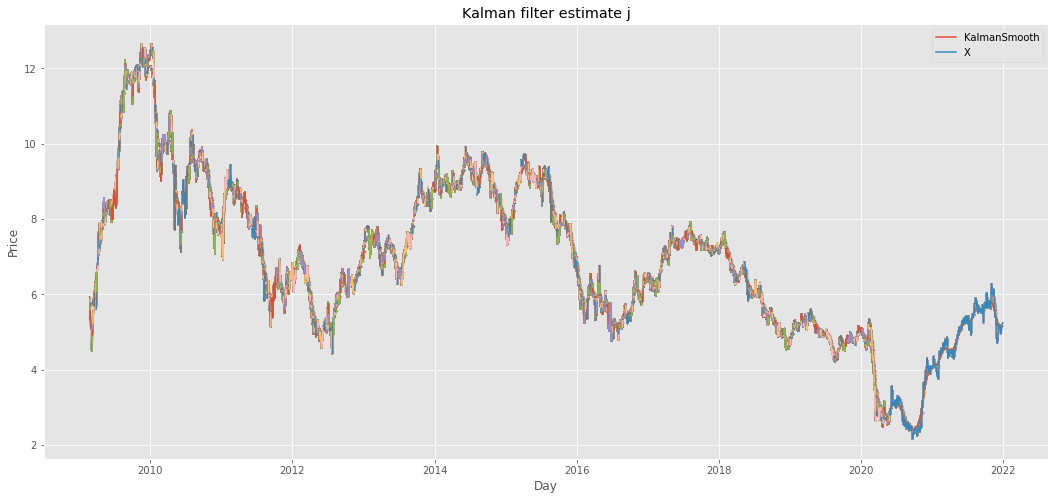

In [14]:
#Para pruebas
#TOTAL_len =1000

for i in range(TOTAL_len):
    endWindow3   =endWindow2 + dt.timedelta(days=i) 
    endWindow    =endWindow3.strftime("%Y-%m-%d")
    print ('end date:', endWindow)
    
    if(endWindow in dff.index):
        df_aux= dff.loc[startWindow:endWindow]       #voy pasando los datos desplazando la ventana
        
        recogo = regreMedia.analisis(instrumento, startWindow, endWindow, df_aux) #Llamada a la clase estrategia. LA CLAVE DE TODO!!!
        
        print ('................................................Analizando, muestra', i, 'de', TOTAL_len, 'fecha', endWindow)
        
        """
        Tratamiento de los returns, mejor en las funciones de analisis que hacer aquí.
        if(recogo['senal'] == 1 ):
            dff.loc[[endWindow],['Senal']]= 1
        elif(recogo['senal'] == 0 ):
            dff.loc[[endWindow],['Senal']]= 0
        elif(recogo['senal'] == -1 ):
            dff.loc[[endWindow],['Senal']]= -1            
        elif(recogo['senal'] == 503 ):
            dff.loc[[endWindow],['Senal']]= 0          
        """
            
    else:
        print('..............Día sin sesión, next please (notebook)')

        

***Recogemos los datos de las entradas que ha realizado la Estrategia***

In [15]:
data=rg.StrategyClass.dfLog
#data.dropna(inplace=True) 

In [16]:
data.tail()

Date Senal  Price Objetivo ExitReason  Beneficio
2021-12-28  2021-12-28     1  5.248      NaN        NaN   0.289242
2021-12-29  2021-12-29     1  5.266      NaN        NaN        NaN
2021-12-30  2021-12-30     1   5.25      NaN        NaN        NaN
2022-01-03  2022-01-03     1   5.26      NaN        NaN        NaN
2022-01-04  2022-01-04     1  5.393      NaN        NaN        NaN

<AxesSubplot:title={'center':'Señales de compra de la estrategia '}>

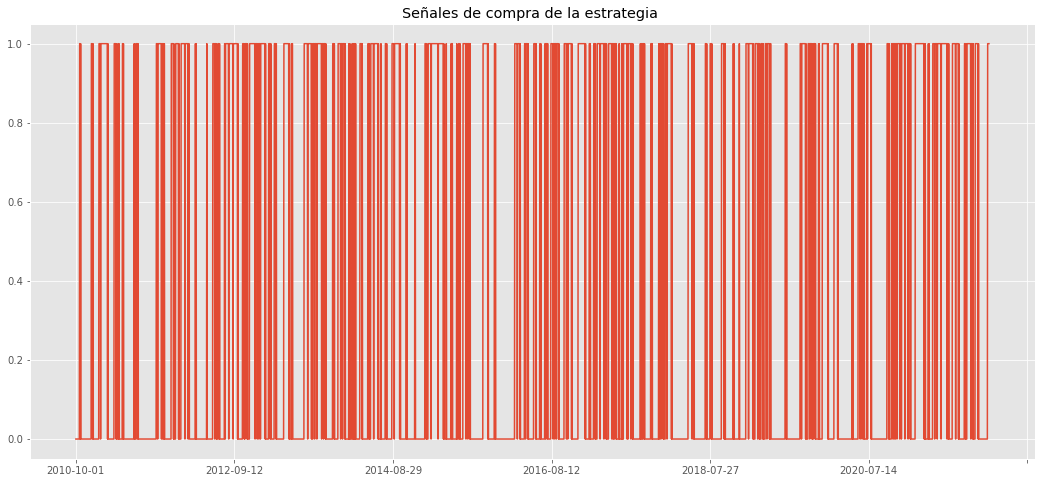

In [17]:
data['Senal'].plot(title = 'Señales de compra de la estrategia ' )
# Ploteando una parte
#data.loc['2010':'2022','Senal'].plot(title = 'Señales Regresión a la media ' +instrumento,xlim=('2010','2022'))

In [18]:
tiempo_final = time() 
 
tiempo_ejecucion = tiempo_final - tiempo_inicial
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion,"segundos") #En segundos

El tiempo de ejecucion fue: 2690.806261062622 segundos


In [19]:
data.loc['2011-01-04':'2019-11-04']

Date Senal   Price Objetivo ExitReason  Beneficio
2011-01-04  2011-01-04     0     7.6      NaN        NaN        NaN
2011-01-05  2011-01-05     0   7.503      NaN        NaN        NaN
2011-01-06  2011-01-06     0   7.341      NaN        NaN        NaN
2011-01-07  2011-01-07     0   7.156      NaN        NaN        NaN
2011-01-10  2011-01-10     0    6.92      NaN        NaN        NaN
...                ...   ...     ...      ...        ...        ...
2019-10-29  2019-10-29     1  4.8565      NaN        NaN        NaN
2019-10-30  2019-10-30     0  4.7345      NaN         -1        NaN
2019-10-31  2019-10-31     1   4.723      NaN        NaN   0.233789
2019-11-01  2019-11-01     0   4.733      NaN         -1        NaN
2019-11-04  2019-11-04     0   4.878      NaN        NaN        NaN

[2260 rows x 6 columns]

In [20]:
#Guardamos el resultado del analisis en un pickle
#dff.to_pickle("./primerBack_IBE.pkl")

***3.- Ingeniería de datos para calcular la bondad de la estrategia***

In [21]:

data['Dif_Close'] = data.Price.pct_change()
data['Retornos'] = data.Dif_Close * data.Senal.shift(1)   
data['Capital'] = (data.Retornos + 1).cumprod() * 100
    
rg.StrategyClass.dfLog=data  #Ojo a esta liena, no me cuadra.

#quant_j.salvarExcel(StrategyClass.dfLog, "log"+instrumento)   
#data.to_pickle('almacen')    #df = pd.read_pickle(file_name)

>Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar (si estaba comprado, sumo beneficio).

In [22]:
data.tail()

Date Senal  Price Objetivo ExitReason  Beneficio  Dif_Close  \
2021-12-28  2021-12-28     1  5.248      NaN        NaN   0.289242   0.003442   
2021-12-29  2021-12-29     1  5.266      NaN        NaN        NaN   0.003430   
2021-12-30  2021-12-30     1   5.25      NaN        NaN        NaN  -0.003038   
2022-01-03  2022-01-03     1   5.26      NaN        NaN        NaN   0.001905   
2022-01-04  2022-01-04     1  5.393      NaN        NaN        NaN   0.025285   

            Retornos    Capital  
2021-12-28       0.0  32.993856  
2021-12-29   0.00343  33.107019  
2021-12-30 -0.003038  33.006429  
2022-01-03  0.001905    33.0693  
2022-01-04  0.025285  33.905462

In [23]:
data[60:]

Date Senal  Price Objetivo ExitReason  Beneficio  Dif_Close  \
2010-12-27  2010-12-27     0   7.63      NaN        NaN        NaN  -0.023047   
2010-12-28  2010-12-28     0   7.61      NaN        NaN        NaN  -0.002621   
2010-12-29  2010-12-29     0  7.664      NaN        NaN        NaN   0.007096   
2010-12-30  2010-12-30     0   7.56      NaN        NaN        NaN  -0.013570   
2011-01-03  2011-01-03     0    7.6      NaN        NaN        NaN   0.005291   
...                ...   ...    ...      ...        ...        ...        ...   
2021-12-28  2021-12-28     1  5.248      NaN        NaN   0.289242   0.003442   
2021-12-29  2021-12-29     1  5.266      NaN        NaN        NaN   0.003430   
2021-12-30  2021-12-30     1   5.25      NaN        NaN        NaN  -0.003038   
2022-01-03  2022-01-03     1   5.26      NaN        NaN        NaN   0.001905   
2022-01-04  2022-01-04     1  5.393      NaN        NaN        NaN   0.025285   

            Retornos    Capital  
2010-12-27      -0.0  90.681871  
2010-12-28      -0.0  90.681871  
2010-12-29       0.0  90.681871  
2010-12-30      -0.0  90.681871  
2011-01-03       0.0  90.681871  
...              ...        ...  
2021-12-28       0.0  32.993856  
2021-12-29   0.00343  33.107019  
2021-12-30 -0.003038  33.006429  
2022-01-03  0.001905    33.0693  
2022-01-04  0.025285  33.905462  

[2820 rows x 9 columns]

>El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [24]:
def grafico (df):
    estudio = df.copy()
    
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    #Primer plot analiza la evolcuion de una inversion de 100€ en buy&hold y la estrategia)
    ax1.plot(estudio.Capital)
    ax1.plot((estudio.Price) * (100/estudio.Price[1]))
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    #ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

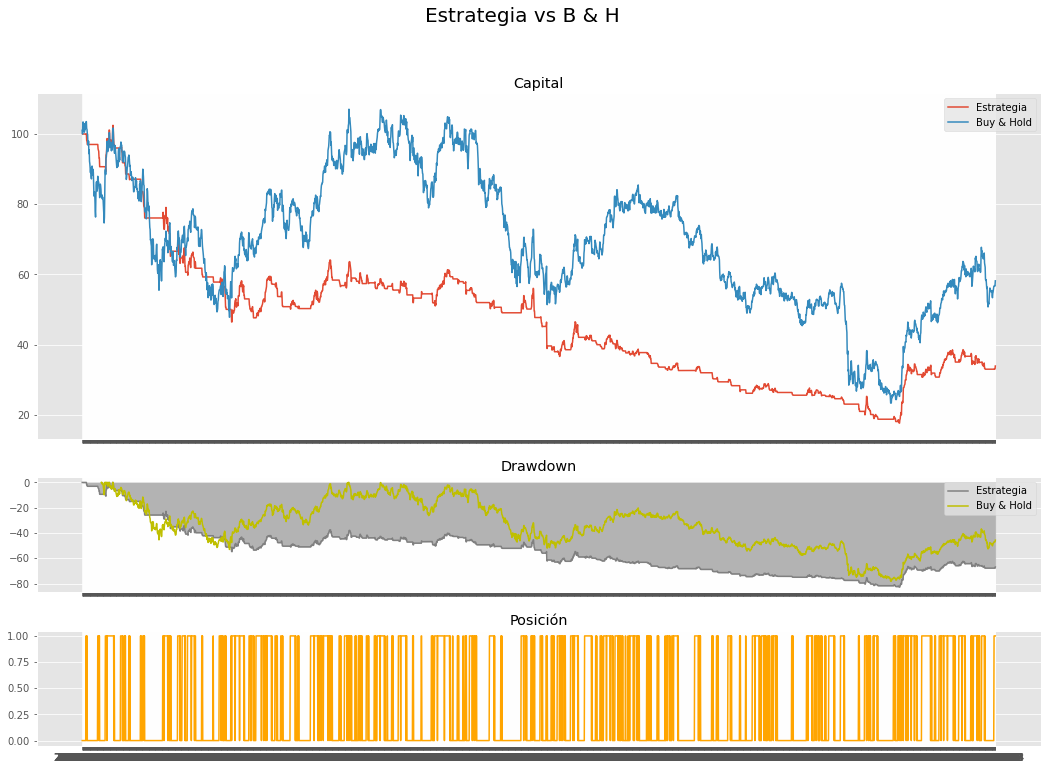

In [25]:
grafico(data)

---

In [26]:
#data[55:70]

---

# ANALISIS DEL SISTEMA

In [27]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[1]
print ('Beneficio Bruto : {:.2f} €  con una inverison de 100€'.format(Beneficio_Bruto))

Beneficio Bruto : -66.09 €  con una inverison de 100€


In [28]:
#Rentabilidad anual compuesta. Calculamos lo que la inversion se ha incrementado cada año con el interes compuesto
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : -9.16%


In [29]:
#Ratio calculado restando una rentabilidad segura a nuestra rentabilidad de estrategia y dividido por el riego (=volatilidad)
data.Retornos=data.Retornos.replace(0,np.e)  #Quito los cero (no sepuede hacer logariotmo de cero), pero no se que poner
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : -0.092


In [30]:
# Actualizo la excel con los economic
regreMedia.analisisEconomics(instrumento)

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


---



---